In [2]:
from matplotlib import markers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from seaborn import palettes
import json
import os
import re
import math
import matplotlib.ticker as tck
import glob
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import StandardScaler

Loading files

In [3]:
saving_path = 'C:/Users/srboval1/OneDrive - Aalto University/Collab/Ivaska_collab/data'
all = pd.read_csv(saving_path +'/all_data.csv', index_col=None)

download_closeby = pd.read_csv(saving_path +'/closeby_beads.csv', index_col=None)
download_faraway = pd.read_csv(saving_path +'/faraway_beads.csv', index_col=None)

Kernel Ridge Regression

In [31]:
download = all[all['incubation_set']!='0']
download1 = all[all['incubation_set']=='0']
print(f"{all.shape},{download.shape},{download1.shape}")
download1.columns

(1231, 39),(975, 39),(256, 39)


Index(['Unnamed: 0', 'day', 'sample', 'holder', 'location', 'track_id',
       'reference_id', 'distance(um)', 'Cov_Sum', 'a_(um)', 'phi_(rad)', 'c',
       'd', 'G_abs', 'radius_(m)', 'rmse', 'inv.rmse', 'shift_(s)', 'a_error',
       'phi_error', 'c_error', 'd_error', 'x', 'y', 'repeat', 'phi_(deg)',
       'tan_phi', 'path', 'irradiation', 'incubation_set', 'incubation',
       'experiment', 'cell/control', 'bead_radius', 'location_inverse',
       'gradient', 'gradient_inverse', 'gradient_direction', 'experiment_id'],
      dtype='object')

In [50]:
download.groupby('incubation_set')[['bead_radius', 'irradiation','cell/control','experiment_id']] \
    .apply(lambda x: x.apply(lambda col: ', '.join(map(str, col.unique())), axis=0)) \
    .reset_index(drop=False)


incubation_set bead_radius irradiation       cell/control  \
0          0_168        50um         50s  control, MDAMB231   
1         24_120        10um         50s  MDAMB231, control   
2         48_144        10um         50s  control, MDAMB231   

                    experiment_id  
0                         2, 1, 3  
1  14, 15, 23, 22, 11, 10, 18, 19  
2  13, 12, 20, 21, 17, 16, 24, 25

In [49]:
download1.groupby('experiment_id')[['bead_radius', 'irradiation','cell/control','incubation']] \
    .apply(lambda x: x.apply(lambda col: col.unique(), axis=0)) \
    .reset_index(drop=False)\
    .drop('level_1', axis=1)

experiment_id bead_radius irradiation cell/control  incubation
0              0        30um         50s      control           2
1              4        10um         50s     MDAMB231           2
2              5        10um         50s      control           2
3              6         mix         50s     MDAMB231           2
4              7         mix         70s     MDAMB231           2
5              8        10um         50s      control           2
6              9        10um         50s      control           2

Continuous

In [20]:
def fitting_kernel(x, y, ax,alpha, color, marker):
    x_reshaped = x.values.reshape(-1, 1)  #     # Reshape x to a 2D array (required for scikit-learn models), converts x into a 2D array with shape (n_samples, 1)
    y_reshaped = y.values 
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(x_reshaped) 
    
    # Initialize Kernel Ridge Regression model
    # similarity between two points in higher-dimensional space = this is done using a kernel function, here Radial Basis Function (RBF) kernel
    # ALPHA = regularization factor
    krr = KernelRidge(kernel='rbf', alpha=alpha)  # A larger --> more regularization; model prioritizes simpler solutions fitting general trend and not capture smaller details
    # Fit the model with the given data
    krr.fit(x_scaled, y_reshaped)

    # Grid of x values for the kernel fit (scaled)
    x_fit = np.linspace(np.min(x_scaled), np.max(x_scaled), 1000)[:, np.newaxis]  # Fine grid for prediction
    y_fit = krr.predict(x_fit)  # Predict the y values for the fine grid

    # Rescale x_fit back to original scale for plotting
    x_fit_original = scaler.inverse_transform(x_fit)  # Rescale the x values back

    # Plot the original data as a scatter plot
    ax.scatter(x_reshaped, y_reshaped, label='Original Data', color=color, marker=marker,s=50)
    
    #ax.boxplot(x_reshaped, y_reshaped, label='Original Data')

    # Plot the kernel fit (the kernel regression curve)
    ax.plot(x_fit_original, y_fit,color=color, label='Kernel Fit', linewidth=3)


Continous plot by distance

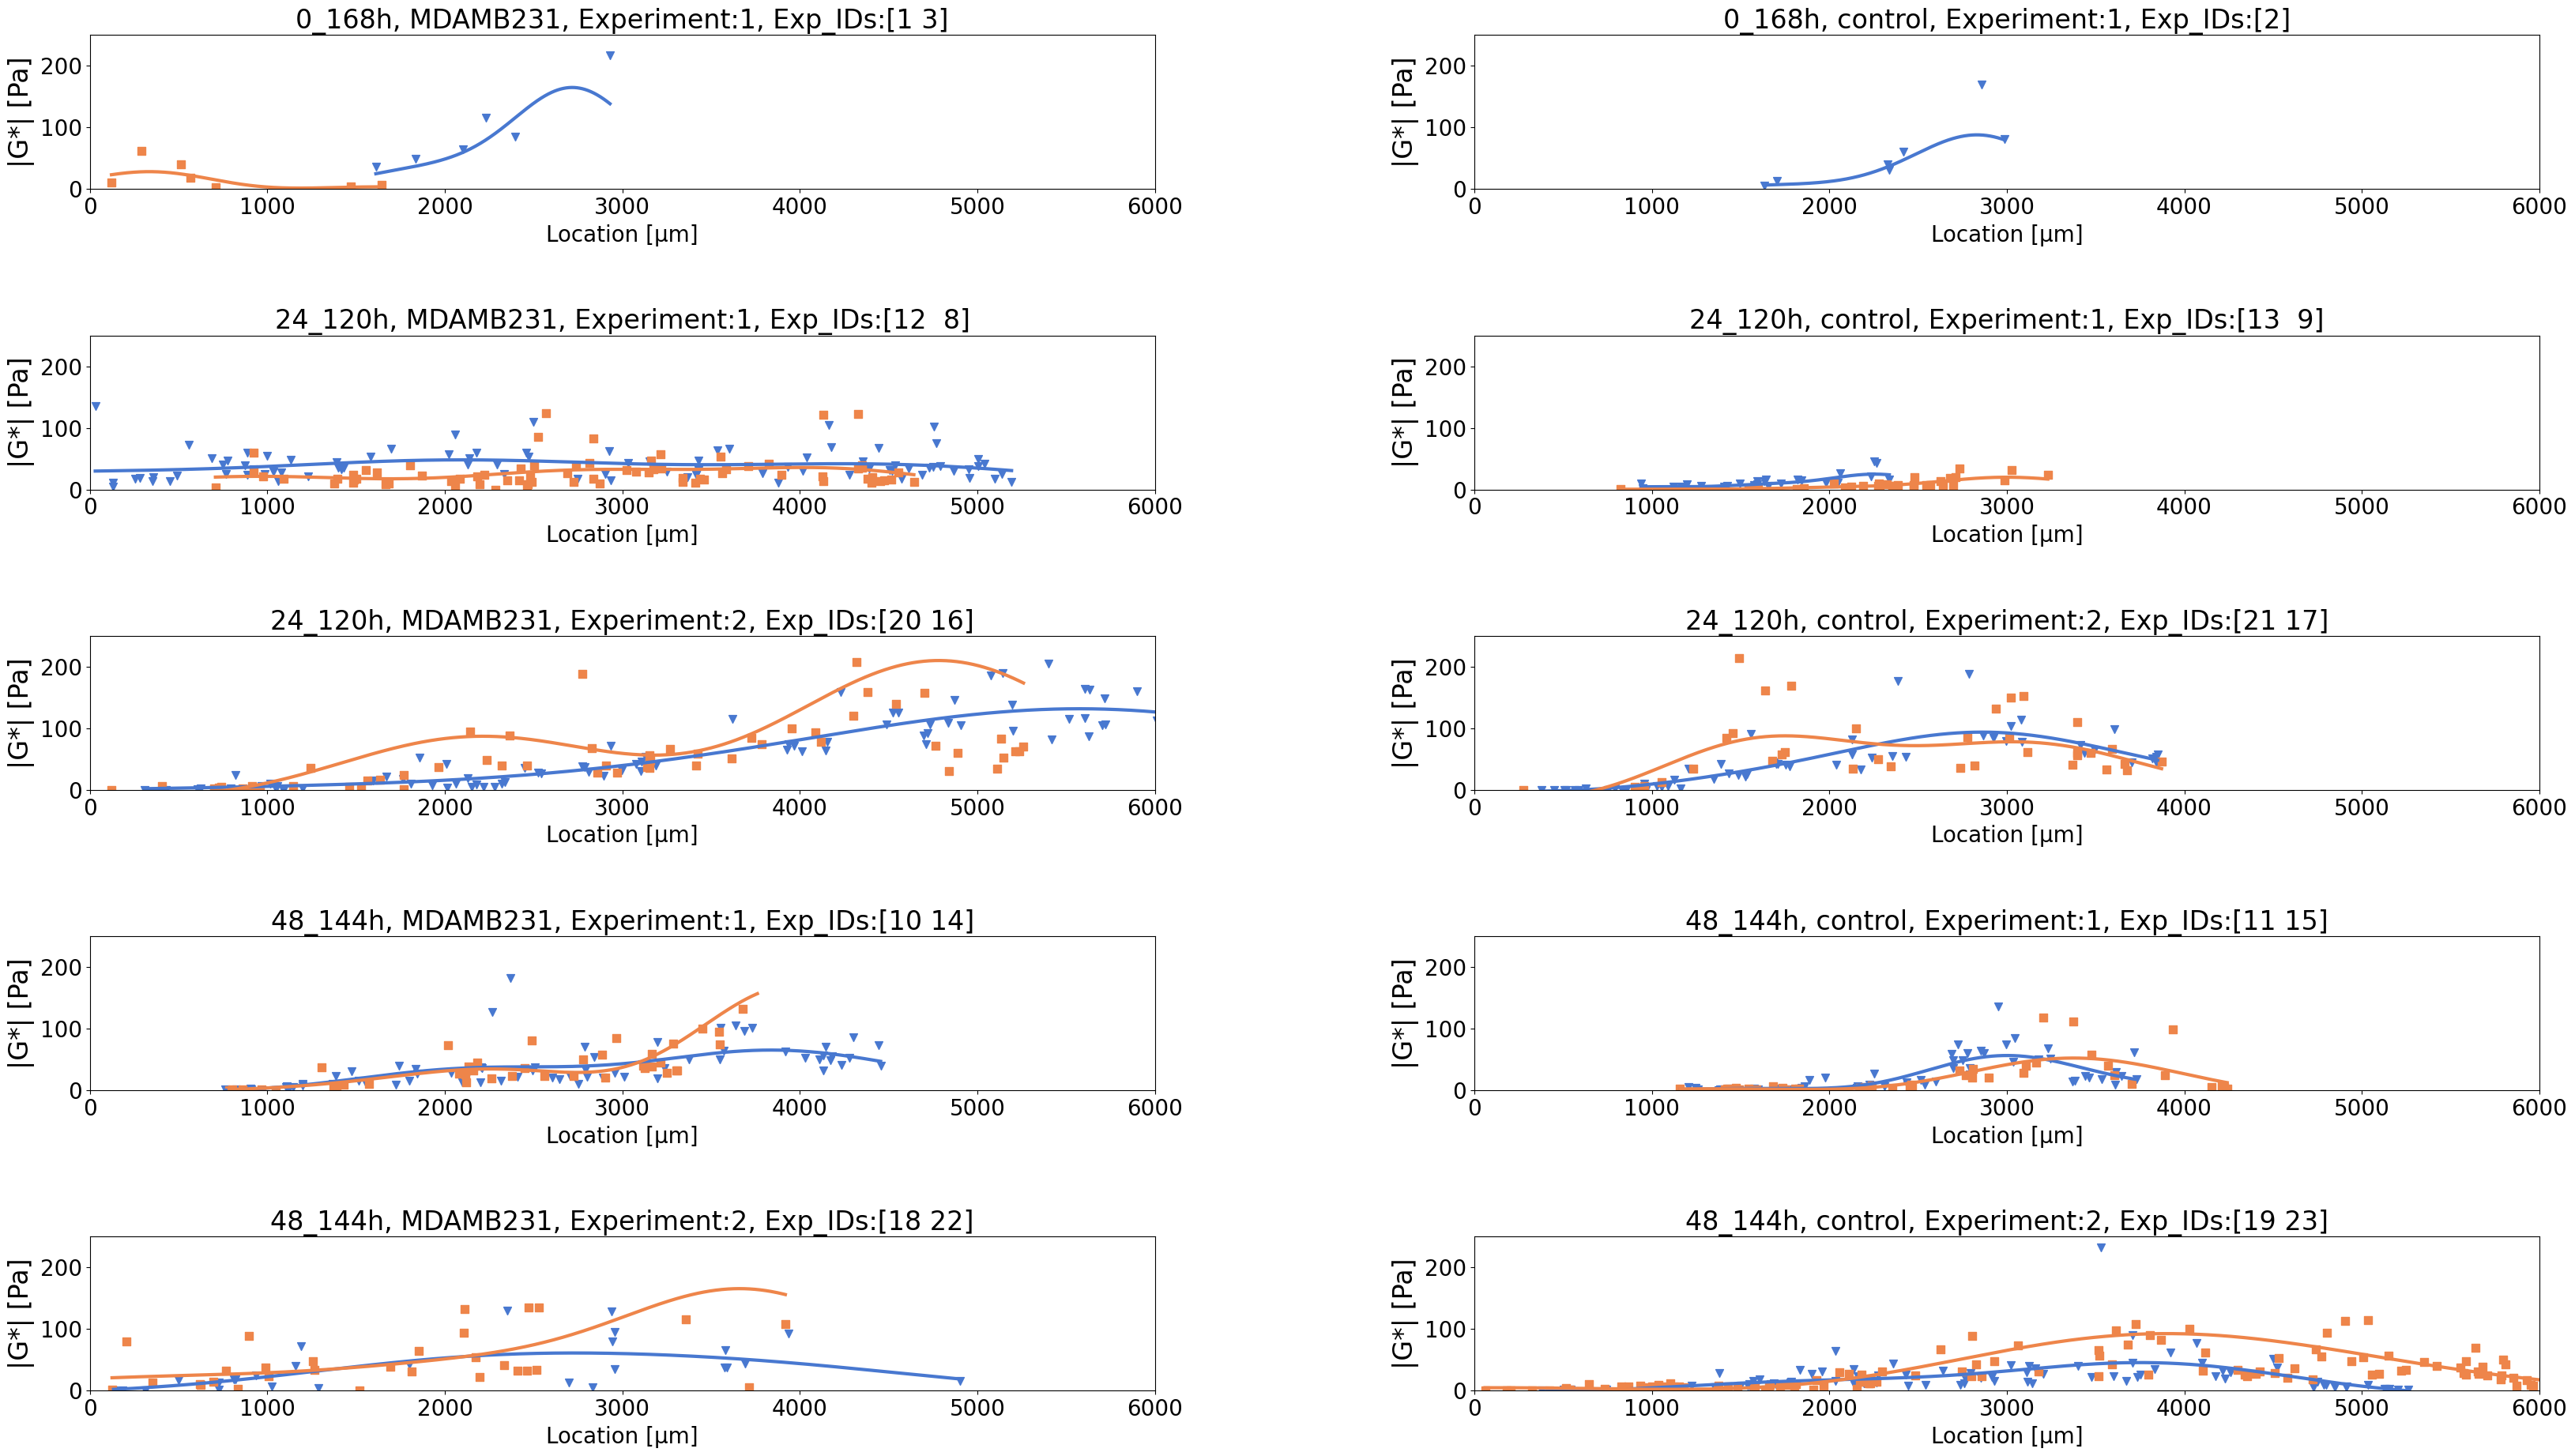

In [ ]:
fig, axs = plt.subplots(5, 2, figsize=(40, 22))
plt.subplots_adjust(wspace=0.3, hspace=0.95, bottom=0.1)  # Adjust bottom to make space for the legend
# fig.suptitle("Remodelling UV=50s ", fontsize=22)

markers = ['v', 's']
colors = sns.color_palette("muted",2)

def plotting(group_data,j, ax, exp_type, incubation_set, experiment,exp_ids):
    if (group_data['gradient_direction'] == 'stiff_to_soft').all():
        x_data = group_data['gradient_inverse']
    else:
        x_data = group_data['gradient']
    
    fitting_kernel(x_data, group_data['G_abs'], ax, 1, colors[j], markers[j])
    ax.set_xlabel("Location [µm]", fontsize=20, labelpad=5)
    ax.set_ylabel("|G*| [Pa]", fontsize=24, labelpad=5)
    ax.set_title(f"{incubation_set}h, {exp_type}, 
                 :{experiment+1}, Exp_IDs:{exp_ids}", fontsize=24)
    ax.tick_params(axis='both', labelsize=20)
    ax.set_ylim(0, 250)
    ax.set_xlim(0, 6000)

    ax.legend(title="Incubation [hours]", fontsize=20, title_fontsize=22, loc='upper left', bbox_to_anchor=(1.01, 1), frameon=False)
    ax.legend().set_visible(False)
    
def parse_incubation(group_data, ax, incubation_set, experiment, exp_type):
    group_data = group_data[group_data['cell/control'] == exp_type]
    exp_ids=group_data['experiment_id'].unique()
    for j, (incubation_value, group) in enumerate(group_data.groupby('incubation')):
        plotting(group, j, ax, exp_type, incubation_set, experiment, exp_ids)

for i, ((incubation_set, experiment), group_data) in enumerate(download.groupby(['incubation_set', 'experiment'])):
    parse_incubation(group_data, axs[i, 0], incubation_set, experiment, 'MDAMB231')
    parse_incubation(group_data, axs[i, 1], incubation_set, experiment, 'control')

plt.show()


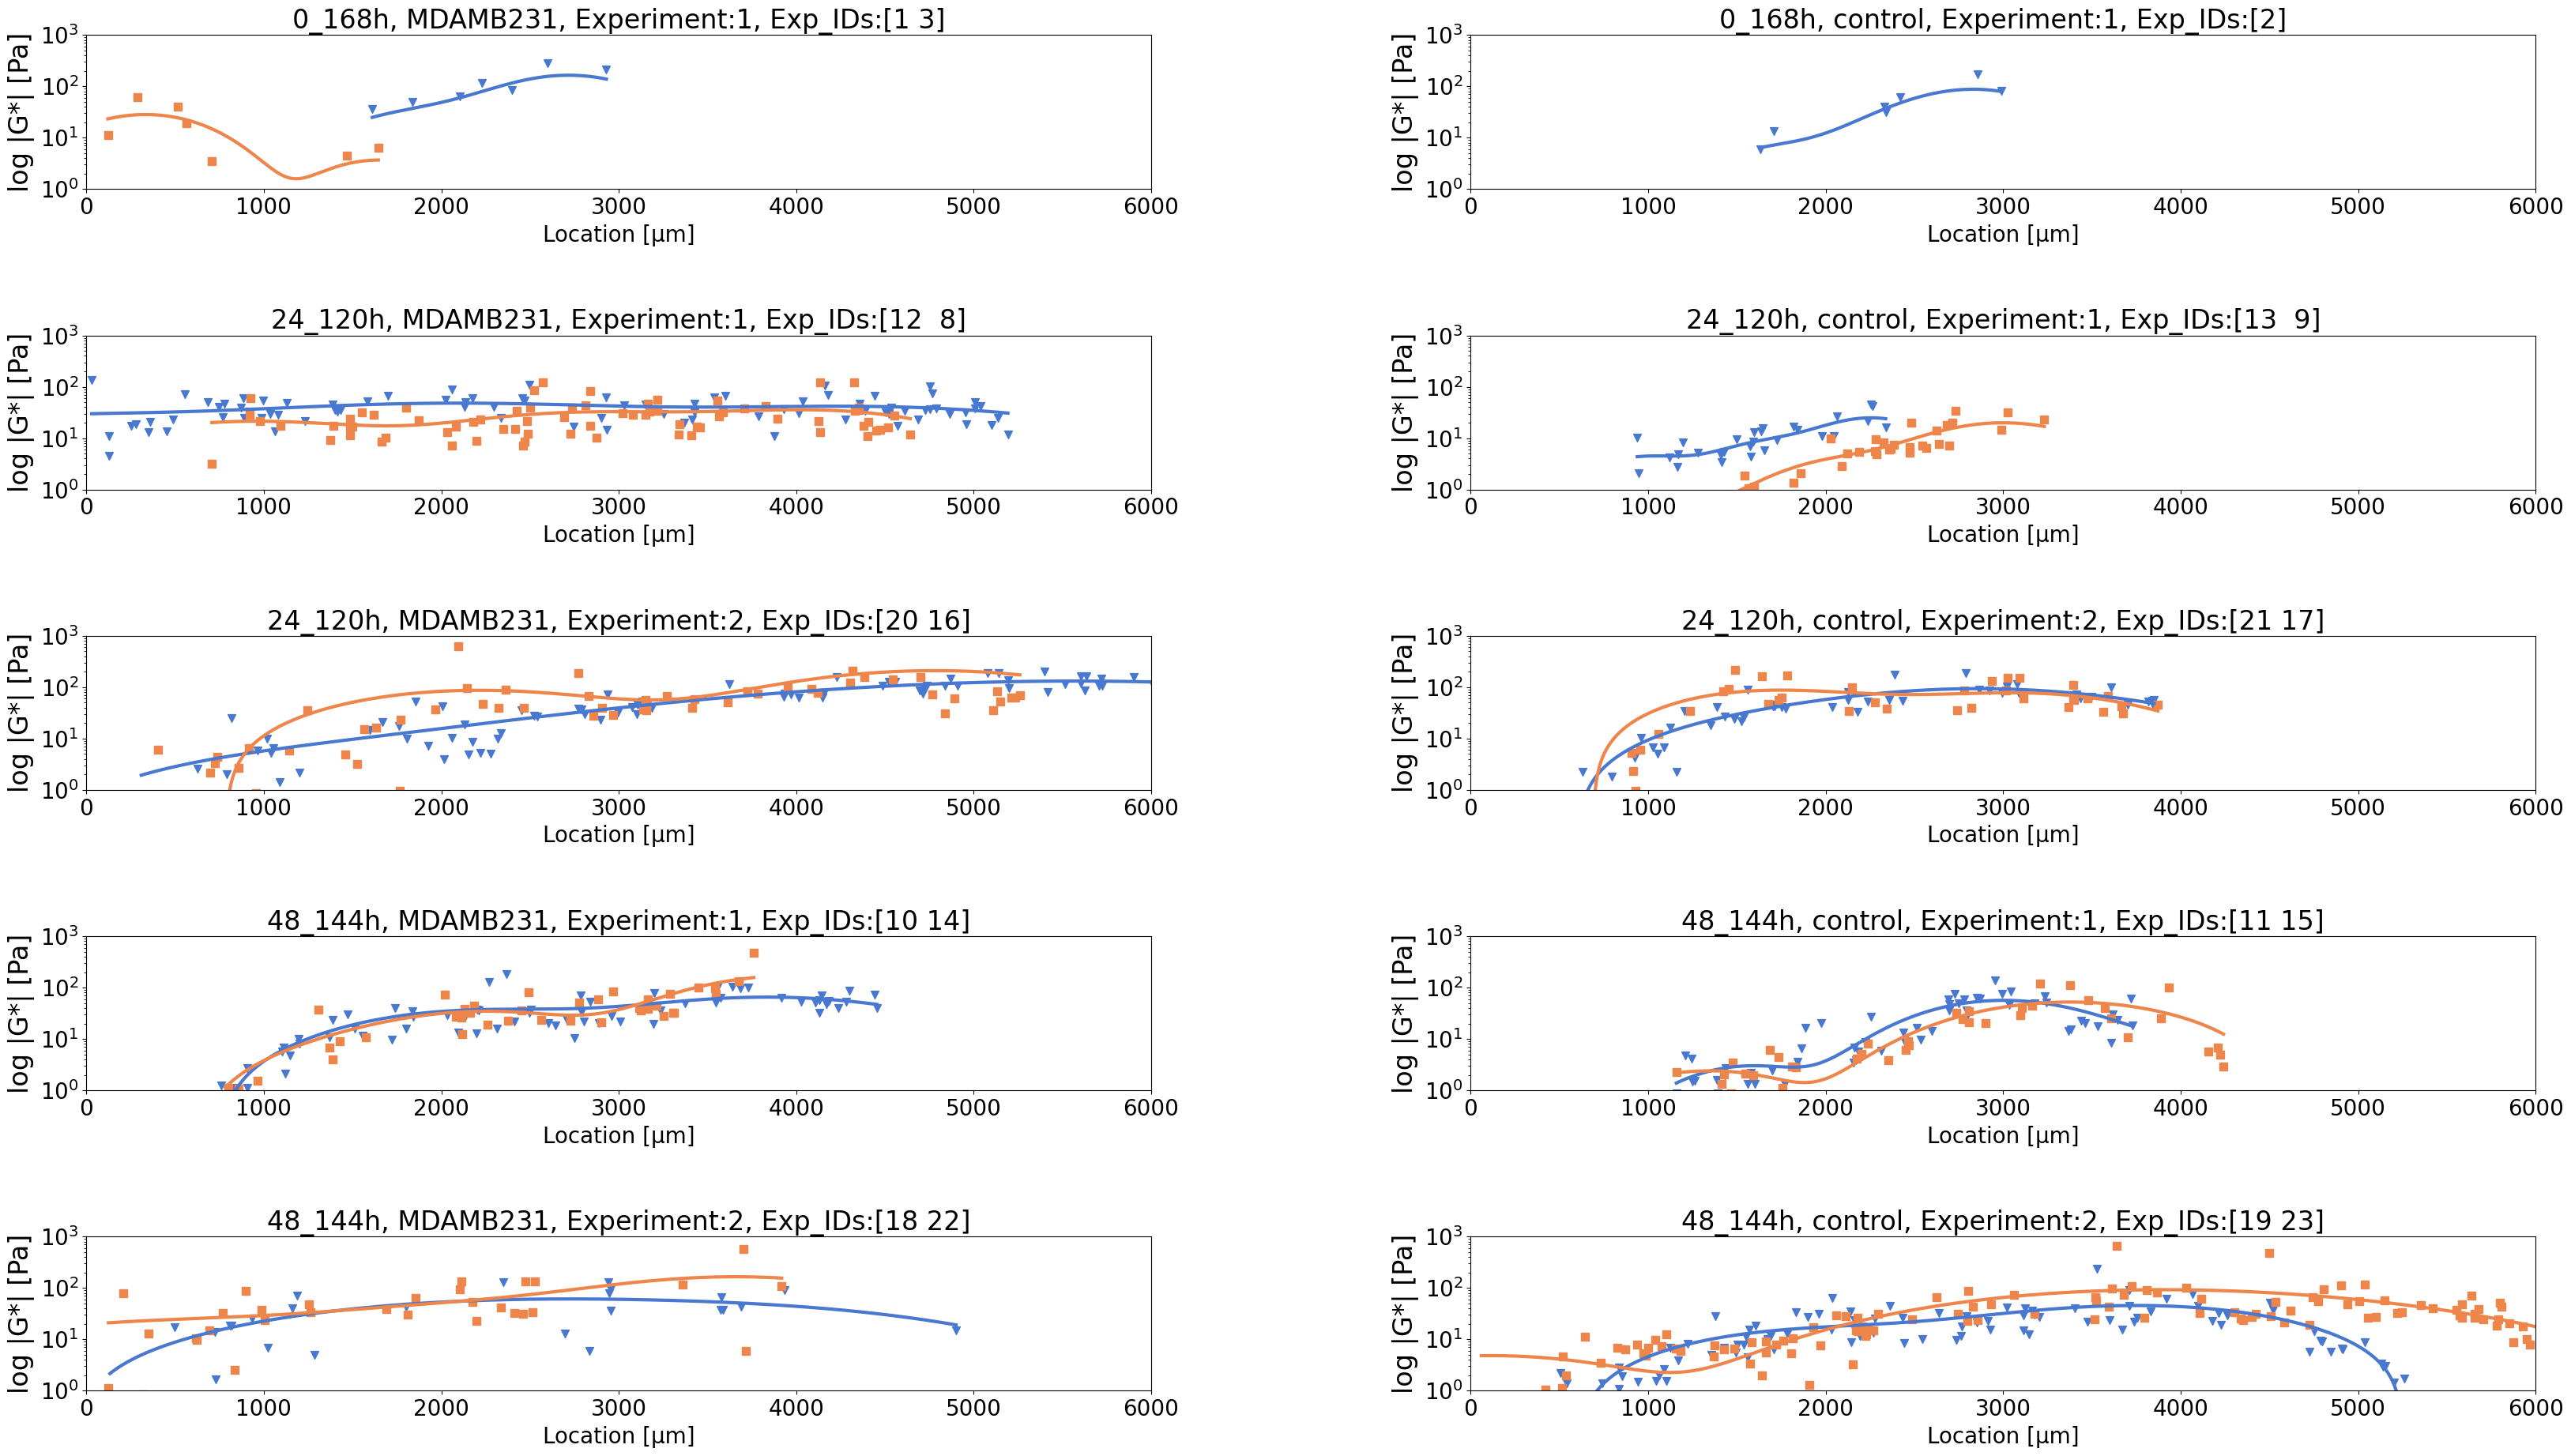

In [25]:
fig, axs = plt.subplots(5, 2, figsize=(40, 22))
plt.subplots_adjust(wspace=0.3, hspace=0.95, bottom=0.1)  # Adjust bottom to make space for the legend
# fig.suptitle("Remodelling UV=50s ", fontsize=22)

markers = ['v', 's']
colors = sns.color_palette("muted",2)

def plotting(group_data,j, ax, exp_type, incubation_set, experiment,exp_ids):
    if (group_data['gradient_direction'] == 'stiff_to_soft').all():
        x_data = group_data['gradient_inverse']
    else:
        x_data = group_data['gradient']
    
    fitting_kernel(x_data, group_data['G_abs'], ax, 1, colors[j], markers[j])

    ax.set_xlabel("Location [µm]", fontsize=20, labelpad=5)
    ax.set_ylabel("log |G*| [Pa]", fontsize=24, labelpad=5)
    ax.set_title(f"{incubation_set}h, {exp_type}, Experiment:{experiment+1}, Exp_IDs:{exp_ids}", fontsize=24)
    ax.tick_params(axis='both', labelsize=20)
    ax.set_xlim(0, 6000)

    ax.legend(title="Incubation [hours]", fontsize=20, title_fontsize=22, loc='upper left', bbox_to_anchor=(1.01, 1), frameon=False)
    ax.legend().set_visible(False)
    ax.set_ylim(1, 1000)

    ax.set_yscale('log')
def parse_incubation(group_data, ax, incubation_set, experiment, exp_type):
    group_data = group_data[group_data['cell/control'] == exp_type]
    exp_ids=group_data['experiment_id'].unique()
    for j, (incubation_value, group) in enumerate(group_data.groupby('incubation')):
        plotting(group, j, ax, exp_type, incubation_set, experiment,exp_ids)

for i, ((incubation_set, experiment), group_data) in enumerate(download.groupby(['incubation_set', 'experiment'])):
    parse_incubation(group_data, axs[i, 0], incubation_set, experiment, 'MDAMB231')
    parse_incubation(group_data, axs[i, 1], incubation_set, experiment, 'control')

plt.show()


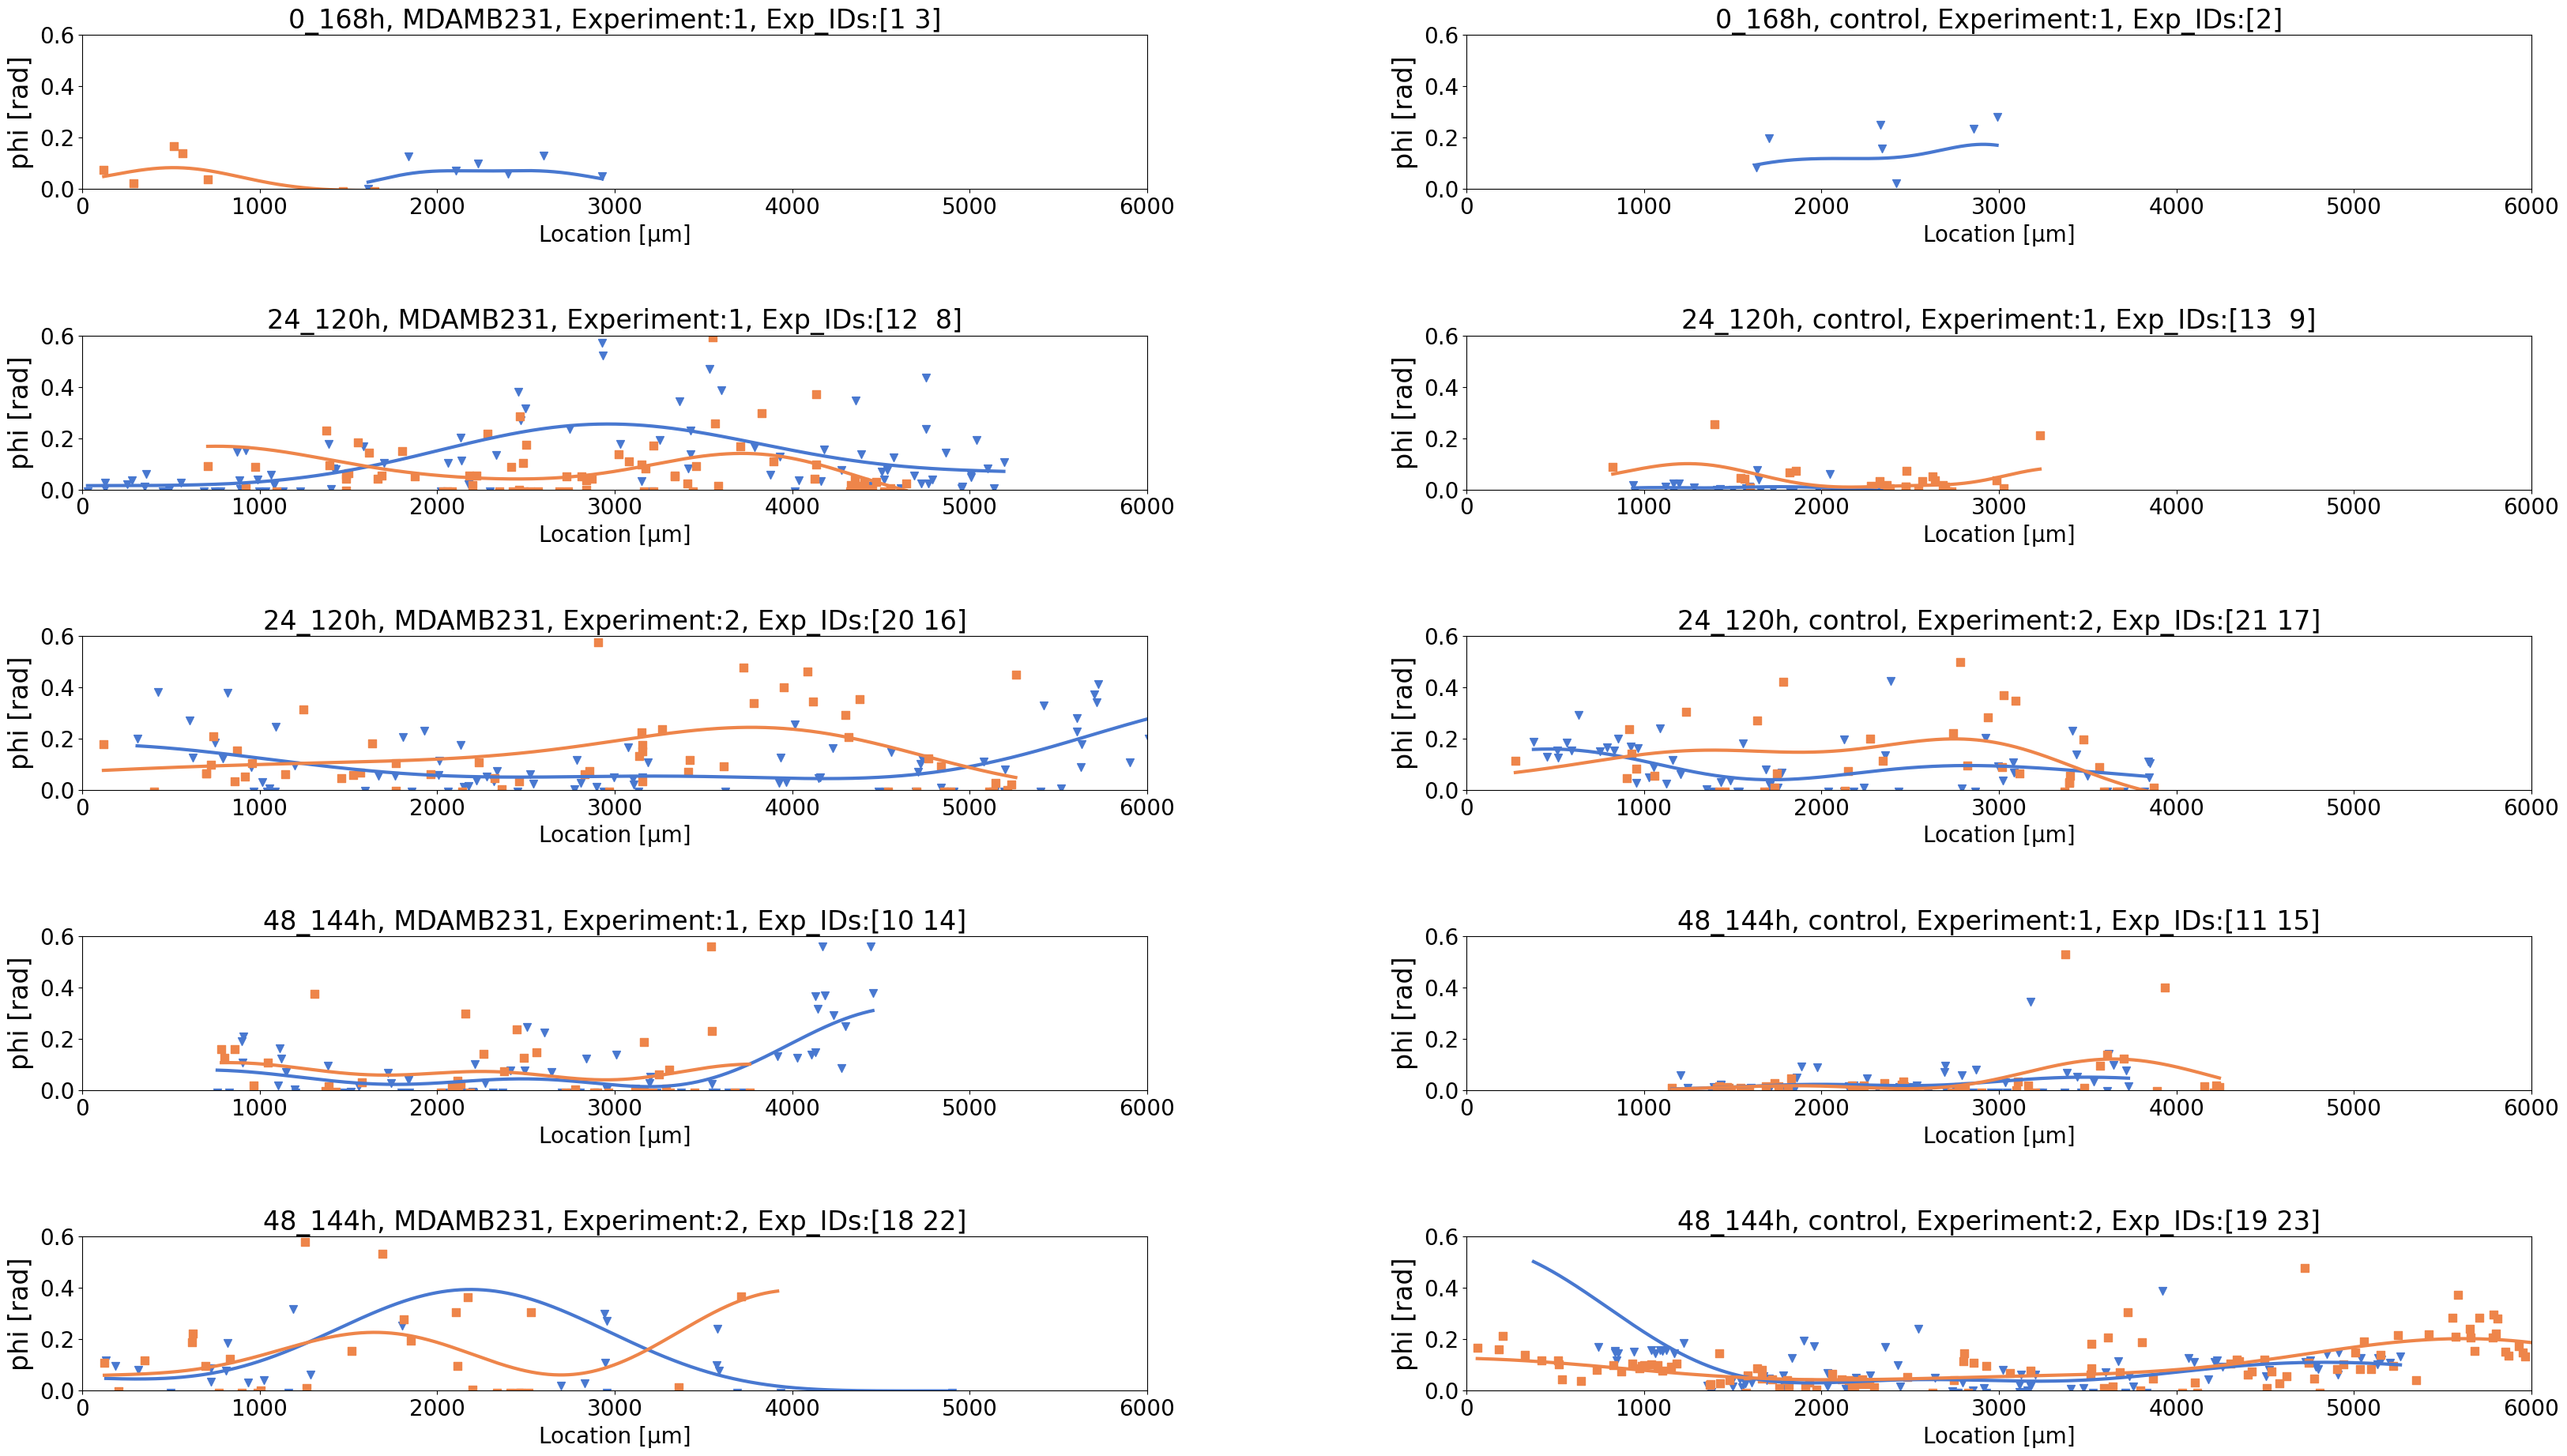

In [27]:
fig, axs = plt.subplots(5, 2, figsize=(40, 22))
plt.subplots_adjust(wspace=0.3, hspace=0.95, bottom=0.1)  # Adjust bottom to make space for the legend
# fig.suptitle("Remodelling UV=50s ", fontsize=22)

markers = ['v', 's']
colors = sns.color_palette("muted",2)

def plotting(group_data,j, ax, exp_type, incubation_set, experiment,exp_ids):
    if (group_data['gradient_direction'] == 'stiff_to_soft').all():
        x_data = group_data['gradient_inverse']
    else:
        x_data = group_data['gradient']
    
    fitting_kernel(x_data, group_data['phi_(rad)'], ax, 1, colors[j], markers[j])

    ax.set_xlabel("Location [µm]", fontsize=20, labelpad=5)
    ax.set_ylabel("phi [rad]", fontsize=24, labelpad=5)
    ax.set_title(f"{incubation_set}h, {exp_type}, Experiment:{experiment+1}, Exp_IDs:{exp_ids}", fontsize=24)
    ax.tick_params(axis='both', labelsize=20)
    ax.set_ylim(0, 0.6)
    ax.set_xlim(0, 6000)

    ax.legend(title="Incubation [hours]", fontsize=20, title_fontsize=22, loc='upper left', bbox_to_anchor=(1.01, 1), frameon=False)
    ax.legend().set_visible(False)

def parse_incubation(group_data, ax, incubation_set, experiment, exp_type):
    group_data = group_data[group_data['cell/control'] == exp_type]
    exp_ids=group_data['experiment_id'].unique()
    for j, (incubation_value, group) in enumerate(group_data.groupby('incubation')):
        plotting(group, j, ax, exp_type, incubation_set, experiment,exp_ids)

for i, ((incubation_set, experiment), group_data) in enumerate(download.groupby(['incubation_set', 'experiment'])):
    parse_incubation(group_data, axs[i, 0], incubation_set, experiment, 'MDAMB231')
    parse_incubation(group_data, axs[i, 1], incubation_set, experiment, 'control')

plt.show()


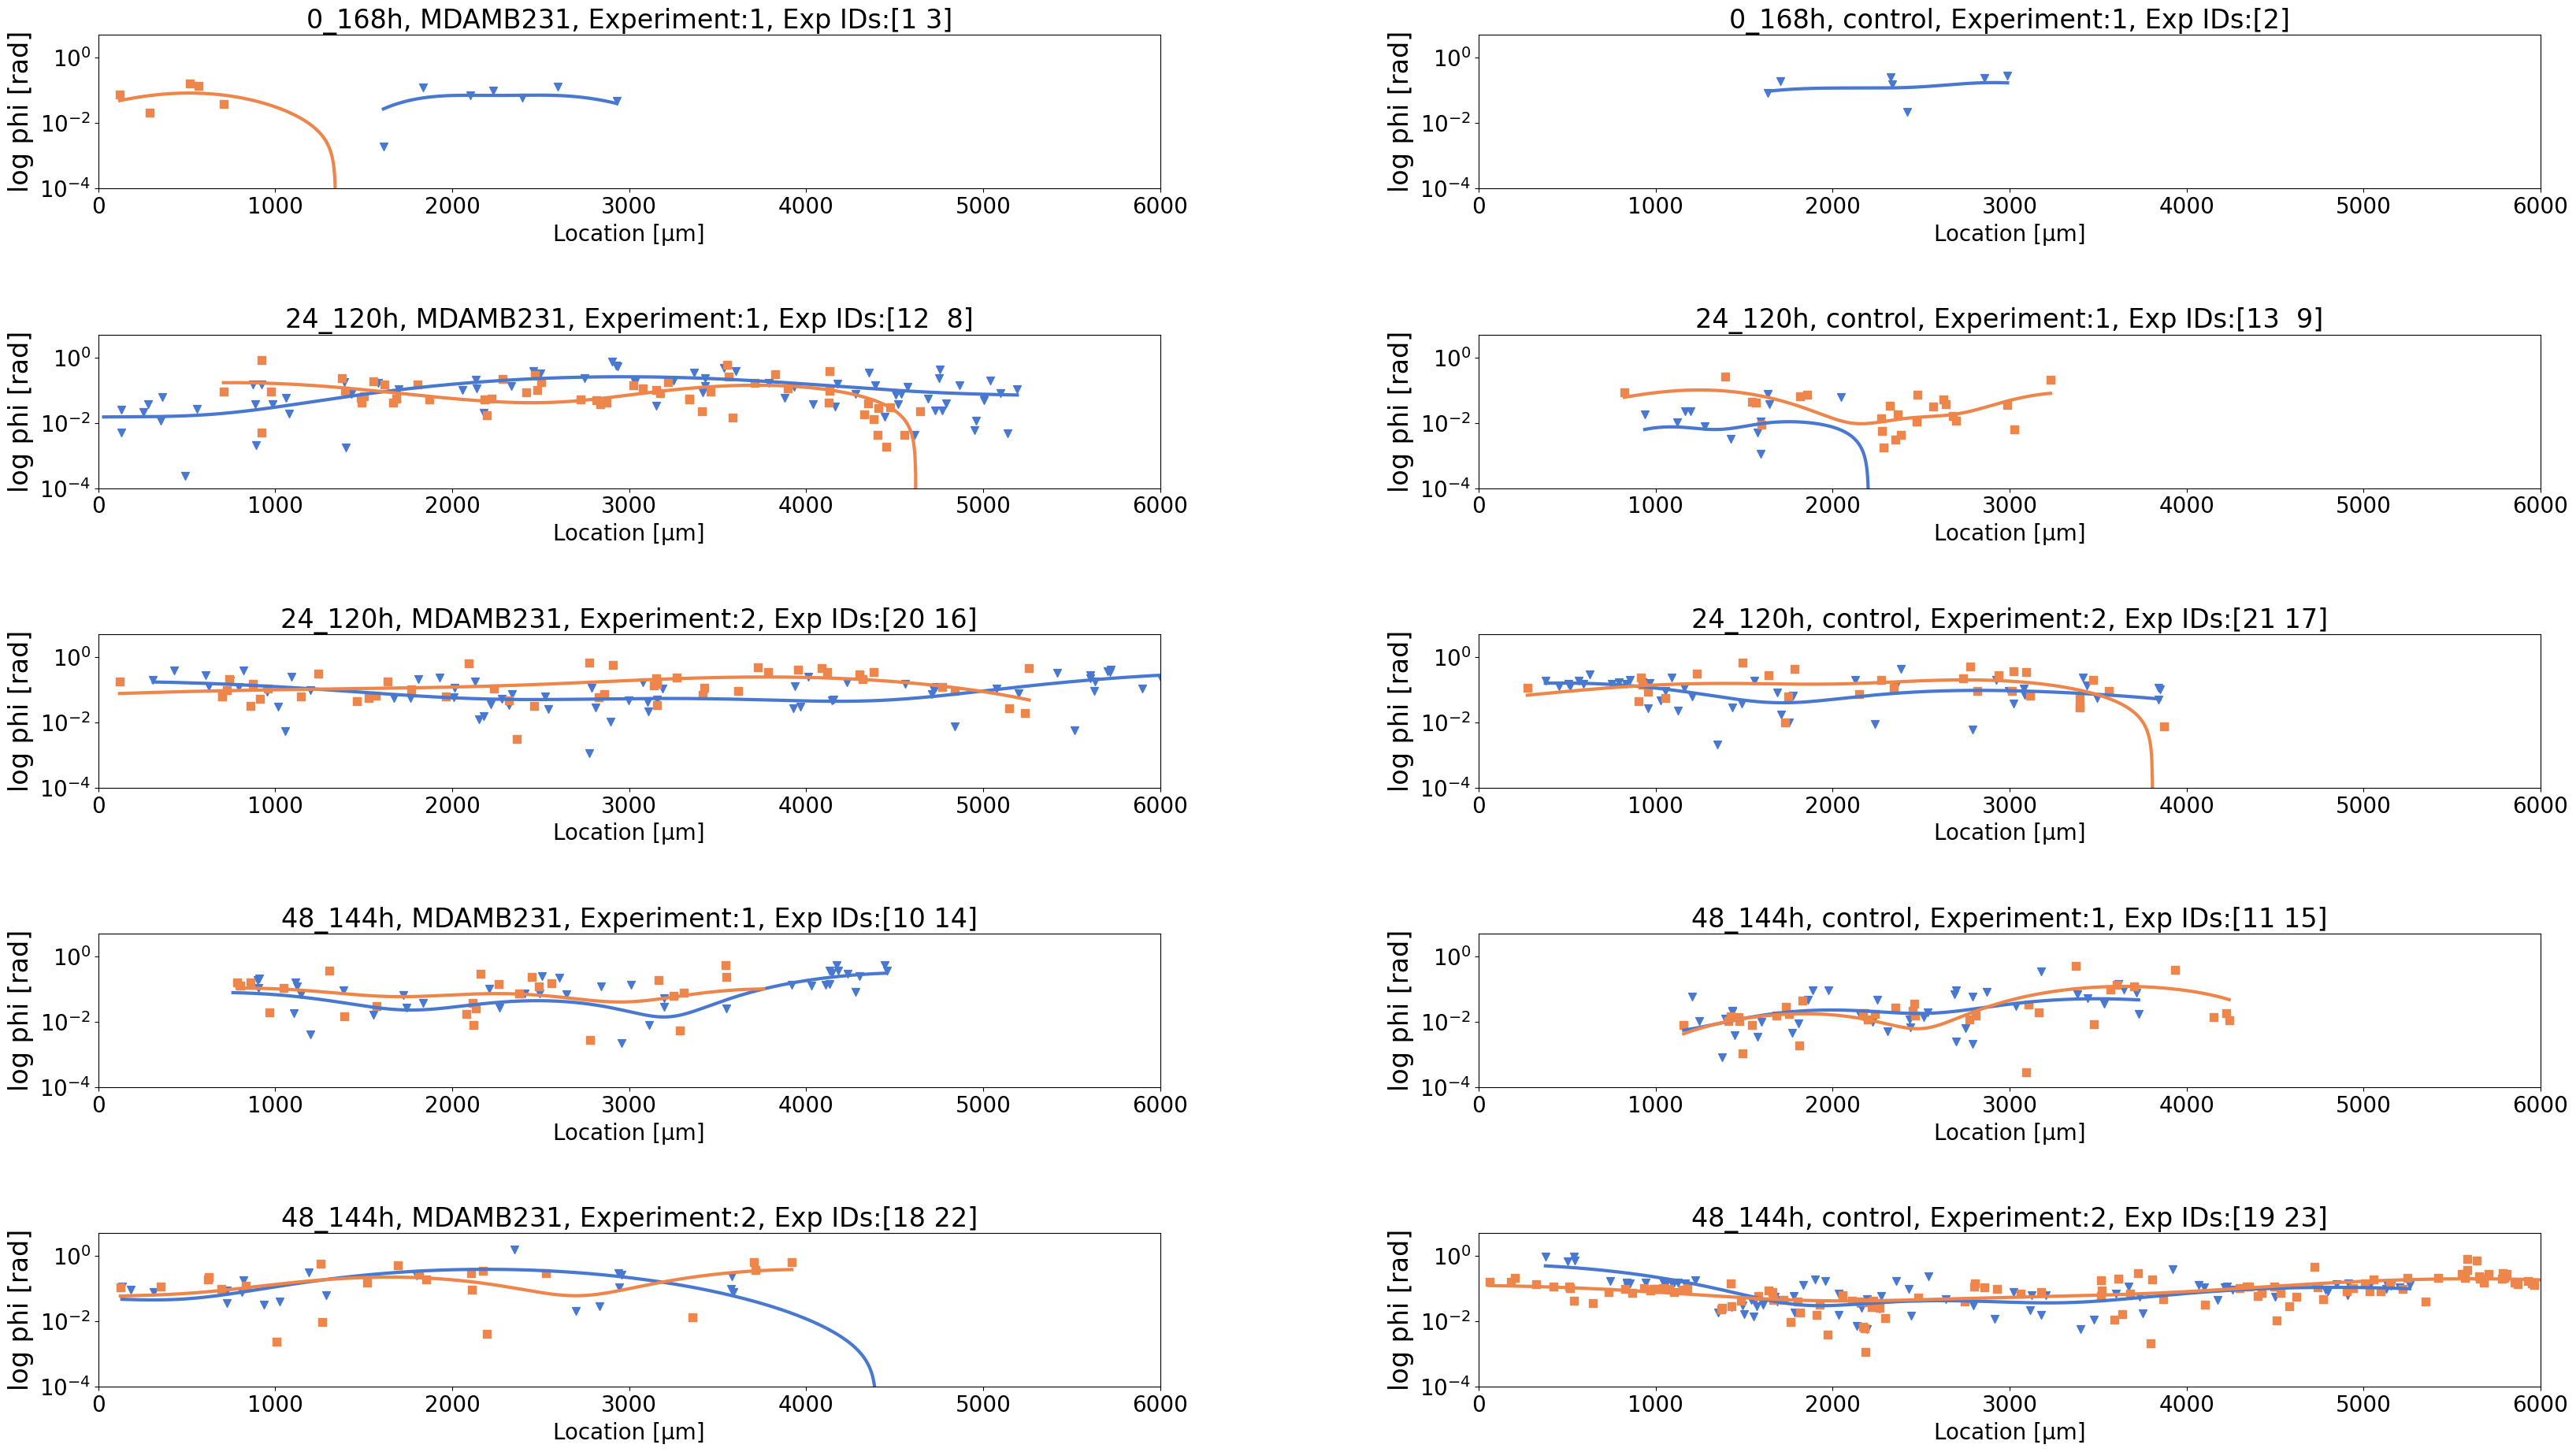

In [28]:
fig, axs = plt.subplots(5, 2, figsize=(40, 22))
plt.subplots_adjust(wspace=0.3, hspace=0.95, bottom=0.1)  # Adjust bottom to make space for the legend
# fig.suptitle("Remodelling UV=50s ", fontsize=22)

markers = ['v', 's']
colors = sns.color_palette("muted",2)

def plotting(group_data,j, ax, exp_type, incubation_set, experiment,exp_ids):
    if (group_data['gradient_direction'] == 'stiff_to_soft').all():
        x_data = group_data['gradient_inverse']
    else:
        x_data = group_data['gradient']
    
    fitting_kernel(x_data, group_data['phi_(rad)'], ax, 1, colors[j], markers[j])

    ax.set_xlabel("Location [µm]", fontsize=20, labelpad=5)
    ax.set_ylabel("log phi [rad]", fontsize=24, labelpad=5)
    ax.set_title(f"{incubation_set}h, {exp_type}, Experiment:{experiment+1}, Exp IDs:{exp_ids}", fontsize=24)
    ax.tick_params(axis='both', labelsize=20)
    ax.set_yscale('log')
    ax.set_ylim(0.0001, 5)
    ax.set_xlim(0, 6000)

    ax.legend(title="Incubation [hours]", fontsize=20, title_fontsize=22, loc='upper left', bbox_to_anchor=(1.01, 1), frameon=False)
    ax.legend().set_visible(False)

def parse_incubation(group_data, ax, incubation_set, experiment, exp_type):
    group_data = group_data[group_data['cell/control'] == exp_type]
    exp_ids = group_data['experiment_id'].unique()
    for j, (incubation_value, group) in enumerate(group_data.groupby('incubation')):
        plotting(group, j, ax, exp_type, incubation_set, experiment,exp_ids)

for i, ((incubation_set, experiment), group_data) in enumerate(download.groupby(['incubation_set', 'experiment'])):
    parse_incubation(group_data, axs[i, 0], incubation_set, experiment, 'MDAMB231')
    parse_incubation(group_data, axs[i, 1], incubation_set, experiment, 'control')

plt.show()


Binned plot by locations

Time-series G*

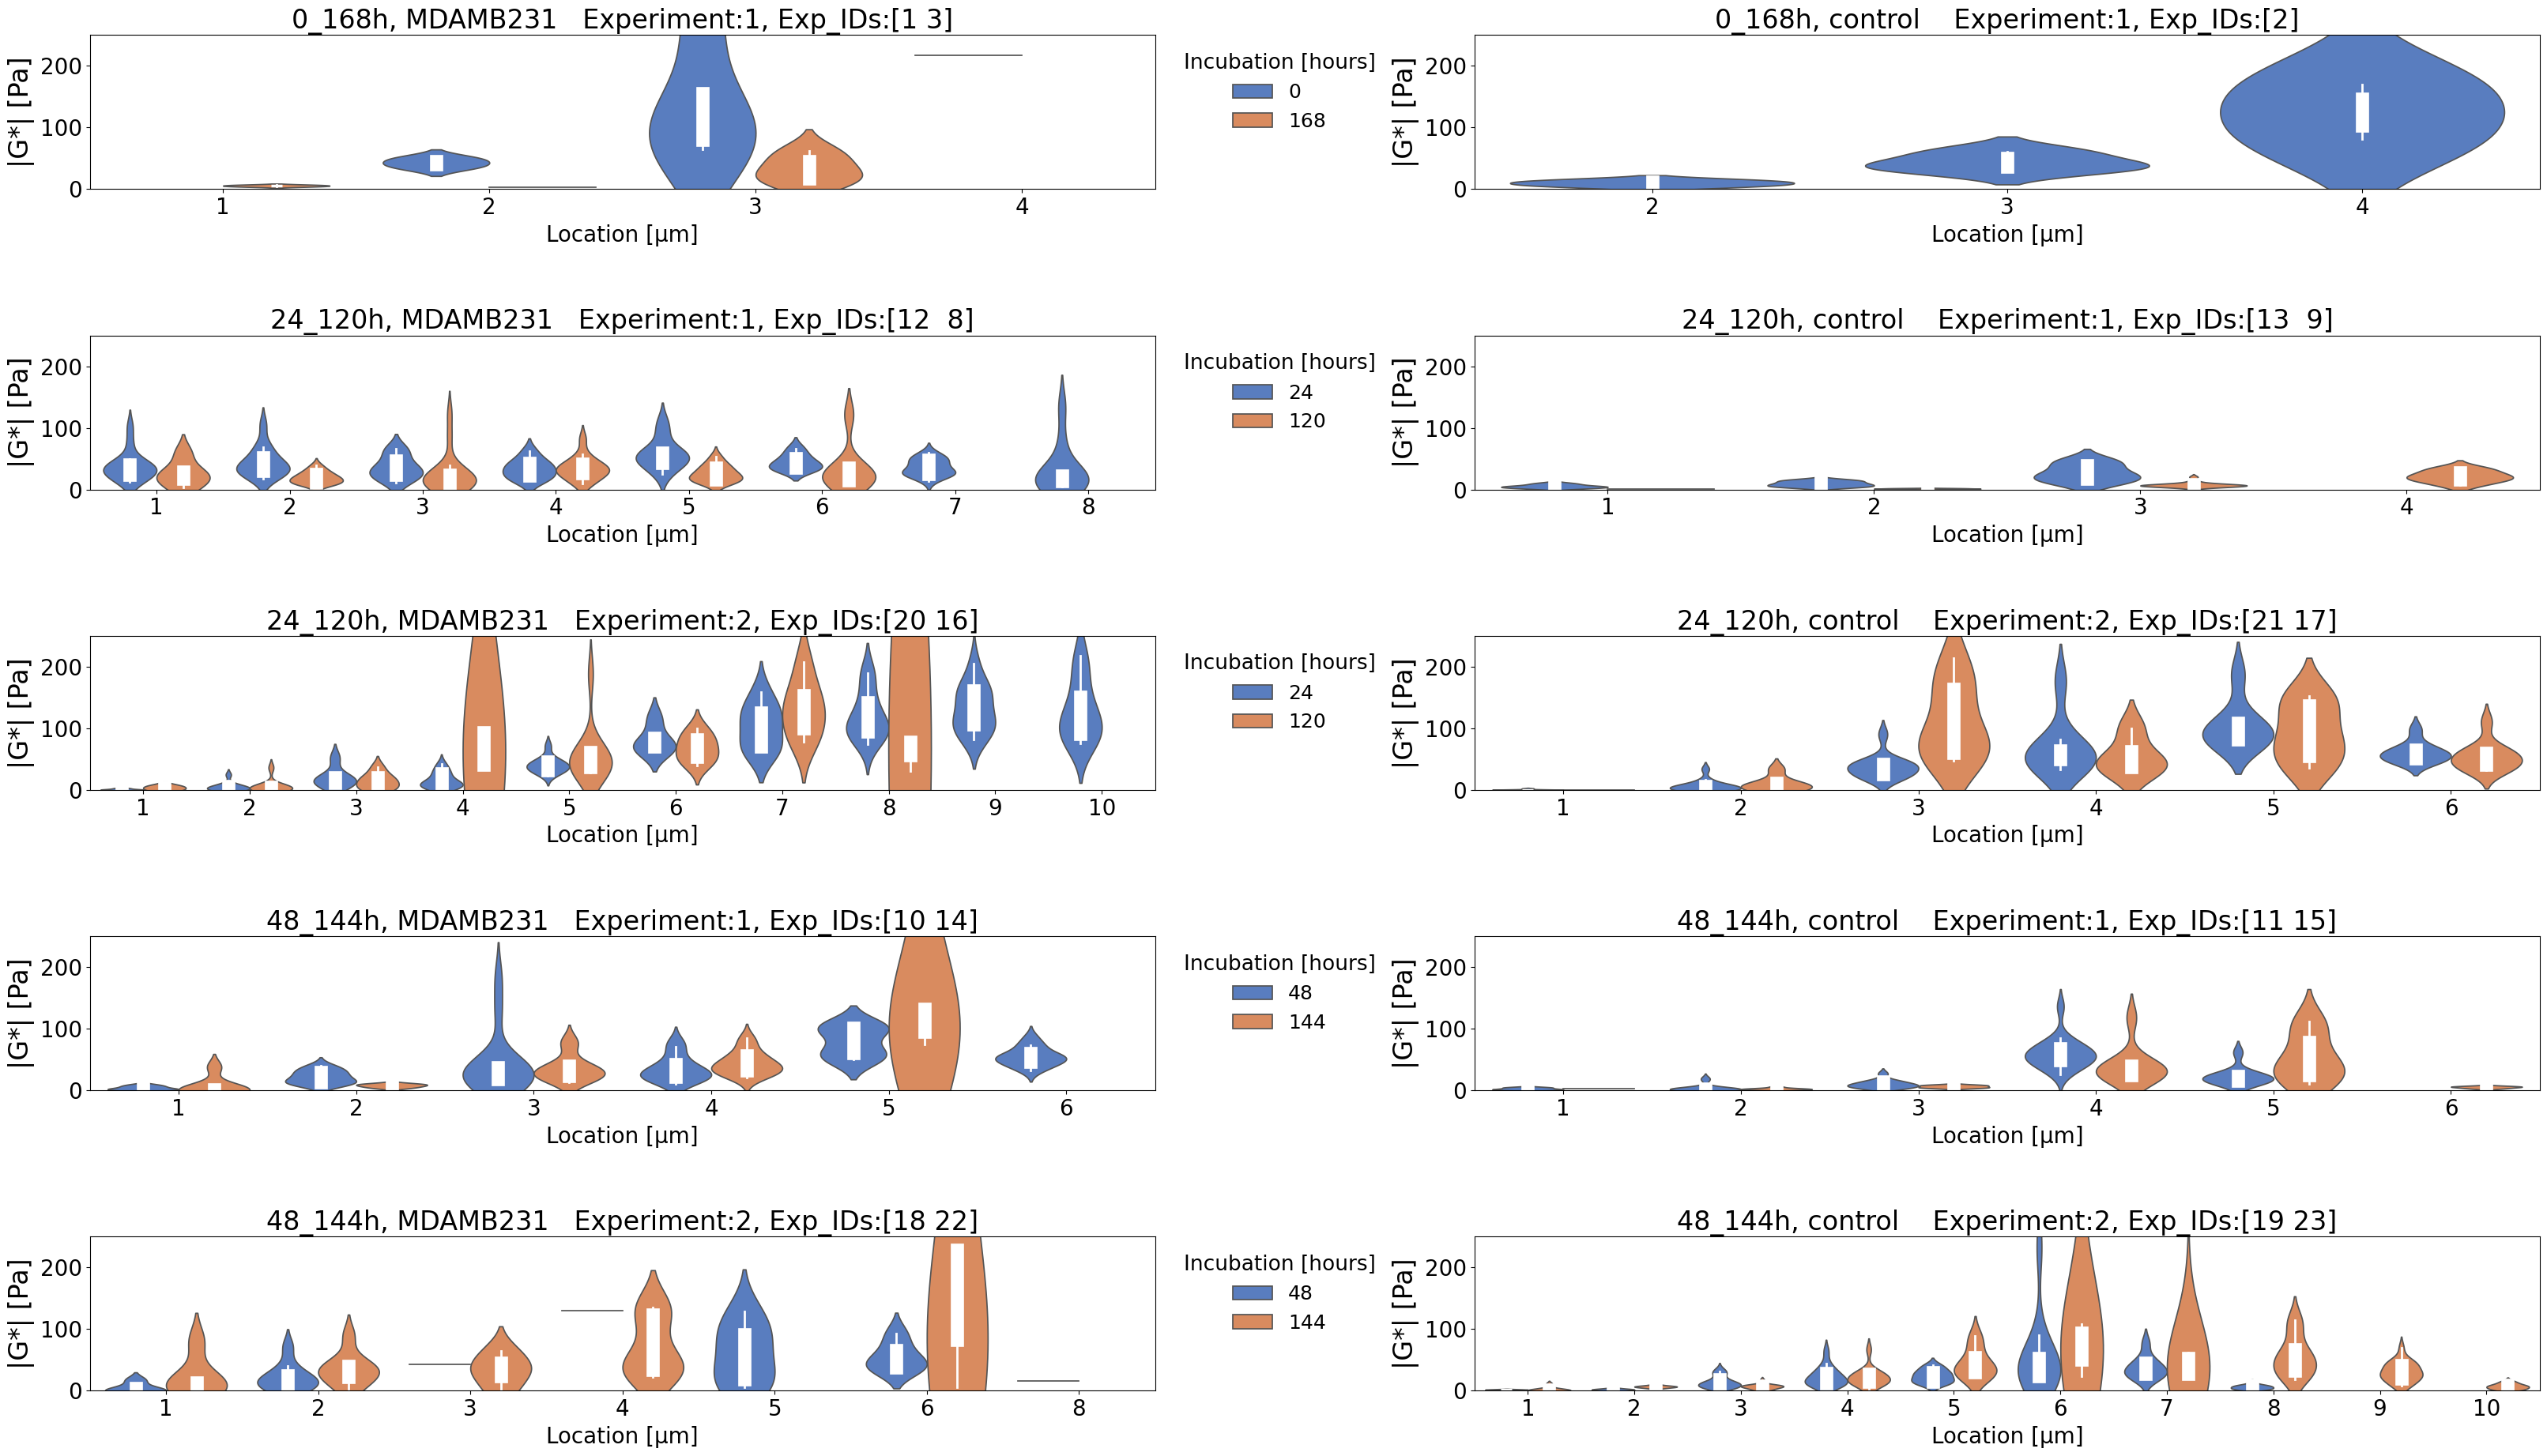

In [31]:
fig, axs = plt.subplots(5, 2, figsize=(40, 22))
plt.subplots_adjust(wspace=0.3, hspace=0.95, bottom=0.1)  # Adjust bottom to make space for the legend
# fig.suptitle("Remodelling UV=50s ", fontsize=22)

# Define marker and color settings (if needed)
markers = ['x', 's']
colors = ("muted",2)

def plotting(group_data,i,experiment,incubation_set):
    
    ax = axs[i, 0]
    group_data_control, x_cell_data = [],[]
    group_data_cell = group_data[group_data['cell/control']=='MDAMB231']
    exp_ids_cell = group_data_cell['experiment_id'].unique()

    if (group_data_cell['gradient_direction'] == 'stiff_to_soft').all():x_cell_data = group_data_cell['location_inverse']
    else: x_cell_data = group_data_cell['location']
    
    sns.violinplot(x=x_cell_data, y='G_abs', data=group_data_cell,
                    inner='box', width=0.8, density_norm='width', ax=ax, legend=True, hue='incubation',
                    inner_kws=dict(box_width=12, whis_width=2, color="1"),palette="muted",)
    ax.set_xlabel("Location [µm]", fontsize=20, labelpad=5)
    ax.set_ylabel("|G*| [Pa]", fontsize=24, labelpad=5)
    ax.set_title(f"{incubation_set}h, MDAMB231   Experiment:{experiment+1}, Exp_IDs:{exp_ids_cell}", fontsize=24)
    ax.tick_params(axis='both', labelsize=20)
    ax.set_ylim(0, 250) 


    legend = ax.legend(title="Incubation [hours]", fontsize=18, title_fontsize=19, loc='upper left', bbox_to_anchor=(1.01, 1), frameon=False)


    ax1 = axs[i, 1]
    group_data_control, x_ctr_data = [],[]
    group_data_control = group_data[group_data['cell/control']=='control']
    exp_ids_ctr = group_data_control['experiment_id'].unique()

    if (group_data_control['gradient_direction'] == 'stiff_to_soft').all():x_ctr_data = group_data_control['location_inverse']
    else: x_ctr_data = group_data_control['location']
    sns.violinplot(x=x_ctr_data, y='G_abs', data=group_data_control,
                   inner='box', width=0.8, density_norm='width', ax=ax1, legend=False, hue='incubation',
                   inner_kws=dict(box_width=12, whis_width=2, color="1"),palette="muted",)
    ax1.set_xlabel("Location [µm]", fontsize=20, labelpad=5)
    ax1.set_ylabel("|G*| [Pa]", fontsize=24, labelpad=5)
    ax1.set_title(f"{incubation_set}h, control    Experiment:{experiment+1}, Exp_IDs:{exp_ids_ctr}", fontsize=24)
    ax1.tick_params(axis='both', labelsize=20)
    ax1.set_ylim(0, 250) 



for i, ((incubation_set,experiment), group_data) in enumerate(download.groupby(['incubation_set','experiment'])):
    plotting(group_data,i,experiment,incubation_set)


# Adjust layout and display the plot
plt.show()


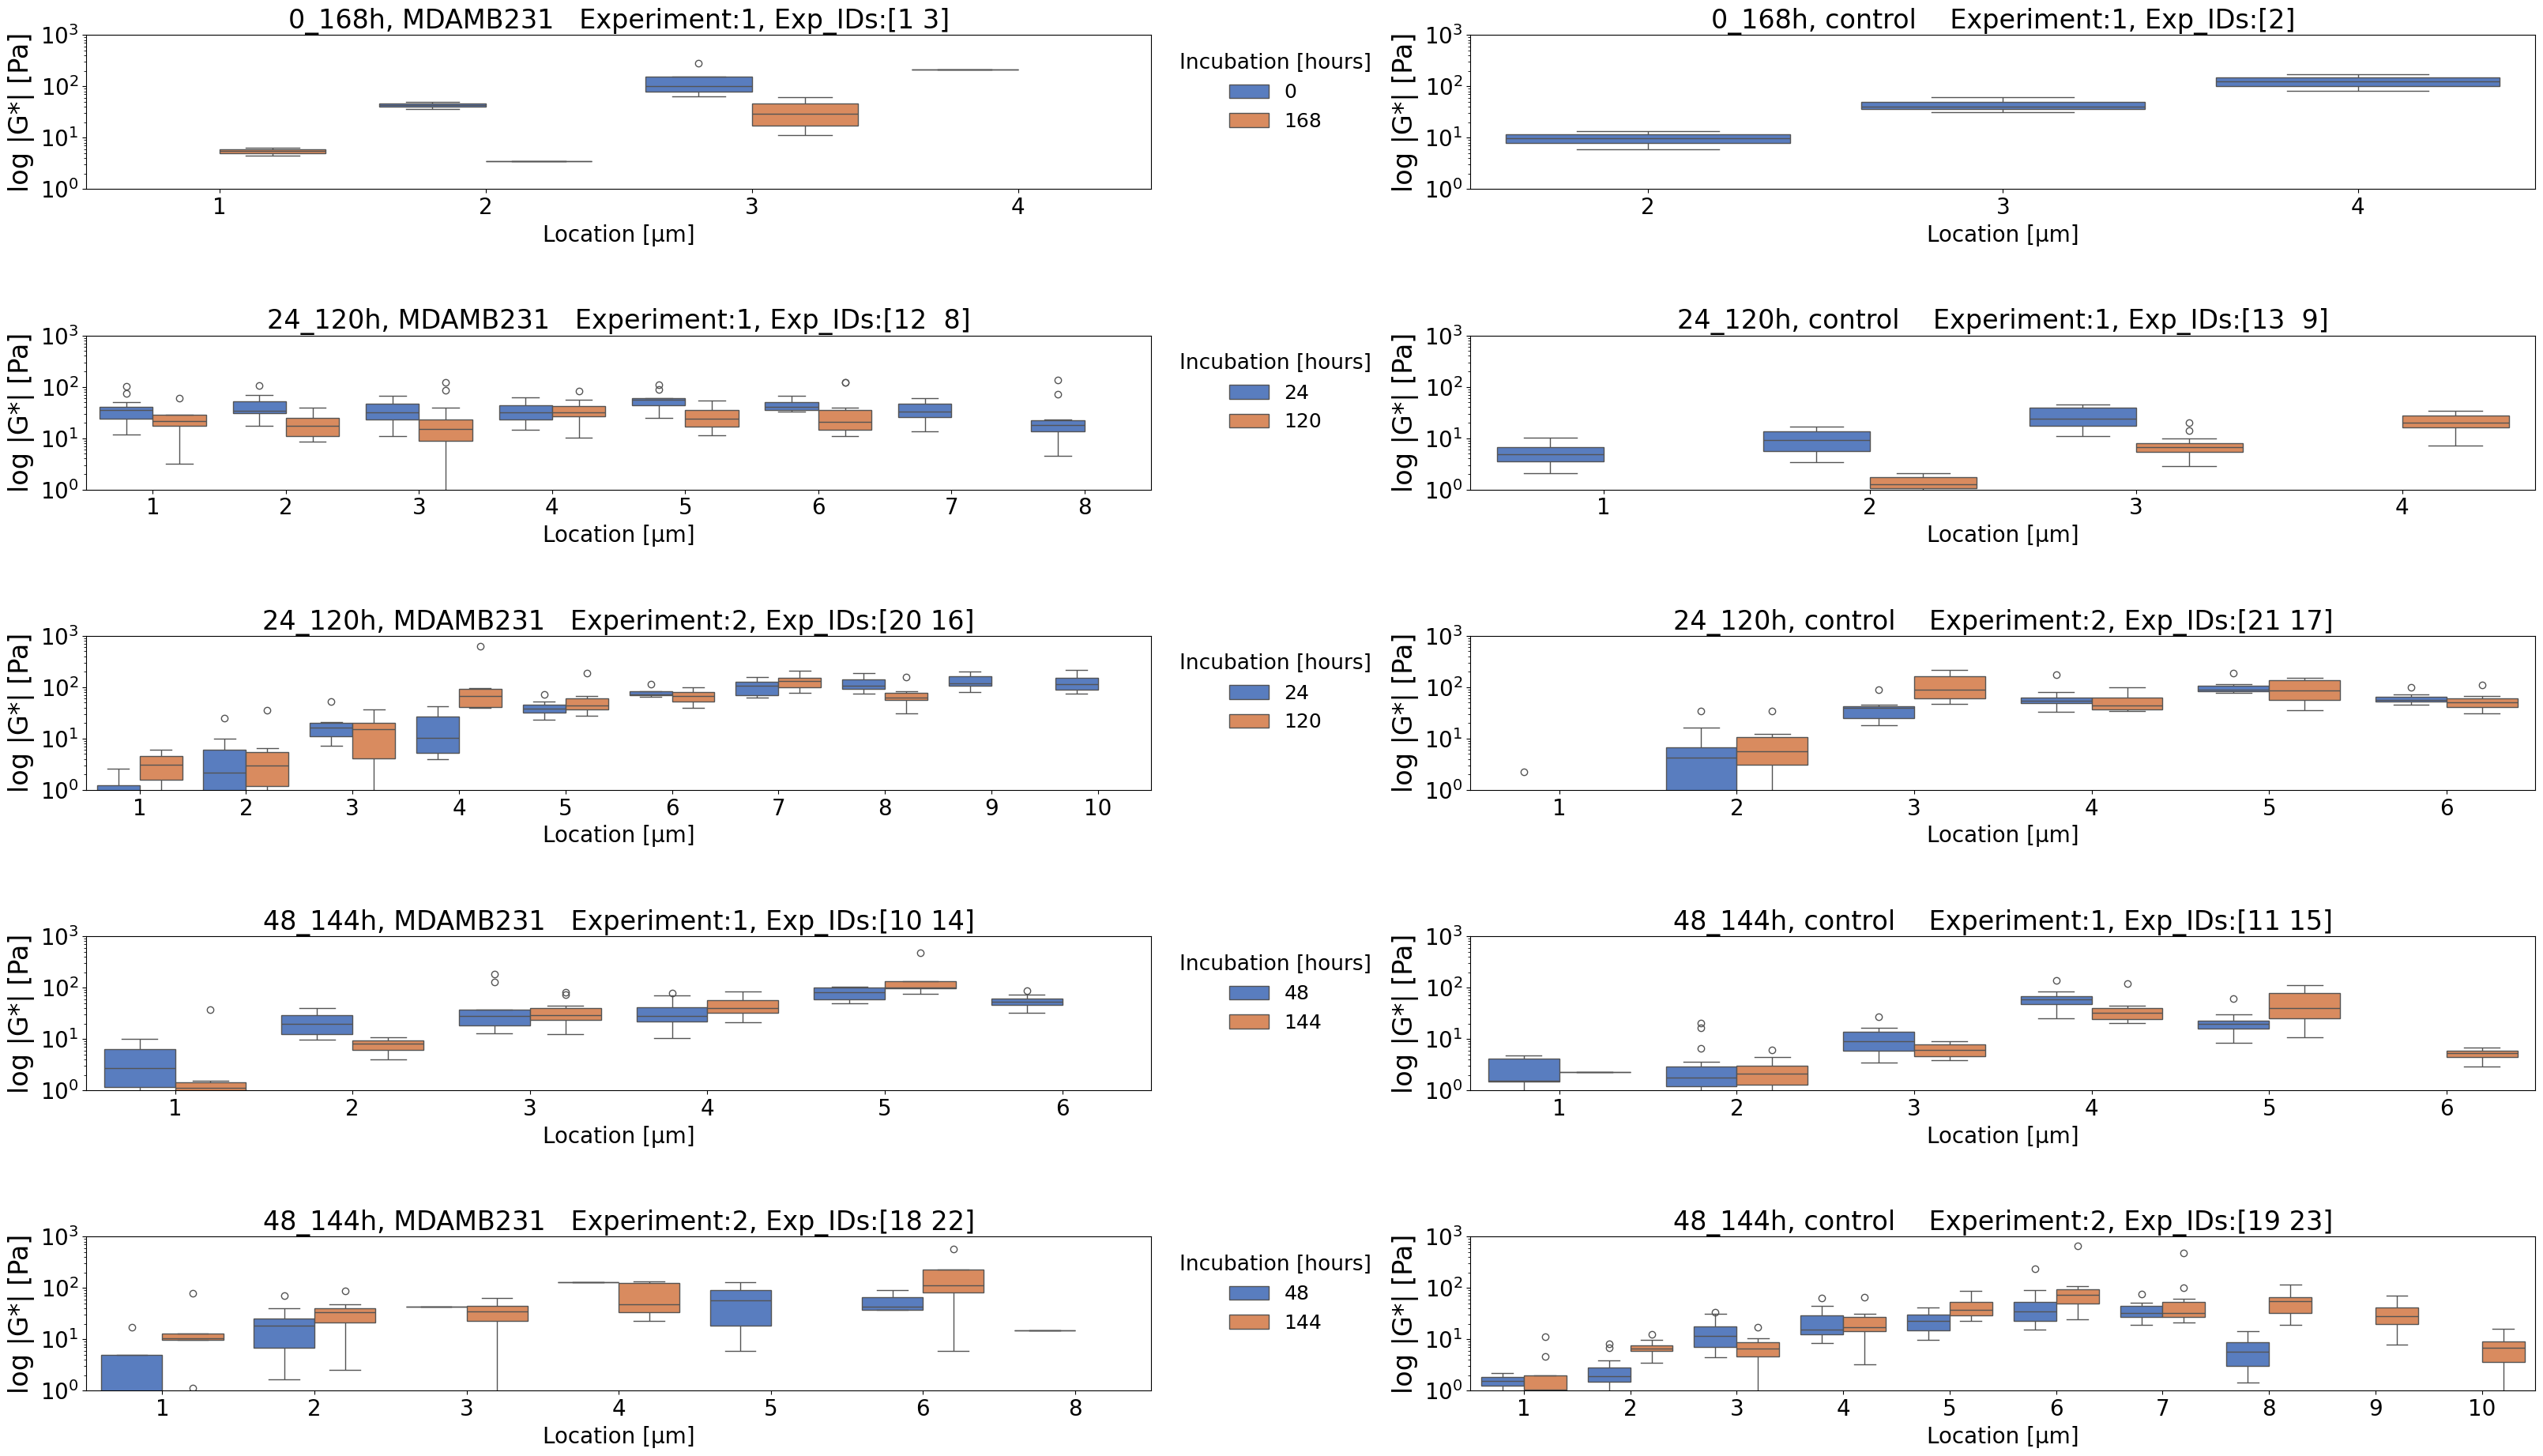

In [36]:
fig, axs = plt.subplots(5, 2, figsize=(40, 22))
plt.subplots_adjust(wspace=0.3, hspace=0.95, bottom=0.1)  # Adjust bottom to make space for the legend
# fig.suptitle("Remodelling UV=50s ", fontsize=22)

# Define marker and color settings (if needed)
markers = ['x', 's']
colors = ("muted",2)

def plotting(group_data,i,experiment,incubation_set):
    
    ax = axs[i, 0]
    group_data_control, x_cell_data = [],[]
    group_data_cell = group_data[group_data['cell/control']=='MDAMB231']
    exp_ids_cell = group_data_cell['experiment_id'].unique()
    if (group_data_cell['gradient_direction'] == 'stiff_to_soft').all():x_cell_data = group_data_cell['location_inverse']
    else: x_cell_data = group_data_cell['location']
    
    sns.boxplot(x=x_cell_data, y='G_abs', data=group_data_cell,
                    width=0.8, ax=ax, legend=True, hue='incubation',palette="muted",)
    ax.set_xlabel("Location [µm]", fontsize=20, labelpad=5)
    ax.set_ylabel("log |G*| [Pa]", fontsize=24, labelpad=5)
    ax.set_title(f"{incubation_set}h, MDAMB231   Experiment:{experiment+1}, Exp_IDs:{exp_ids_cell}", fontsize=24)
    ax.tick_params(axis='both', labelsize=20)
    ax.set_yscale('log')
    ax.set_ylim(1, 1000) 


    legend = ax.legend(title="Incubation [hours]", fontsize=18, title_fontsize=19, loc='upper left', bbox_to_anchor=(1.01, 1), frameon=False)


    ax1 = axs[i, 1]
    group_data_control, x_ctr_data = [],[]
    group_data_control = group_data[group_data['cell/control']=='control']
    exp_ids_ctr = group_data_control['experiment_id'].unique()
    if (group_data_control['gradient_direction'] == 'stiff_to_soft').all():x_ctr_data = group_data_control['location_inverse']
    else: x_ctr_data = group_data_control['location']
    sns.boxplot(x=x_ctr_data, y='G_abs', data=group_data_control,
                  ax=ax1, legend=False, hue='incubation',
                   palette="muted",)
    ax1.set_xlabel("Location [µm]", fontsize=20, labelpad=5)
    ax1.set_ylabel("log |G*| [Pa]", fontsize=24, labelpad=5)
    ax1.set_title(f"{incubation_set}h, control    Experiment:{experiment+1}, Exp_IDs:{exp_ids_ctr}", fontsize=24)
    ax1.tick_params(axis='both', labelsize=20)
    ax1.set_ylim(1, 1000) 
    ax1.set_yscale('log')


for i, ((incubation_set,experiment), group_data) in enumerate(download.groupby(['incubation_set','experiment'])):
    plotting(group_data,i,experiment,incubation_set)


# Adjust layout and display the plot
plt.show()


Time-series G*

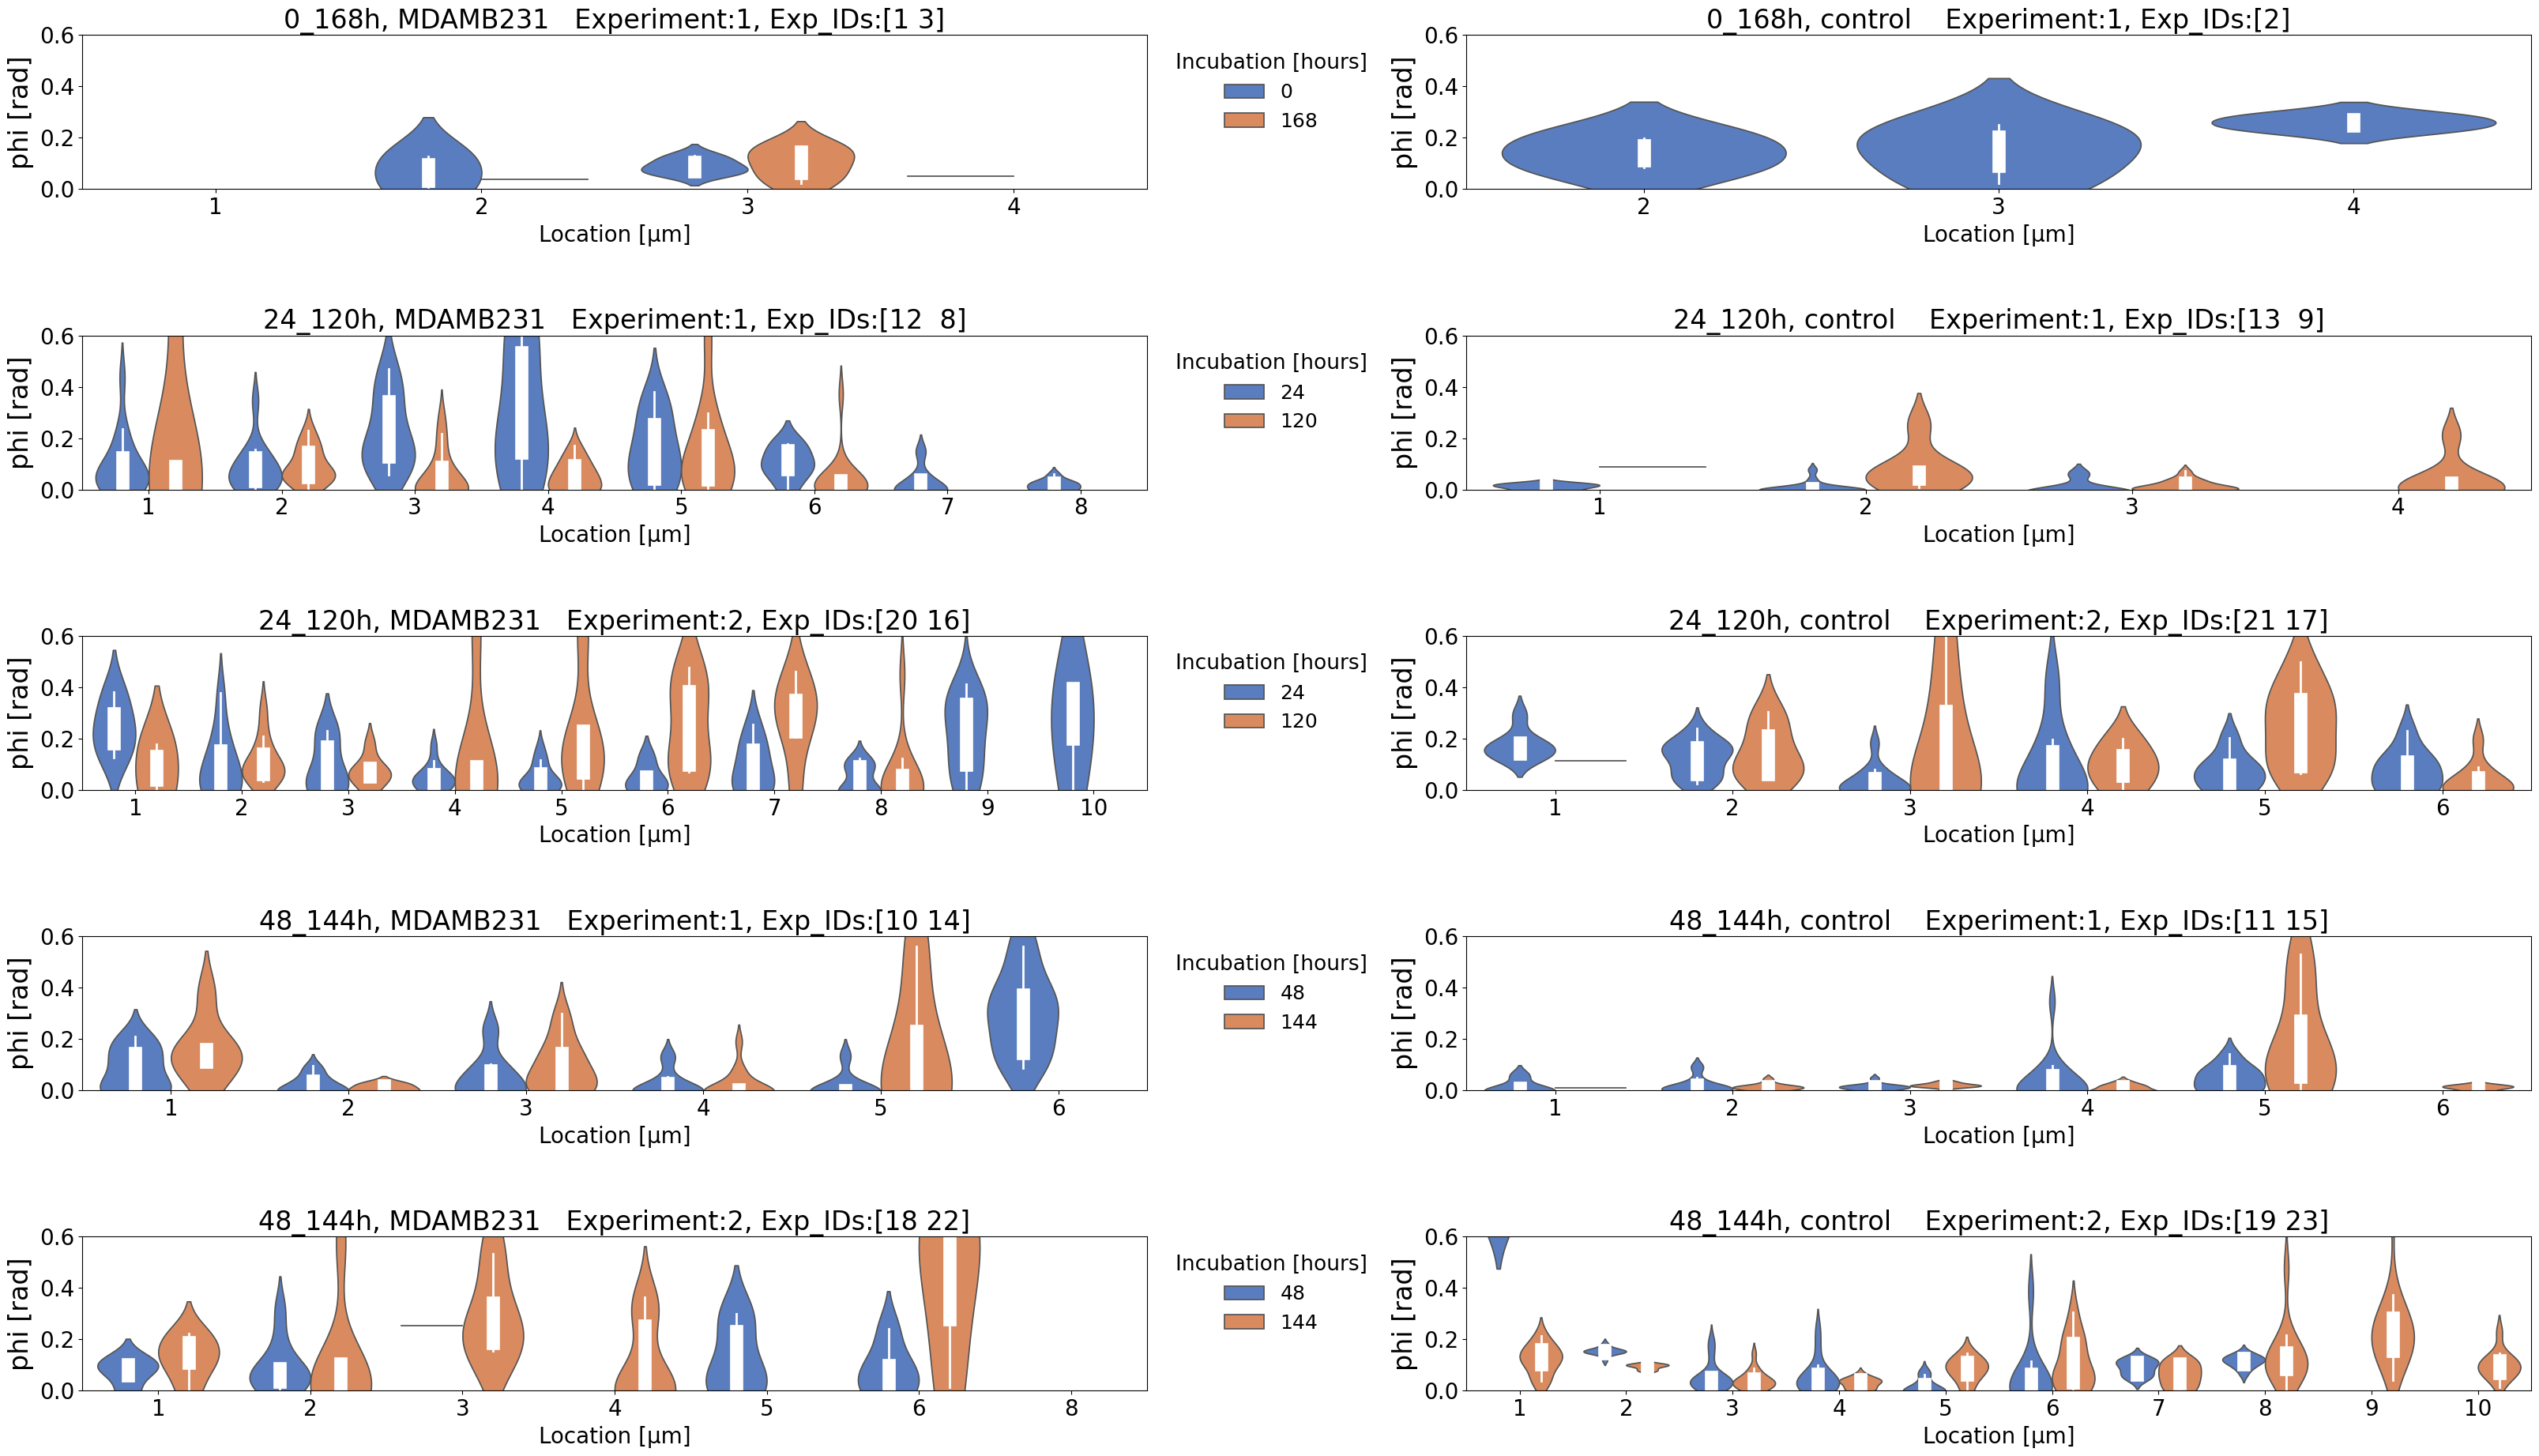

In [35]:
fig, axs = plt.subplots(5, 2, figsize=(40, 22))
plt.subplots_adjust(wspace=0.3, hspace=0.95, bottom=0.1) # Adjust bottom to make space for the legend
# fig.suptitle("Remodelling UV=50s ", fontsize=22)

# Define marker and color settings (if needed)
markers = ['x', 's']
colors = ["lightblue", "darkblue"]

def plotting(group_data,i,experiment,incubation_set):
    
    ax = axs[i, 0]
    group_data_control, x_cell_data = [],[]
    group_data_cell = group_data[group_data['cell/control']=='MDAMB231']
    exp_ids_cell = group_data_cell['experiment_id'].unique()

    if (group_data_cell['gradient_direction'] == 'stiff_to_soft').all():x_cell_data = group_data_cell['location_inverse']
    else: x_cell_data = group_data_cell['location']
    
    sns.violinplot(x=x_cell_data, y='phi_(rad)', data=group_data_cell,
                    inner='box', width=0.8, density_norm='width', ax=ax, legend=True, hue='incubation',
                    inner_kws=dict(box_width=12, whis_width=2, color="1"),palette="muted",)
    ax.set_xlabel("Location [µm]", fontsize=20, labelpad=5)
    ax.set_ylabel("phi [rad]", fontsize=24, labelpad=5)
    ax.set_title(f"{incubation_set}h, MDAMB231   Experiment:{experiment+1}, Exp_IDs:{exp_ids_cell}", fontsize=24)
    ax.tick_params(axis='both', labelsize=20)
    ax.set_ylim(0, 0.6) 
    legend = ax.legend(title="Incubation [hours]", fontsize=18, title_fontsize=19, loc='upper left', bbox_to_anchor=(1.01, 1), frameon=False)


    ax1 = axs[i, 1]
    group_data_control, x_ctr_data = [],[]
    group_data_control = group_data[group_data['cell/control']=='control']
    exp_ids_ctr = group_data_control['experiment_id'].unique()
    if (group_data_control['gradient_direction'] == 'stiff_to_soft').all():x_ctr_data = group_data_control['location_inverse']
    else: x_ctr_data = group_data_control['location']
    sns.violinplot(x=x_ctr_data, y='phi_(rad)', data=group_data_control,
                   inner='box', width=0.8, density_norm='width', ax=ax1, legend=False, hue='incubation',
                   inner_kws=dict(box_width=12, whis_width=2, color="1"),palette="muted",)
    ax1.set_xlabel("Location [µm]", fontsize=20, labelpad=5)
    ax1.set_ylabel("phi [rad]", fontsize=24, labelpad=5)
    ax1.set_title(f"{incubation_set}h, control    Experiment:{experiment+1}, Exp_IDs:{exp_ids_ctr}", fontsize=24)
    ax1.tick_params(axis='both', labelsize=20)
    ax1.set_ylim(0, 0.6) 


for i, ((incubation_set,experiment), group_data) in enumerate(download.groupby(['incubation_set','experiment'])):
    plotting(group_data,i,experiment,incubation_set)


# Adjust layout and display the plot
plt.show()


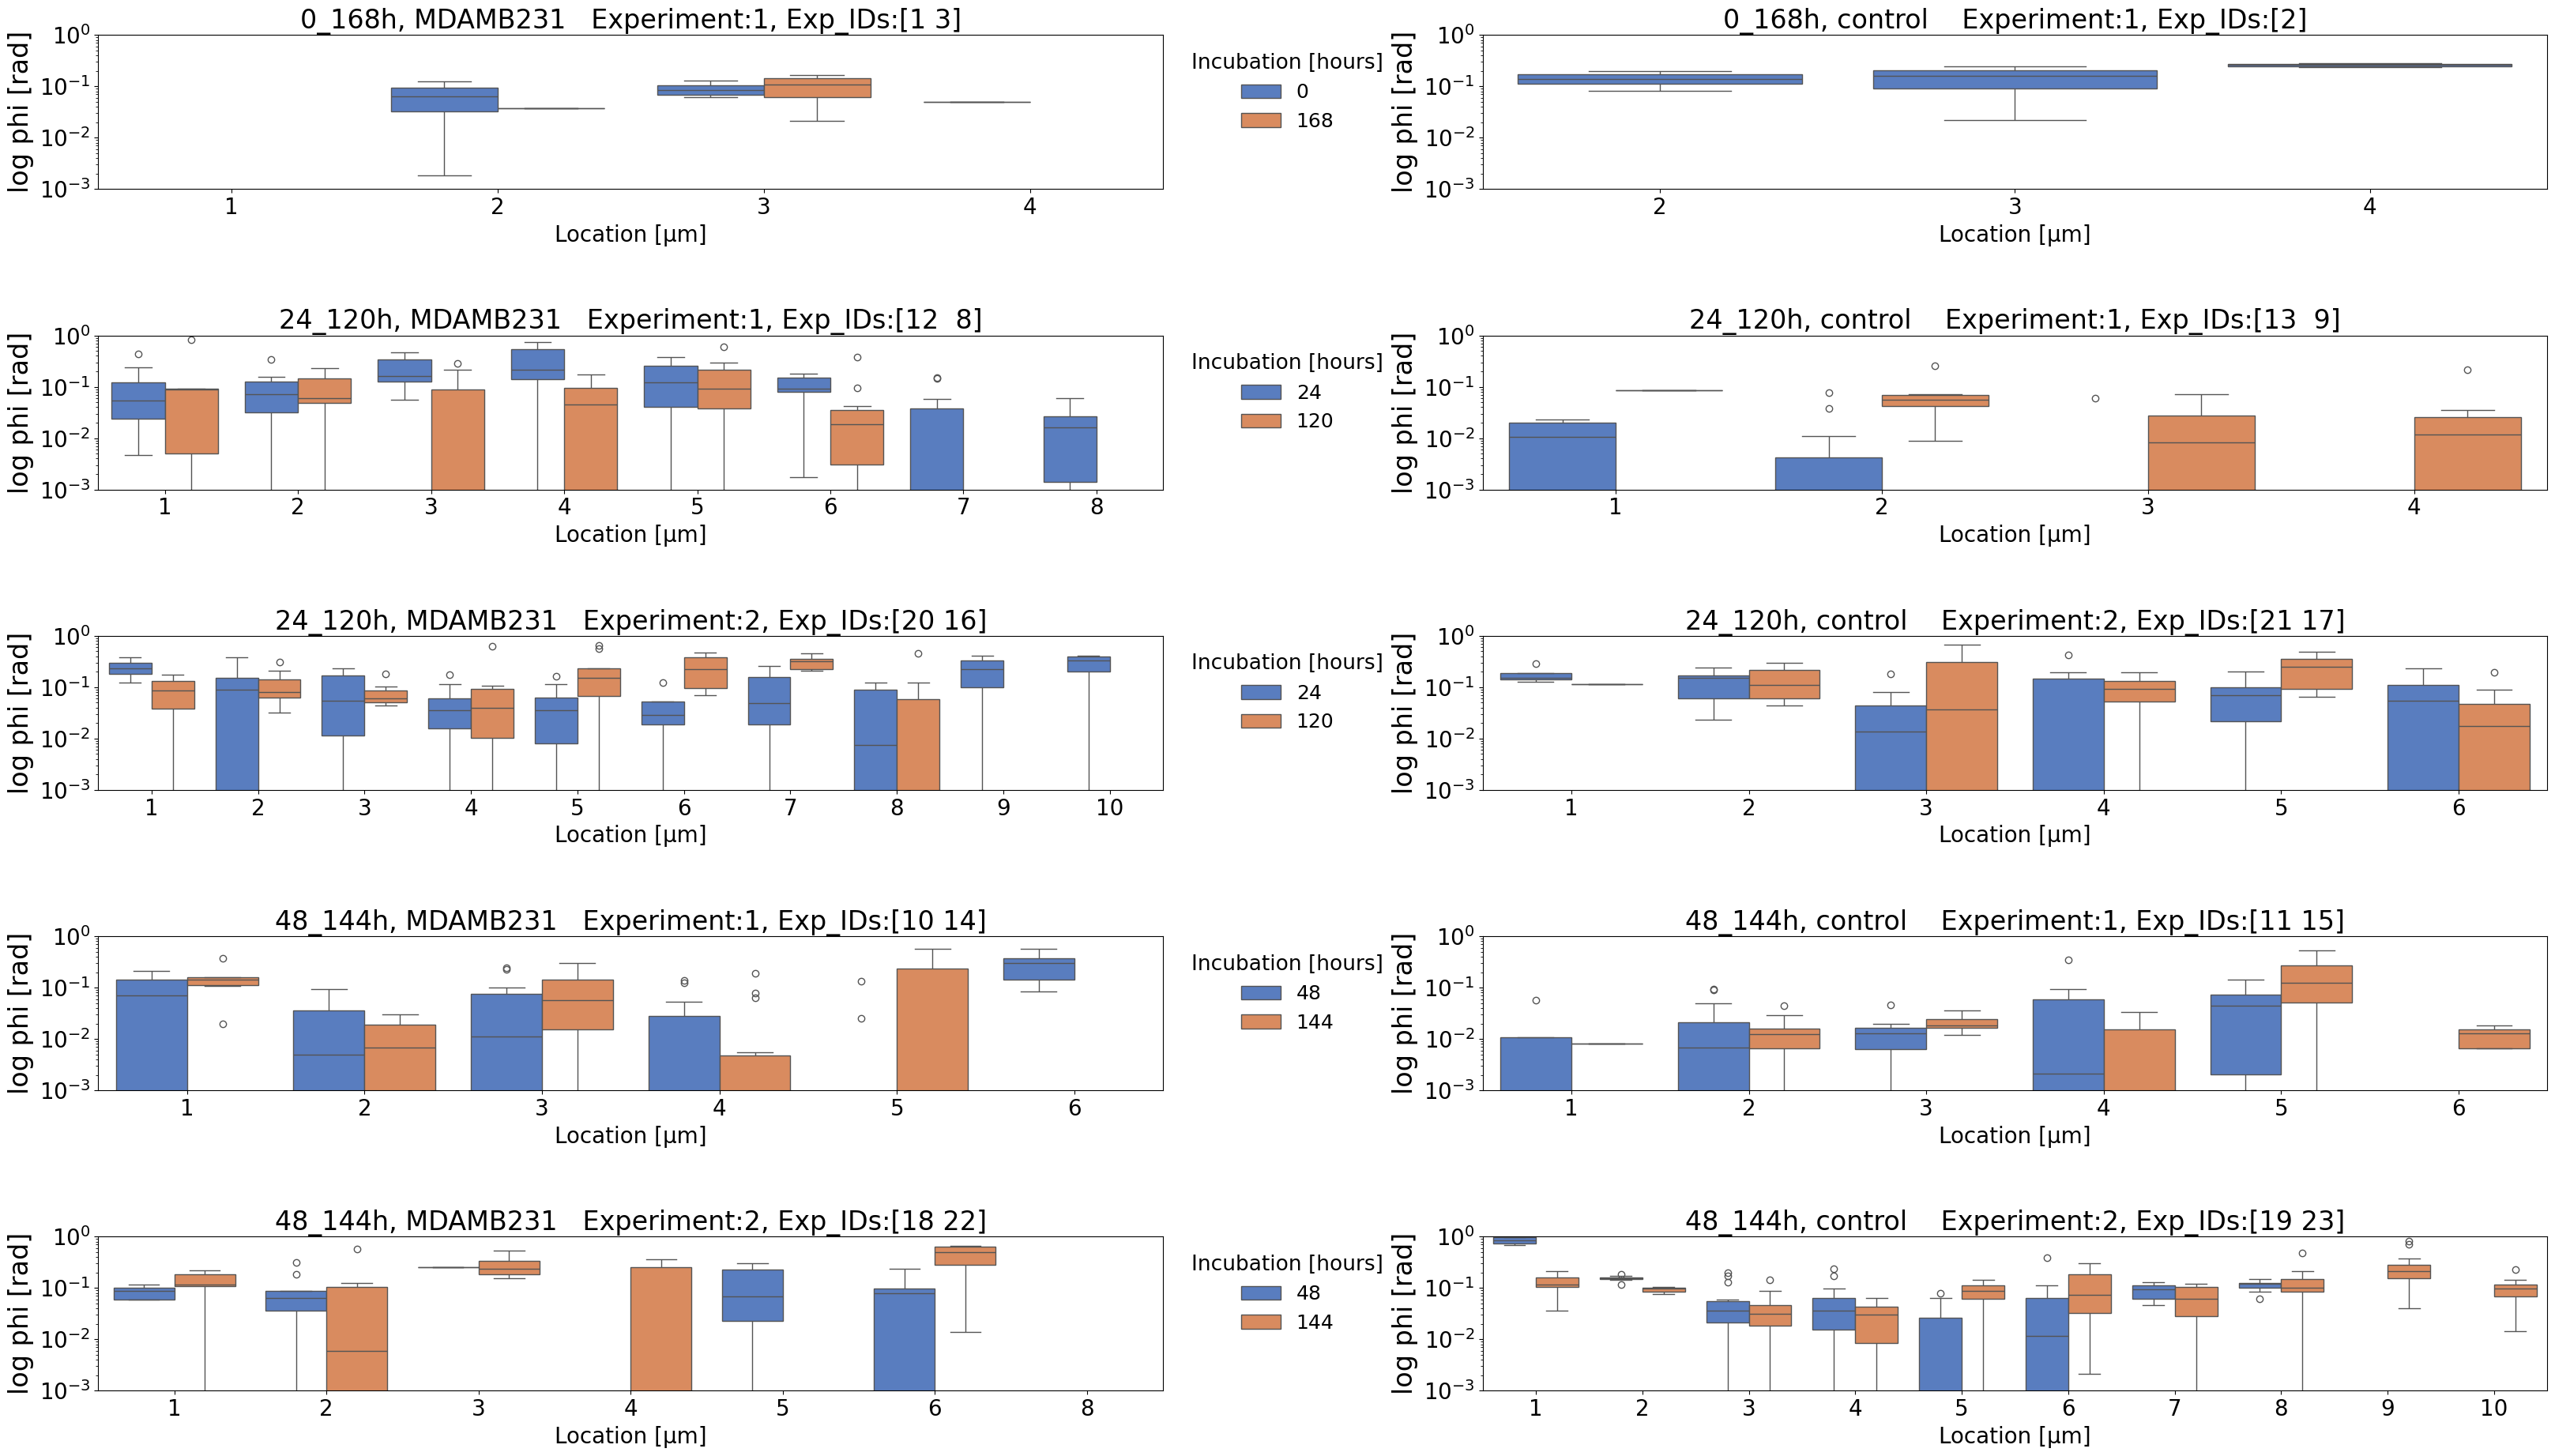

In [ ]:
fig, axs = plt.subplots(5, 2, figsize=(40, 22))
plt.subplots_adjust(wspace=0.3, hspace=0.95, bottom=0.1) # Adjust bottom to make space for the legend
# fig.suptitle("Remodelling UV=50s ", fontsize=22)

# Define marker and color settings (if needed)
markers = ['x', 's']
colors = ["lightblue", "darkblue"]

def plotting(group_data,i,experiment,incubation_set):
    
    ax = axs[i, 0]
    group_data_control, x_cell_data = [],[]
    group_data_cell = group_data[group_data['cell/control']=='MDAMB231']
    exp_ids_cell = group_data_cell['experiment_id'].unique()

    if (group_data_cell['gradient_direction'] == 'stiff_to_soft').all():x_cell_data = group_data_cell['location_inverse']
    else: x_cell_data = group_data_cell['location']
    
    sns.boxplot(x=x_cell_data, y='phi_(rad)', data=group_data_cell,
                    width=0.8, ax=ax, legend=True, hue='incubation',
                    palette="muted",)
    ax.set_xlabel("Location [µm]", fontsize=20, labelpad=5)
    ax.set_ylabel("log phi [rad]", fontsize=24, labelpad=5)
    ax.set_title(f"{incubation_set}h, MDAMB231   Experiment:{experiment+1}, Exp_IDs:{exp_ids_cell}", fontsize=24)
    ax.tick_params(axis='both', labelsize=20)
    ax.set_ylim(0.001, 1)
    ax.set_yscale('log')
    legend = ax.legend(title="Incubation [hours]", fontsize=18, title_fontsize=19, loc='upper left', bbox_to_anchor=(1.01, 1), frameon=False)


    ax1 = axs[i, 1]
    group_data_control, x_ctr_data = [],[]
    group_data_control = group_data[group_data['cell/control']=='control']
    exp_ids_ctr = group_data_control['experiment_id'].unique()
    if (group_data_control['gradient_direction'] == 'stiff_to_soft').all():x_ctr_data = group_data_control['location_inverse']
    else: x_ctr_data = group_data_control['location']
    sns.boxplot(x=x_ctr_data, y='phi_(rad)', data=group_data_control,
                   width=0.8, ax=ax1, legend=False, hue='incubation',
                  palette="muted",)
    ax1.set_xlabel("Location [µm]", fontsize=20, labelpad=5)
    ax1.set_ylabel("log phi [rad]", fontsize=24, labelpad=5)
    ax1.set_title(f"{incubation_set}h, control    Experiment:{experiment+1}, Exp_IDs:{exp_ids_ctr}", fontsize=24)
    ax1.tick_params(axis='both', labelsize=20)
    ax1.set_ylim(0.001, 1)
    ax1.set_yscale('log')


for i, ((incubation_set,experiment), group_data) in enumerate(download.groupby(['incubation_set','experiment'])):
    plotting(group_data,i,experiment,incubation_set)


# Adjust layout and display the plot
plt.show()


Plotting CLOSBY

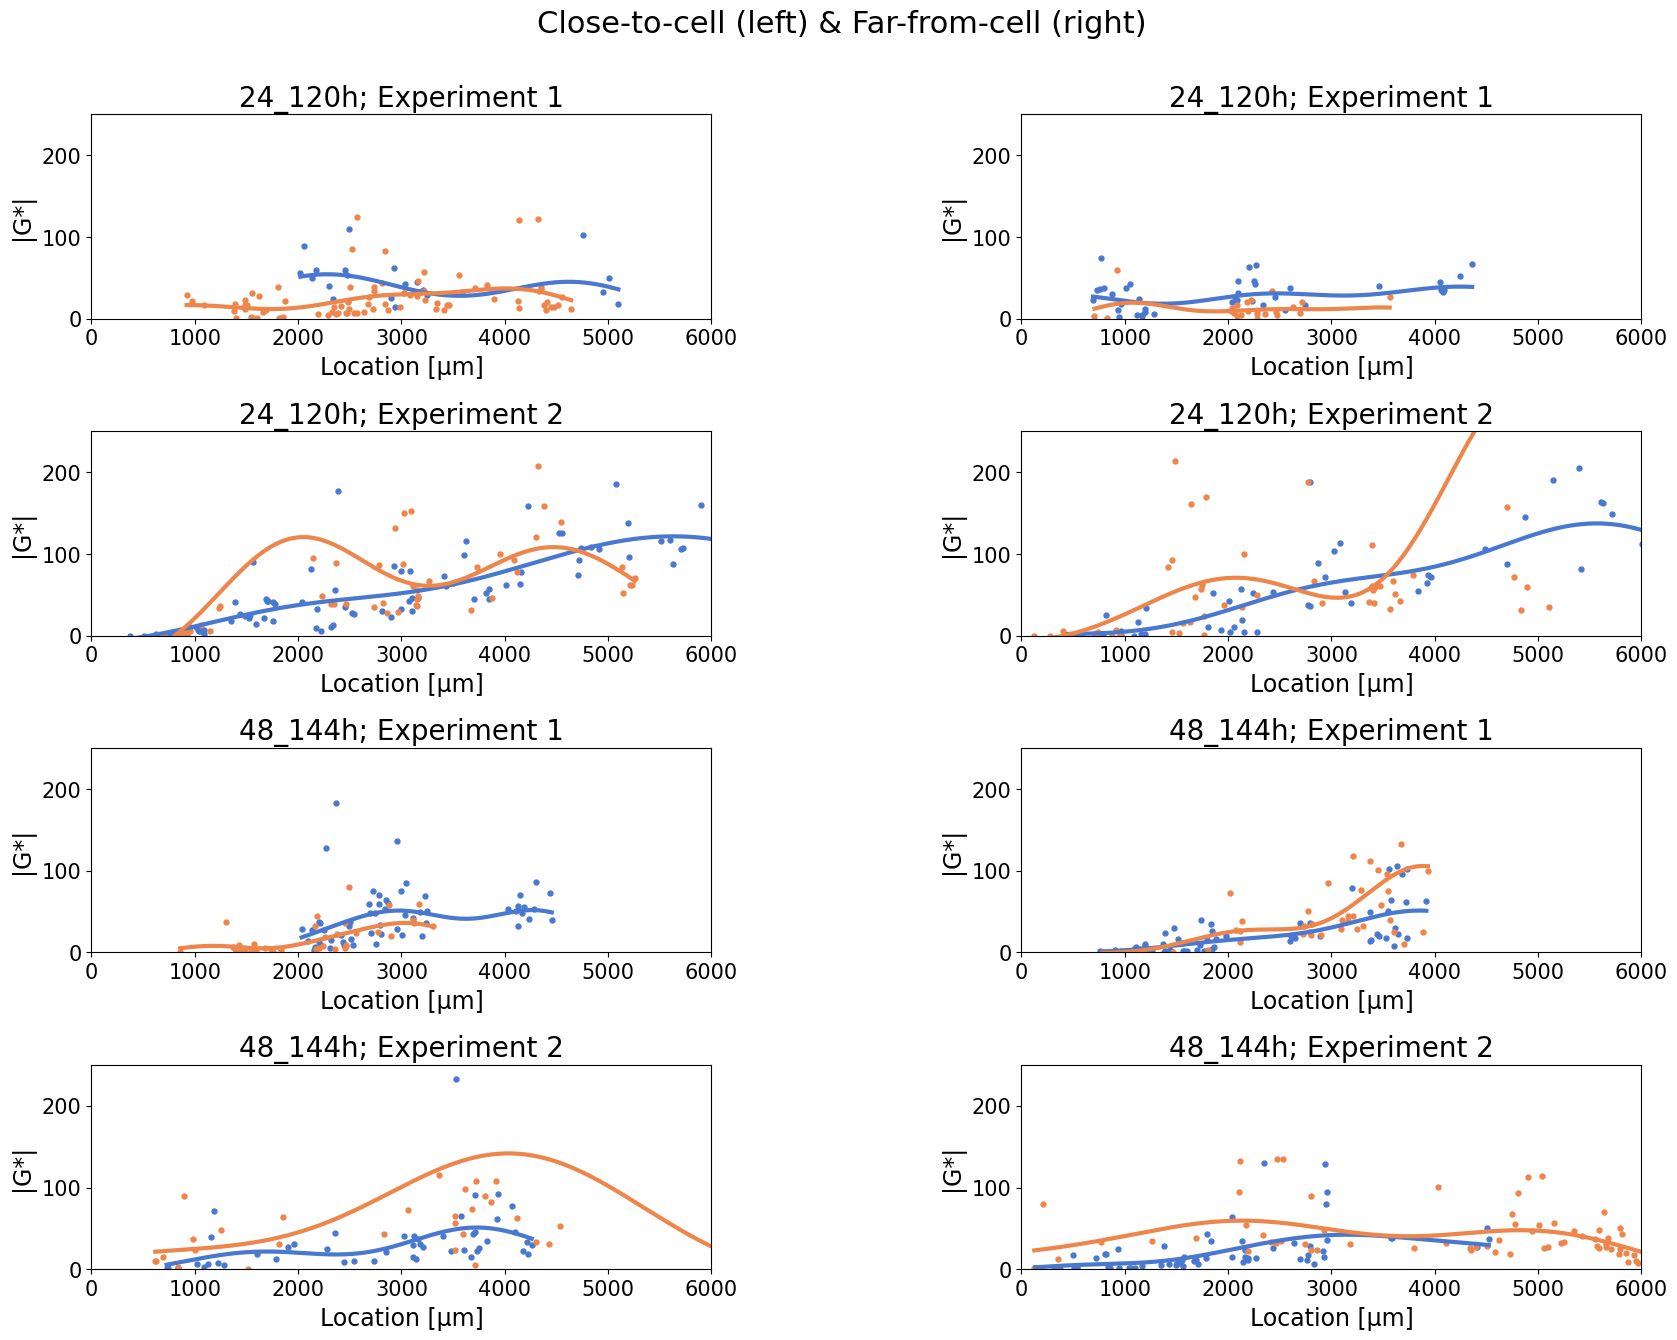

In [39]:
fig, axs = plt.subplots(4, 2, figsize=(20, 15))  # 4 rows and 2 columns
plt.subplots_adjust(wspace=0.5, hspace=0.55)
fig.suptitle("Close-to-cell (left) & Far-from-cell (right)", fontsize=22, y=0.95)

markers = ['x', 's']
colors = sns.color_palette("muted",2)

def plot_data(data, col, start_index=0):
    for i, j in enumerate(data['incubation_set'].unique()):
        first = data[data['incubation_set'] == j]

        for nn, n in enumerate(first['incubation'].unique()):
            second = first[first['incubation'] == n]
            color_type = colors[int(nn)]

            for k, l in enumerate(second['experiment'].unique()):
                third = second[second['experiment'] == l]
                marker_type = markers[int(l)]

                for m, o in enumerate(third['sample'].unique()):
                    fourth = third[third['sample'] == o]
                    date_value = str(fourth['day'].unique()[0])

                    # Calculate row and column for axs grid
                    row = start_index + (i * 2) + k  # Adjust row index for more subplots
                    col = col # Alternate between the two columns

                    ax = axs[row, col]
                    # Adjust for the gradient direction
                    if (fourth['gradient_direction'] == 'stiff_to_soft').all():
                        fitting_kernel(fourth['gradient_inverse'], fourth['G_abs'], ax, 1, color_type, '.')
                    else:
                        fitting_kernel(fourth['gradient'], fourth['G_abs'], ax, 1, color_type, '.')

                    ax.set_xlabel("Location [µm]", fontsize=17, labelpad=5)
                    ax.set_ylabel("|G*|", fontsize=17, labelpad=5)
                    ax.set_title(f"{j}h; Experiment {k+1}", fontsize=20)
                    ax.tick_params(axis='both', labelsize=15)
                    ax.set_ylim(0, 250)
                    ax.set_xlim(0, 6000)

plot_data(download_closeby, 0)
plot_data(download_faraway, 1)


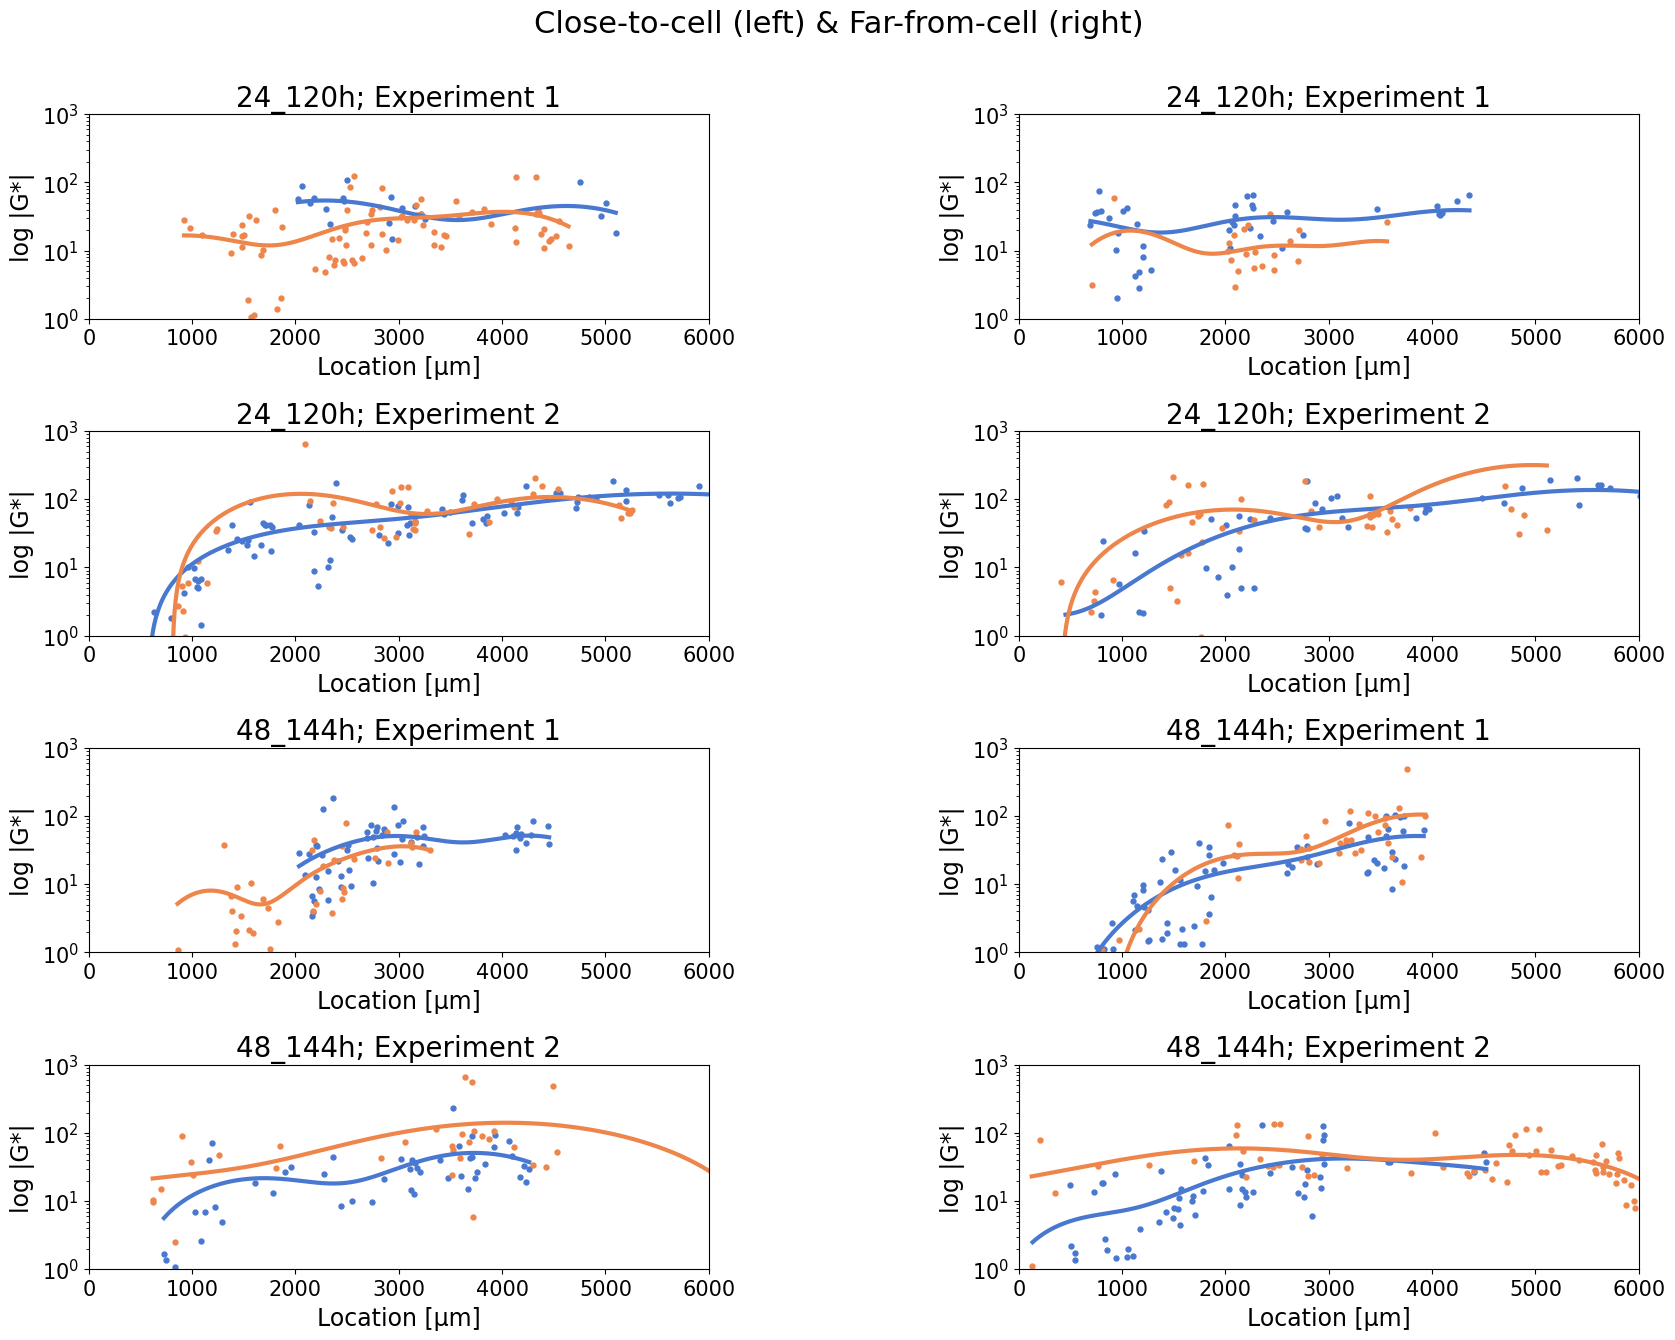

In [40]:
fig, axs = plt.subplots(4, 2, figsize=(20, 15))  # 4 rows and 2 columns
plt.subplots_adjust(wspace=0.5, hspace=0.55)
fig.suptitle("Close-to-cell (left) & Far-from-cell (right)", fontsize=22, y=0.95)

markers = ['x', 's']
colors = sns.color_palette("muted",2)

def plot_data(data, col, start_index=0):
    for i, j in enumerate(data['incubation_set'].unique()):
        first = data[data['incubation_set'] == j]

        for nn, n in enumerate(first['incubation'].unique()):
            second = first[first['incubation'] == n]
            color_type = colors[int(nn)]

            for k, l in enumerate(second['experiment'].unique()):
                third = second[second['experiment'] == l]
                marker_type = markers[int(l)]

                for m, o in enumerate(third['sample'].unique()):
                    fourth = third[third['sample'] == o]
                    date_value = str(fourth['day'].unique()[0])
                    
                    # Calculate row and column for axs grid
                    row = start_index + (i * 2) + k  # Adjust row index for more subplots
                    col = col # Alternate between the two columns

                    ax = axs[row, col]
                    # Adjust for the gradient direction
                    if (fourth['gradient_direction'] == 'stiff_to_soft').all():
                        fitting_kernel(fourth['gradient_inverse'], fourth['G_abs'], ax, 1, color_type, '.')
                    else:
                        fitting_kernel(fourth['gradient'], fourth['G_abs'], ax, 1, color_type, '.')

                    ax.set_xlabel("Location [µm]", fontsize=17, labelpad=5)
                    ax.set_ylabel("log |G*|", fontsize=17, labelpad=5)
                    ax.set_title(f"{j}h; Experiment {k+1}", fontsize=20)
                    ax.tick_params(axis='both', labelsize=15)
                    ax.set_yscale('log')
                    ax.set_ylim(1, 1000)
                    ax.set_xlim(0, 6000)

plot_data(download_closeby, 0)
plot_data(download_faraway, 1)


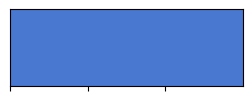

In [14]:
colors = sns.color_palette("muted", 3)[0]
sns.palplot(colors)
plt.show()


Setting the colors for each incubation time

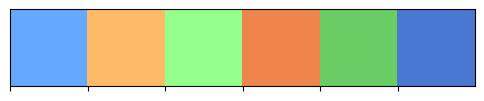

In [15]:
import matplotlib.colors as mcolors

def darken_color(color, factor=0.6):
    rgb = np.array(mcolors.to_rgb(color)) 
    darkened_rgb = rgb * factor
    darkened_rgb = np.clip(darkened_rgb, 0, 1) 
    return mcolors.to_hex(darkened_rgb)  

colors = sns.color_palette("muted", 3)
color_1 = colors[0] 
color_2 = colors[1]  
color_3 = colors[2]  

light_color_1 = darken_color(color_1, factor=1.4)
light_color_2 = darken_color(color_2, factor=1.4)
light_color_3 = darken_color(color_3, factor=1.4)

final_palette = [light_color_1,light_color_2,light_color_3,color_2,color_3,color_1]
sns.palplot(final_palette)
plt.show()


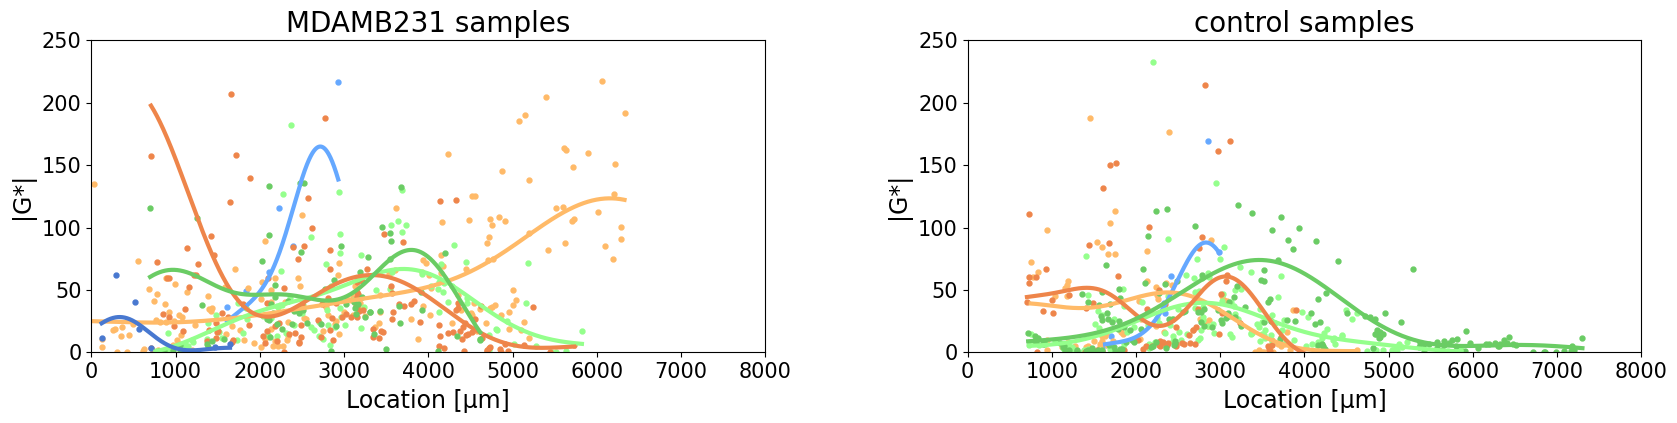

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(1, 2, figsize=(20, 4))
plt.subplots_adjust(wspace=0.3, hspace=0.95, bottom=0.1)  # Adjust bottom for the legend

colors = final_palette  # Adjust the number to the required number of colors

def plotting(grpp, color, cell_ctr):
    if cell_ctr[0] == 'MDAMB231':
        col = 0
    elif cell_ctr[0] == 'control':
        col = 1
    else:
        print(f"Warning: Unexpected cell control type '{cell_ctr}'")
        col = 0  # Default to column 0 (you can change this if necessary)

    
    ax1 = axs[col]

    if (grpp['gradient_direction'] == 'stiff_to_soft').all():
        x_data = grpp['gradient_inverse']
    else:
        x_data = grpp['gradient']
    
    fitting_kernel(x_data, grpp['G_abs'], ax1, 1, color, '.')

    ax1.set_xlabel("Location [µm]", fontsize=17, labelpad=5)
    ax1.set_ylabel("|G*|", fontsize=17, labelpad=5)
    ax1.set_title(f"{cell_ctr[0]} samples", fontsize=20)

    ax1.tick_params(axis='both', labelsize=15)
    ax1.set_ylim(0, 250)
    ax1.set_xlim(0, 8000)


def filtering(grp, i, incubation):  
    color = colors[i]  # Choose color based on index
    
    # Loop through each cell/control type and plot
    for j, (cell_ctr, grpp) in enumerate(grp.groupby(['cell/control'])):
        plotting(grpp, color, cell_ctr)

# Main loop over incubation groups
for i, (incubation, grp) in enumerate(download.groupby(['incubation'])):
    filtering(grp, i, incubation)  # Calling incubation function to handle plotting per group

# Adjust layout and display the plot
plt.show()


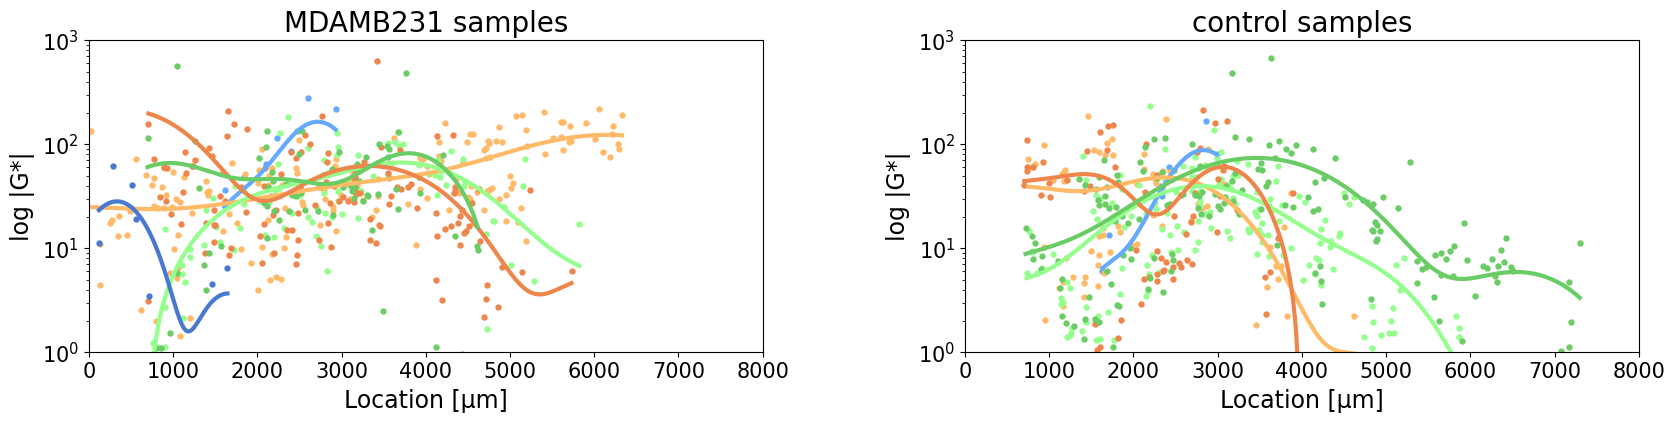

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(20, 4))
plt.subplots_adjust(wspace=0.3, hspace=0.95, bottom=0.1)  # Adjust bottom for the legend

colors = final_palette  # Adjust the number to the required number of colors

def plotting(grpp, color, cell_ctr):
    if cell_ctr[0] == 'MDAMB231':
        col = 0
    elif cell_ctr[0] == 'control':
        col = 1
    else:
        print(f"Warning: Unexpected cell control type '{cell_ctr}'")
        col = 0  # Default to column 0 (you can change this if necessary)

    
    ax1 = axs[col]

    if (grpp['gradient_direction'] == 'stiff_to_soft').all():
        x_data = grpp['gradient_inverse']
    else:
        x_data = grpp['gradient']
    
    fitting_kernel(x_data, grpp['G_abs'], ax1, 1, color, '.')

    ax1.set_xlabel("Location [µm]", fontsize=17, labelpad=5)
    ax1.set_ylabel("log |G*|", fontsize=17, labelpad=5)
    ax1.set_title(f"{cell_ctr[0]} samples", fontsize=20)

    ax1.tick_params(axis='both', labelsize=15)
    
    ax1.set_ylim(1, 1000)
    ax1.set_xlim(0, 8000)
    ax1.set_yscale('log')


def filtering(grp, i, incubation):  
    color = colors[i]  # Choose color based on index
    
    # Loop through each cell/control type and plot
    for j, (cell_ctr, grpp) in enumerate(grp.groupby(['cell/control'])):
        plotting(grpp, color, cell_ctr)

# Main loop over incubation groups
for i, (incubation, grp) in enumerate(download.groupby(['incubation'])):
    filtering(grp, i, incubation)  # Calling incubation function to handle plotting per group

# Adjust layout and display the plot
plt.show()


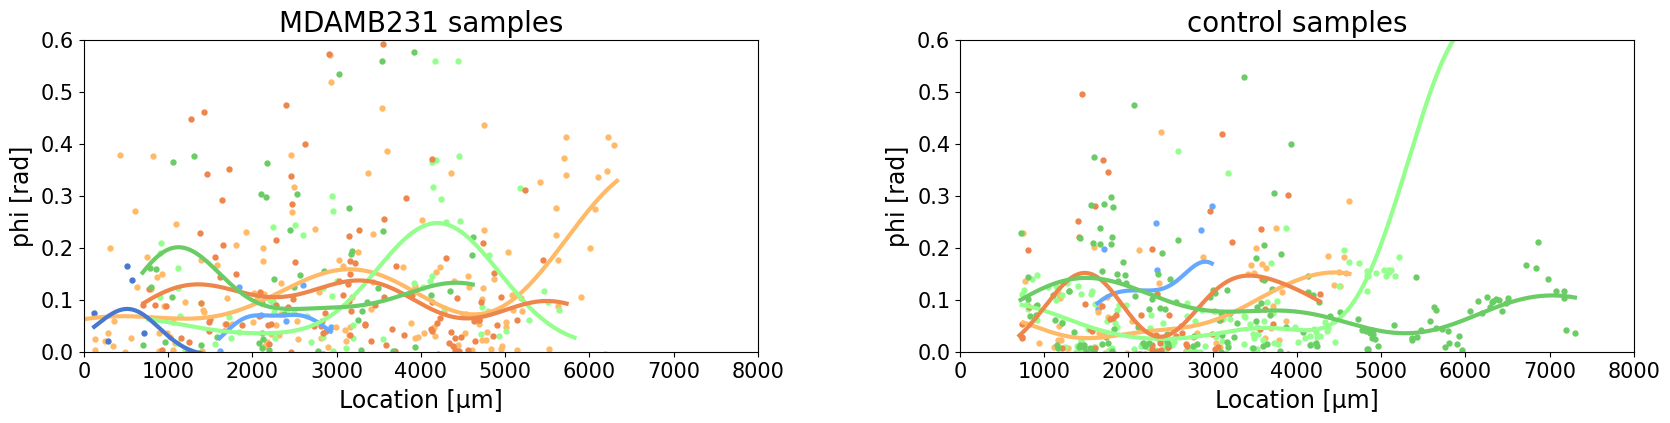

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(20, 4))
plt.subplots_adjust(wspace=0.3, hspace=0.95, bottom=0.1)  # Adjust bottom for the legend

colors = final_palette  # Adjust the number to the required number of colors

def plotting(grpp, color, cell_ctr):
    if cell_ctr[0] == 'MDAMB231':
        col = 0
    elif cell_ctr[0] == 'control':
        col = 1
    else:
    # Default case or handle unexpected 'cell_ctr' values
        print(f"Warning: Unexpected cell control type '{cell_ctr}'")
        col = 0  # Default to column 0 (you can change this if necessary)

    
    ax1 = axs[col]

    if (grpp['gradient_direction'] == 'stiff_to_soft').all():
        x_data = grpp['gradient_inverse']
    else:
        x_data = grpp['gradient']
    
    fitting_kernel(x_data, grpp['phi_(rad)'], ax1, 1, color, '.')

    ax1.set_xlabel("Location [µm]", fontsize=17, labelpad=5)
    ax1.set_ylabel("phi [rad]", fontsize=17, labelpad=5)
    ax1.set_title(f"{cell_ctr[0]} samples", fontsize=20)

    ax1.tick_params(axis='both', labelsize=15)
    ax1.set_ylim(0, 0.6)
    ax1.set_xlim(0, 8000)


def filtering(grp, i, incubation):  
    color = colors[i]  # Choose color based on index
    
    # Loop through each cell/control type and plot
    for j, (cell_ctr, grpp) in enumerate(grp.groupby(['cell/control'])):
        plotting(grpp, color, cell_ctr)

# Main loop over incubation groups
for i, (incubation, grp) in enumerate(download.groupby(['incubation'])):
    filtering(grp, i, incubation)  # Calling incubation function to handle plotting per group

# Adjust layout and display the plot
plt.show()


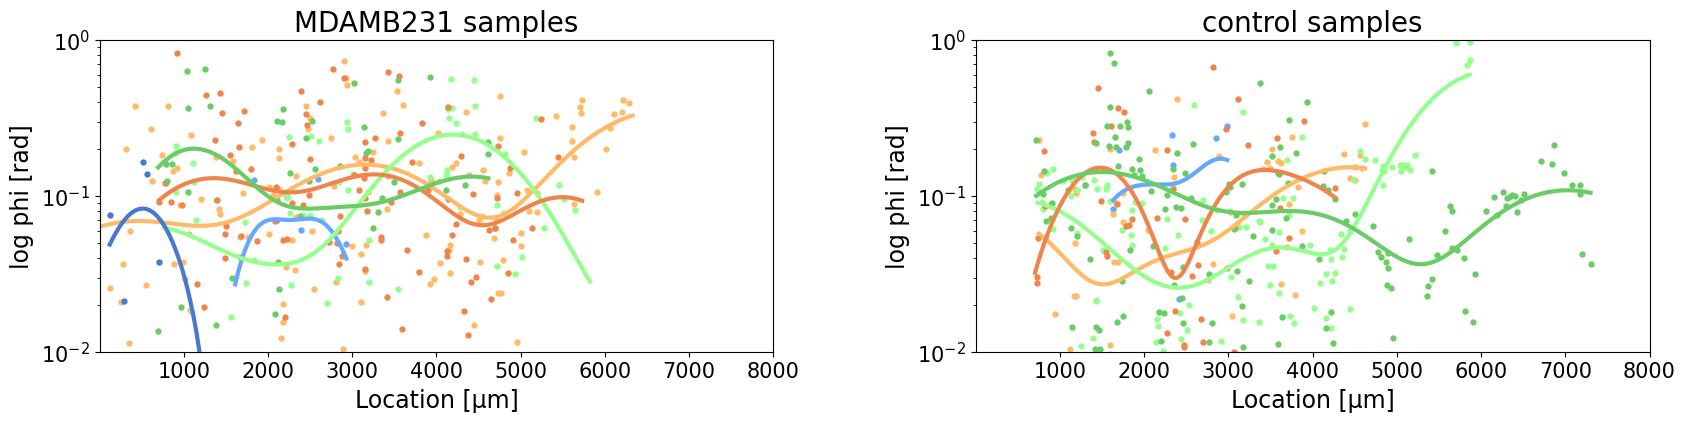

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(20, 4))
plt.subplots_adjust(wspace=0.3, hspace=0.95, bottom=0.1)  # Adjust bottom for the legend

colors = final_palette  # Adjust the number to the required number of colors

def plotting(grpp, color, cell_ctr):
    if cell_ctr[0] == 'MDAMB231':
        col = 0
    elif cell_ctr[0] == 'control':
        col = 1
    else:
    # Default case or handle unexpected 'cell_ctr' values
        print(f"Warning: Unexpected cell control type '{cell_ctr}'")
        col = 0  # Default to column 0 (you can change this if necessary)

    
    ax1 = axs[col]

    if (grpp['gradient_direction'] == 'stiff_to_soft').all():
        x_data = grpp['gradient_inverse']
    else:
        x_data = grpp['gradient']
    
    fitting_kernel(x_data, grpp['phi_(rad)'], ax1, 1, color, '.')

    ax1.set_xlabel("Location [µm]", fontsize=17, labelpad=5)
    ax1.set_ylabel("log phi [rad]", fontsize=17, labelpad=5)
    ax1.set_title(f"{cell_ctr[0]} samples", fontsize=20)

    ax1.tick_params(axis='both', labelsize=15)
    ax1.set_ylim(0.01, 1)
    ax1.set_xlim(1, 8000)
    ax1.set_yscale('log')


def filtering(grp, i, incubation):  
    color = colors[i]  # Choose color based on index
    
    # Loop through each cell/control type and plot
    for j, (cell_ctr, grpp) in enumerate(grp.groupby(['cell/control'])):
        plotting(grpp, color, cell_ctr)

# Main loop over incubation groups
for i, (incubation, grp) in enumerate(download.groupby(['incubation'])):
    filtering(grp, i, incubation)  # Calling incubation function to handle plotting per group

# Adjust layout and display the plot
plt.show()


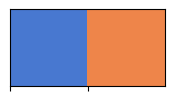

In [20]:
def darken_color(color, factor=0.6):
    rgb = np.array(mcolors.to_rgb(color))
    darkened_rgb = rgb * factor
    darkened_rgb = np.clip(darkened_rgb, 0, 1)
    return mcolors.to_hex(darkened_rgb)  

colors = sns.color_palette("muted", 3)
color_1 = colors[0]  
color_2 = colors[1]  

light_color_1 = darken_color(color_1, factor=1.4)
light_color_2 = darken_color(color_2, factor=1.4)

final_palette1 = [color_1,color_2]

sns.palplot(final_palette1)

plt.show()


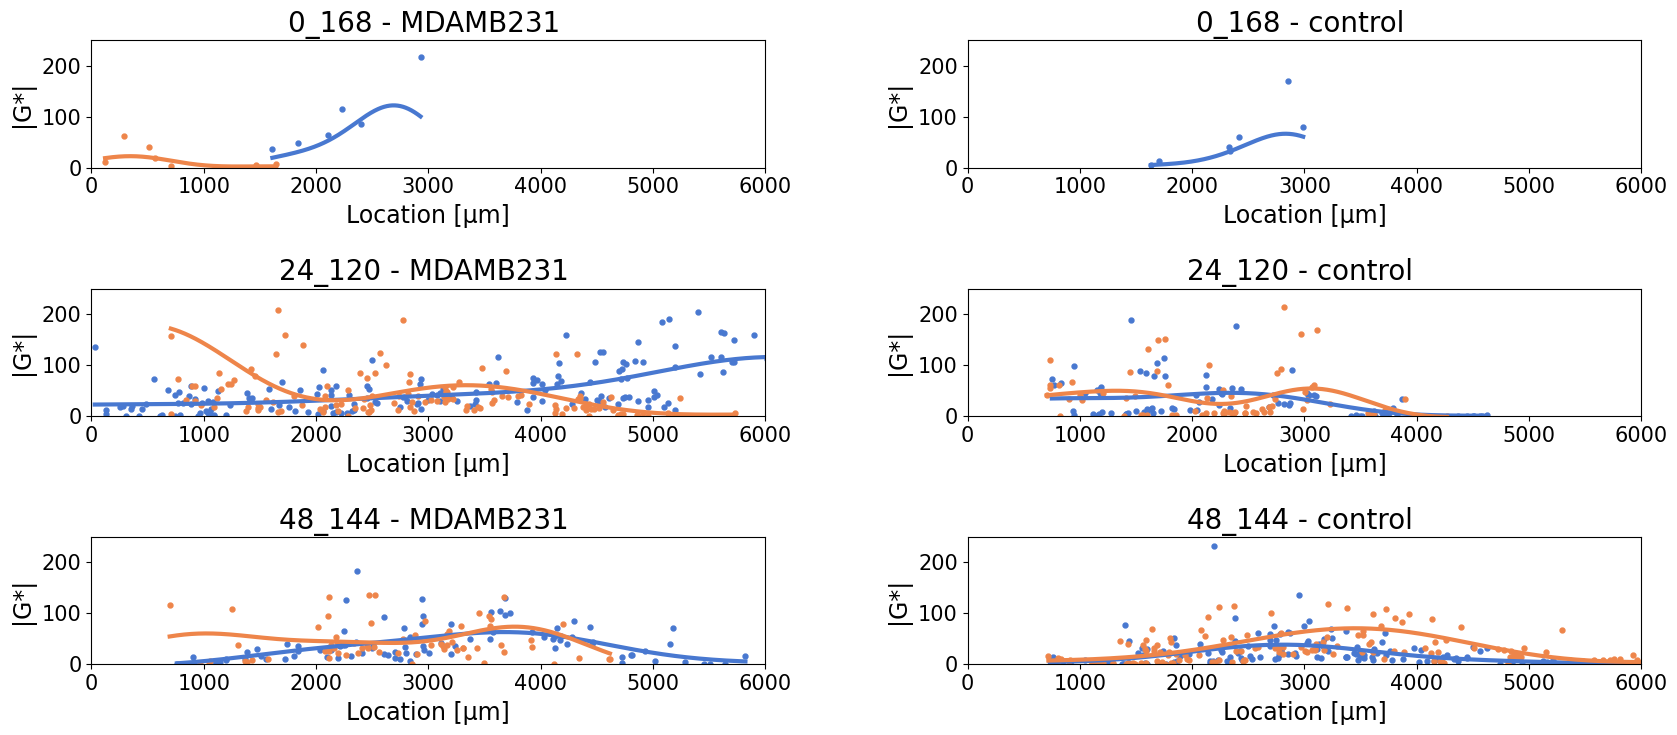

In [21]:
fig, axs = plt.subplots(3, 2, figsize=(20, 8))
plt.subplots_adjust(wspace=0.3, hspace=0.95, bottom=0.1) 

colors = final_palette1  

def plotting(grppp, ax1,k,i, incubation):
    if (grppp['gradient_direction'] == 'stiff_to_soft').all():
        x_data = grppp['gradient_inverse']
    else:
        x_data = grppp['gradient']
    countr= (k)
    color = final_palette1[countr]
    fitting_kernel(x_data, grppp['G_abs'], ax1, 2, color, '.')

    ax1.set_xlabel("Location [µm]", fontsize=17, labelpad=5)
    ax1.set_ylabel("|G*|", fontsize=17, labelpad=5)
    ax1.set_title(f"{grppp['incubation_set'].unique()[0]} - {grppp['cell/control'].unique()[0]} ", fontsize=20)

    ax1.tick_params(axis='both', labelsize=15)
    ax1.set_ylim(0, 250)
    ax1.set_xlim(0, 6000)

    
def plotting_time(grpp, row,i, cell_ctr):
    if cell_ctr[0] == 'MDAMB231':
        col = 0
    elif cell_ctr[0] == 'control':
        col = 1
    else:
        print(f"Warning: Unexpected cell control type '{cell_ctr}'")

    ax1 = axs[row,col]

    for k, (incubation, grppp) in enumerate(grpp.groupby(['incubation'])):
        plotting(grppp, ax1,k,i,incubation)

def filtering_cell_ctr(grp, i):  
    row = i 
    for j, (cell_ctr, grpp) in enumerate(grp.groupby(['cell/control'])):
        plotting_time(grpp, row, i,cell_ctr)

for i, (incubation_set, grp) in enumerate(download.groupby(['incubation_set'])):
    filtering_cell_ctr(grp, i)  

plt.show()


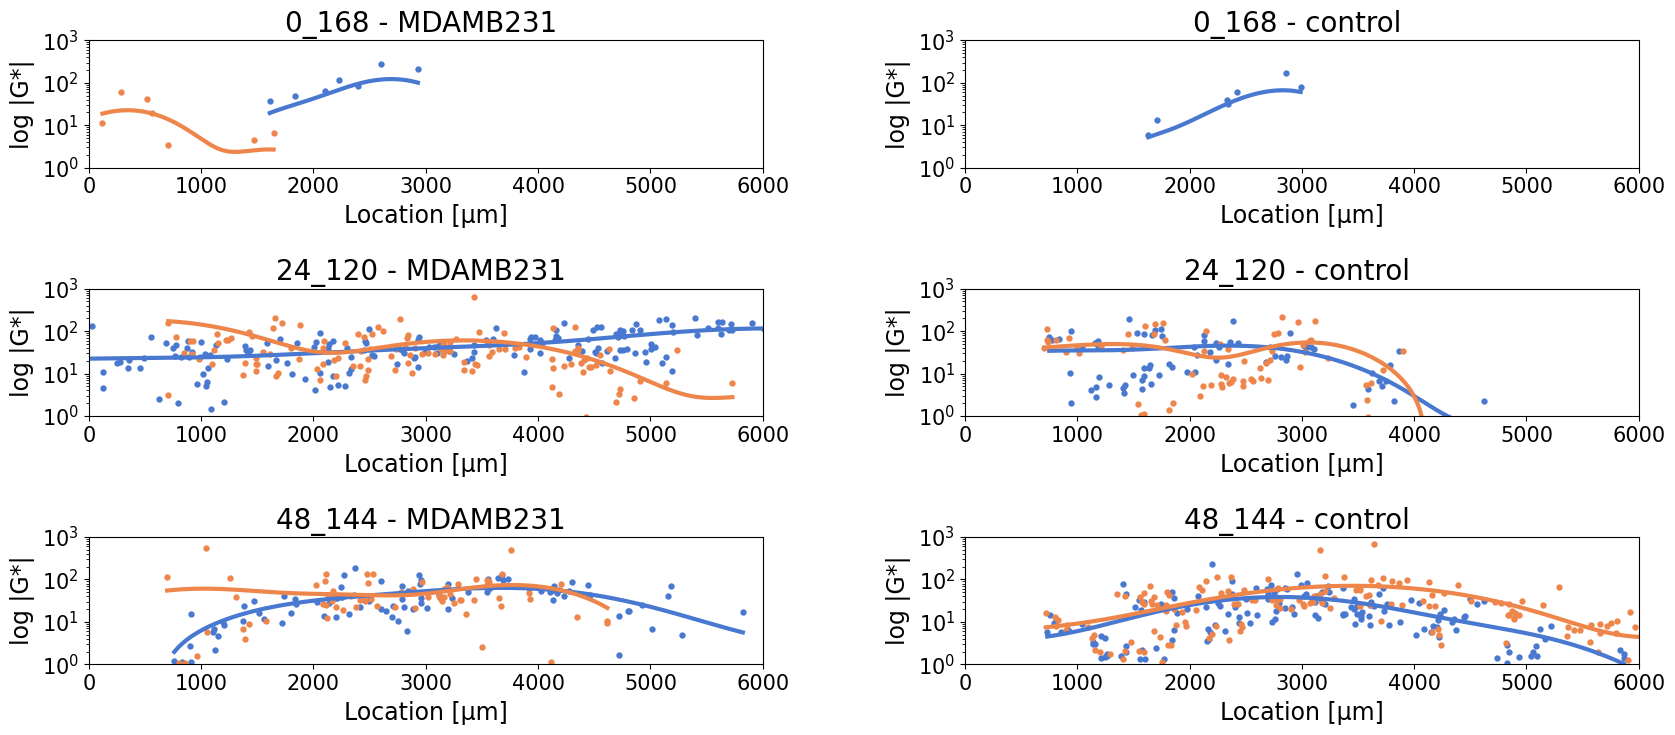

In [22]:
fig, axs = plt.subplots(3, 2, figsize=(20, 8))
plt.subplots_adjust(wspace=0.3, hspace=0.95, bottom=0.1) 

colors = final_palette1  

def plotting(grppp, ax1,k,i, incubation):
    if (grppp['gradient_direction'] == 'stiff_to_soft').all():
        x_data = grppp['gradient_inverse']
    else:
        x_data = grppp['gradient']
    countr= (k)
    color = final_palette1[countr]
    fitting_kernel(x_data, grppp['G_abs'], ax1, 2, color, '.')

    ax1.set_xlabel("Location [µm]", fontsize=17, labelpad=5)
    ax1.set_ylabel("log |G*|", fontsize=17, labelpad=5)
    ax1.set_title(f"{grppp['incubation_set'].unique()[0]} - {grppp['cell/control'].unique()[0]} ", fontsize=20)

    ax1.tick_params(axis='both', labelsize=15)
    ax1.set_ylim(1, 1000)
    ax1.set_yscale('log')
    ax1.set_xlim(0, 6000)

    
def plotting_time(grpp, row,i, cell_ctr):
    if cell_ctr[0] == 'MDAMB231':
        col = 0
    elif cell_ctr[0] == 'control':
        col = 1
    else:
        print(f"Warning: Unexpected cell control type '{cell_ctr}'")

    ax1 = axs[row,col]

    for k, (incubation, grppp) in enumerate(grpp.groupby(['incubation'])):
        plotting(grppp, ax1,k,i,incubation)

def filtering_cell_ctr(grp, i):  
    row = i 
    for j, (cell_ctr, grpp) in enumerate(grp.groupby(['cell/control'])):
        plotting_time(grpp, row, i,cell_ctr)

for i, (incubation_set, grp) in enumerate(download.groupby(['incubation_set'])):
    filtering_cell_ctr(grp, i)  

plt.show()


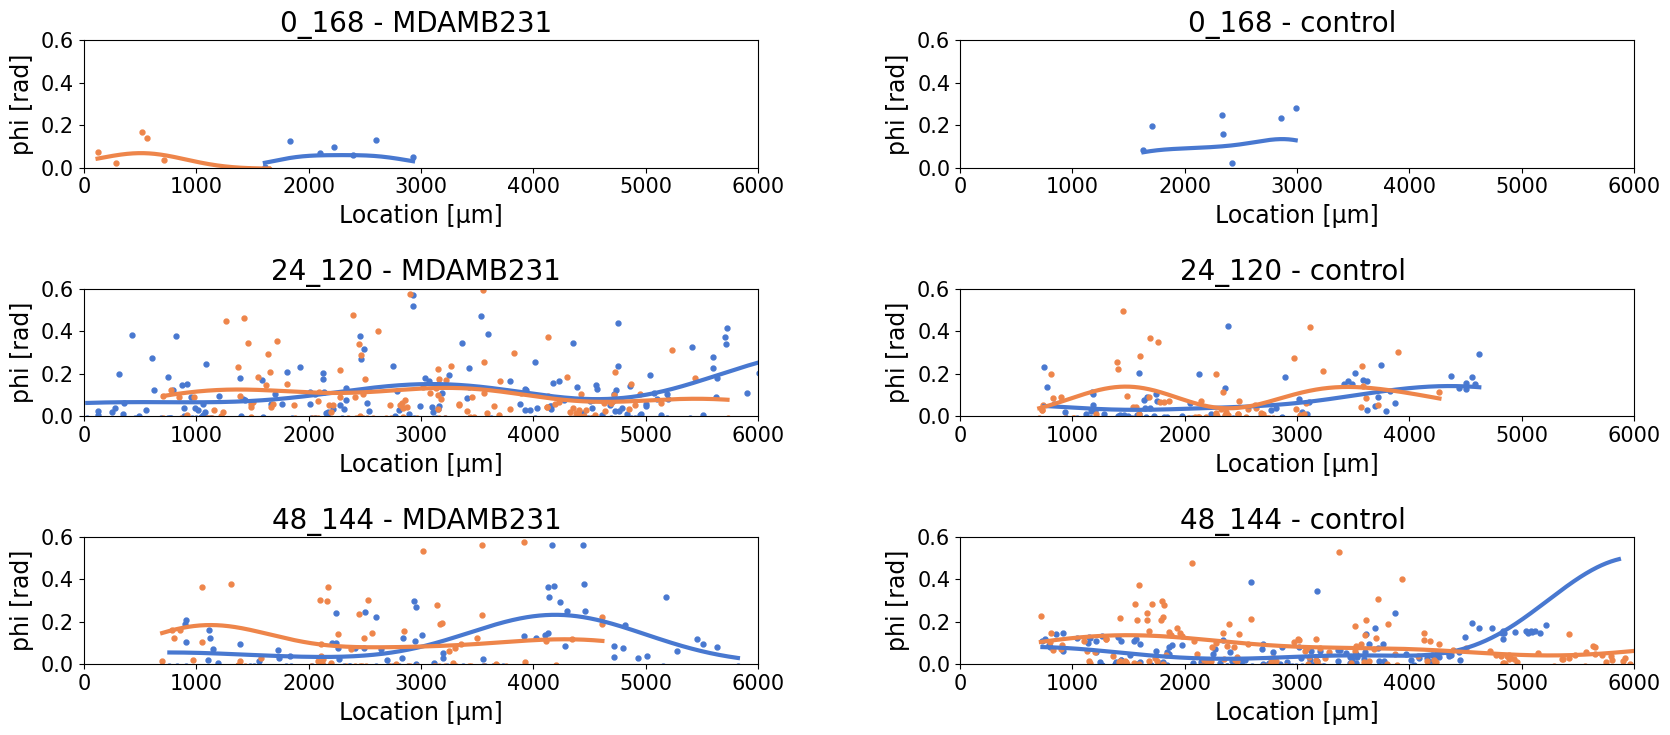

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(3, 2, figsize=(20, 8))
plt.subplots_adjust(wspace=0.3, hspace=0.95, bottom=0.1) 

colors = final_palette1  

def plotting(grppp, ax1,k,i, incubation):
    if (grppp['gradient_direction'] == 'stiff_to_soft').all():
        x_data = grppp['gradient_inverse']
    else:
        x_data = grppp['gradient']
    countr= (k)
    color = final_palette1[countr]
    fitting_kernel(x_data, grppp['phi_(rad)'], ax1, 2, color, '.')

    ax1.set_xlabel("Location [µm]", fontsize=17, labelpad=5)
    ax1.set_ylabel("phi [rad]", fontsize=17, labelpad=5)
    ax1.set_title(f"{grppp['incubation_set'].unique()[0]} - {grppp['cell/control'].unique()[0]} ", fontsize=20)

    ax1.tick_params(axis='both', labelsize=15)
    ax1.set_ylim(0, 0.6)
    ax1.set_xlim(0, 6000)

    
def plotting_time(grpp, row,i, cell_ctr):
    if cell_ctr[0] == 'MDAMB231':
        col = 0
    elif cell_ctr[0] == 'control':
        col = 1
    else:
        print(f"Warning: Unexpected cell control type '{cell_ctr}'")

    ax1 = axs[row,col]

    for k, (incubation, grppp) in enumerate(grpp.groupby(['incubation'])):
        plotting(grppp, ax1,k,i,incubation)

def filtering_cell_ctr(grp, i):  
    row = i 
    for j, (cell_ctr, grpp) in enumerate(grp.groupby(['cell/control'])):
        plotting_time(grpp, row, i,cell_ctr)

for i, (incubation_set, grp) in enumerate(download.groupby(['incubation_set'])):
    filtering_cell_ctr(grp, i)  

plt.show()


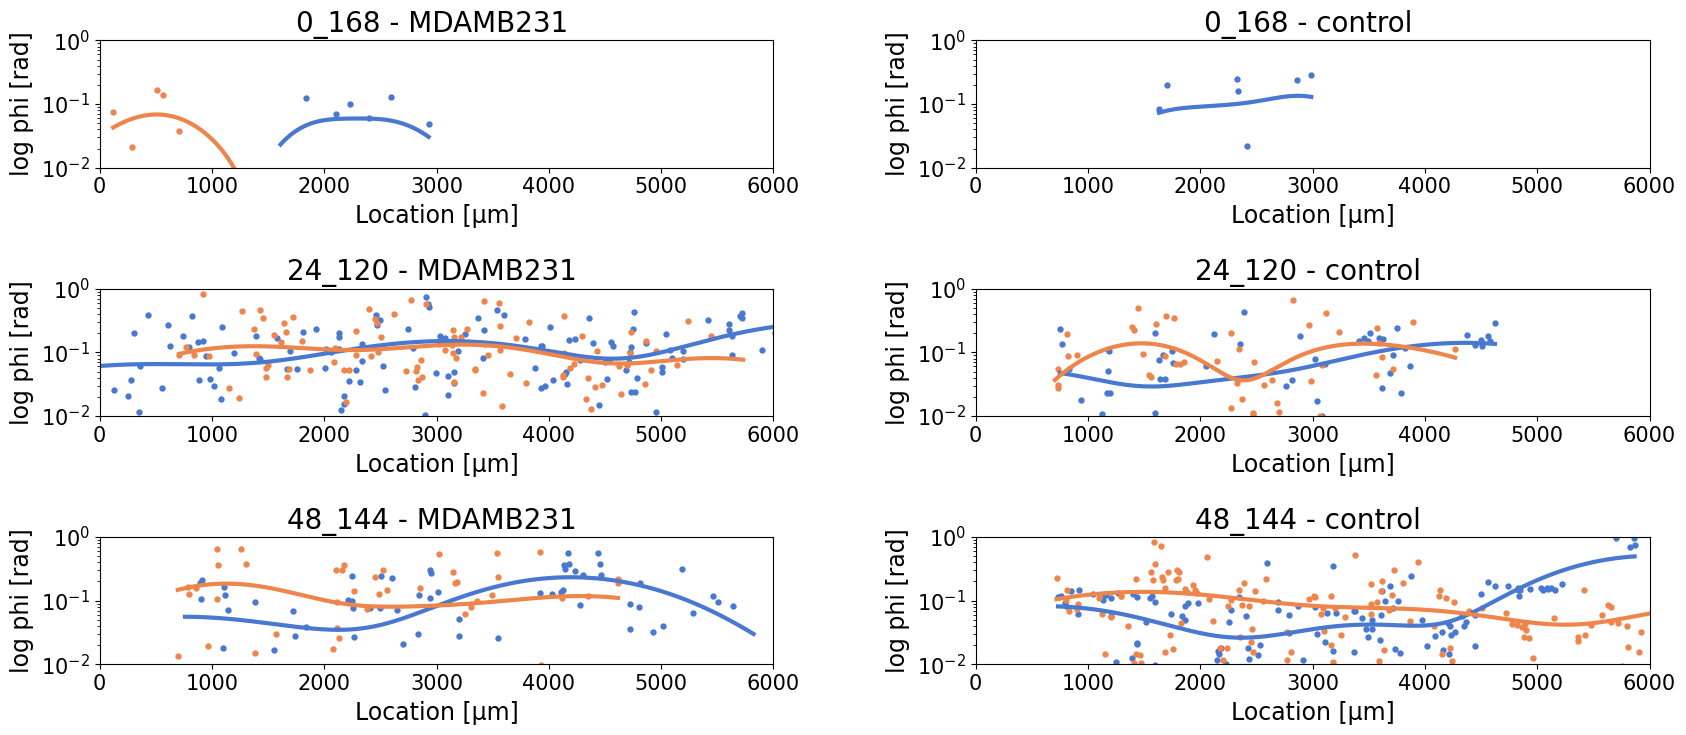

In [24]:
fig, axs = plt.subplots(3, 2, figsize=(20, 8))
plt.subplots_adjust(wspace=0.3, hspace=0.95, bottom=0.1) 

colors = final_palette1  

def plotting(grppp, ax1,k,i, incubation):
    if (grppp['gradient_direction'] == 'stiff_to_soft').all():
        x_data = grppp['gradient_inverse']
    else:
        x_data = grppp['gradient']
    countr= (k)
    color = final_palette1[countr]
    fitting_kernel(x_data, grppp['phi_(rad)'], ax1, 2, color, '.')

    ax1.set_xlabel("Location [µm]", fontsize=17, labelpad=5)
    ax1.set_ylabel("log phi [rad]", fontsize=17, labelpad=5)
    ax1.set_title(f"{grppp['incubation_set'].unique()[0]} - {grppp['cell/control'].unique()[0]} ", fontsize=20)

    ax1.tick_params(axis='both', labelsize=15)
    ax1.set_ylim(0.01, 1)
    ax1.set_yscale('log')
    ax1.set_xlim(0, 6000)

    
def plotting_time(grpp, row,i, cell_ctr):
    if cell_ctr[0] == 'MDAMB231':
        col = 0
    elif cell_ctr[0] == 'control':
        col = 1
    else:
        print(f"Warning: Unexpected cell control type '{cell_ctr}'")

    ax1 = axs[row,col]

    for k, (incubation, grppp) in enumerate(grpp.groupby(['incubation'])):
        plotting(grppp, ax1,k,i,incubation)

def filtering_cell_ctr(grp, i):  
    row = i 
    for j, (cell_ctr, grpp) in enumerate(grp.groupby(['cell/control'])):
        plotting_time(grpp, row, i,cell_ctr)

for i, (incubation_set, grp) in enumerate(download.groupby(['incubation_set'])):
    filtering_cell_ctr(grp, i)  

plt.show()


OLDER 2024 DATA

In [112]:
download1.columns

Index(['Unnamed: 0', 'day', 'sample', 'holder', 'location', 'track_id',
       'reference_id', 'distance(um)', 'Cov_Sum', 'a_(um)', 'phi_(rad)', 'c',
       'd', 'G_abs', 'radius_(m)', 'rmse', 'inv.rmse', 'shift_(s)', 'a_error',
       'phi_error', 'c_error', 'd_error', 'x', 'y', 'repeat', 'phi_(deg)',
       'tan_phi', 'path', 'irradiation', 'incubation_set', 'incubation',
       'experiment', 'cell/control', 'bead_radius', 'location_inverse',
       'gradient', 'gradient_inverse', 'gradient_direction', 'experiment_id'],
      dtype='object')

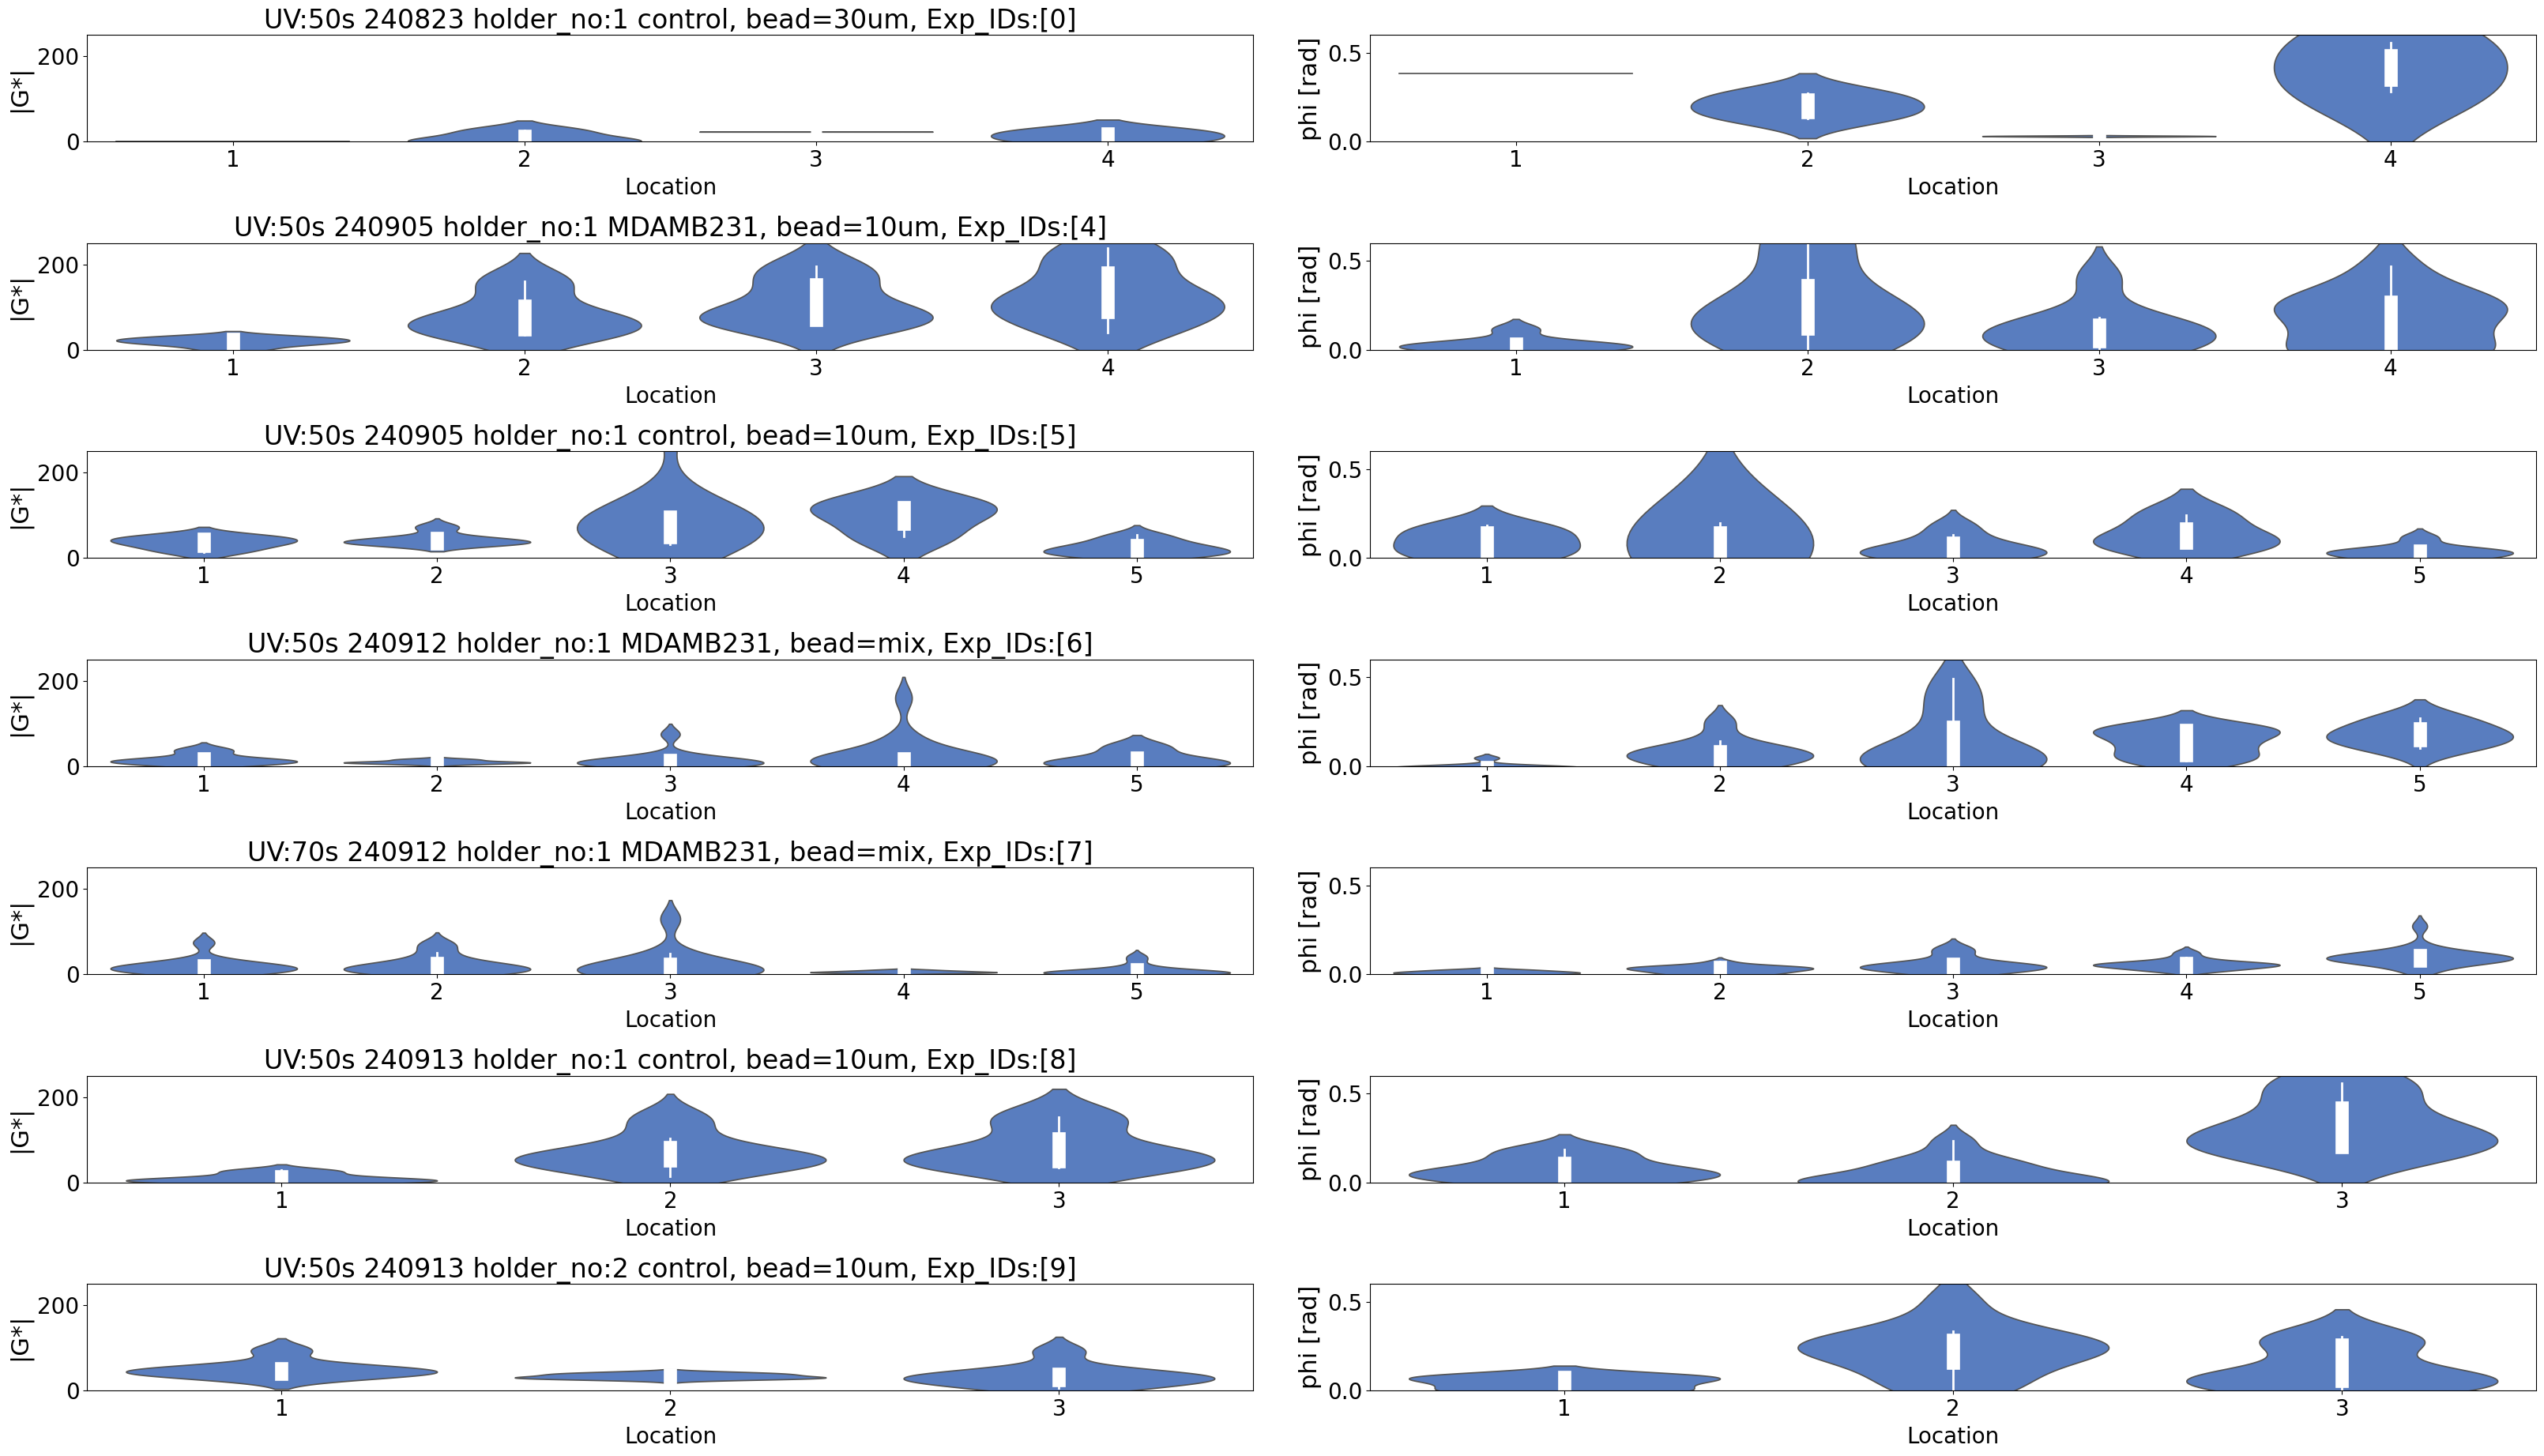

In [117]:
fig, axs = plt.subplots(7, 2, figsize=(40, 22))
plt.subplots_adjust(wspace=0.1, hspace=0.95, bottom=0.1)  # Adjust bottom to make space for the legend
fig.suptitle("", fontsize=22)

markers = ['x', 's']
pal = sns.color_palette("muted", 1)[0]  

def plotting(data, i, day, holder, irradiation, cell_control):
    bead = data['bead_radius'].unique()[0]
    if (data['gradient_direction'] == 'stiff_to_soft').all():
        x_data = data['location_inverse']
    else:
        x_data = data['location']

    ax1 = axs[i, 0] 
    exp_id=data['experiment_id'].unique()
    sns.violinplot(x=x_data, y='G_abs', data=data, 
                   inner='box', width=0.8, 
                   density_norm='width', ax=ax1, 
                   inner_kws=dict(box_width=12, whis_width=2, color="1"), 
                   color=pal) 
        
    ax1.set_xlabel("Location", fontsize=20, labelpad=5)
    ax1.set_ylabel("|G*|", fontsize=22, labelpad=5)
    ax1.set_title(f"UV:{irradiation} {day} holder_no:{holder} {cell_control}, bead={bead}, Exp_IDs:{exp_id}", fontsize=24)
    ax1.tick_params(axis='both', labelsize=20)
    ax1.set_ylim(0,250)

    ax2 = axs[i, 1]
    sns.violinplot(x=x_data, y='phi_(rad)', data=data, 
                   inner='box', width=0.8, 
                   density_norm='width', ax=ax2, 
                   inner_kws=dict(box_width=12, whis_width=2, color="1"), 
                   color=pal)
                   
    ax2.set_xlabel("Location", fontsize=20, labelpad=5)
    ax2.set_ylabel("phi [rad]", fontsize=22, labelpad=5)
    ax2.tick_params(axis='both', labelsize=20)
    ax2.set_ylim(0, 0.6)
    
for i, ((day, holder, irradiation, cell_control), group_data) in enumerate(download1.groupby(['day', 'holder', 'irradiation', 'cell/control'])):
    plotting(group_data, i, day, holder, irradiation, cell_control)


plt.show()


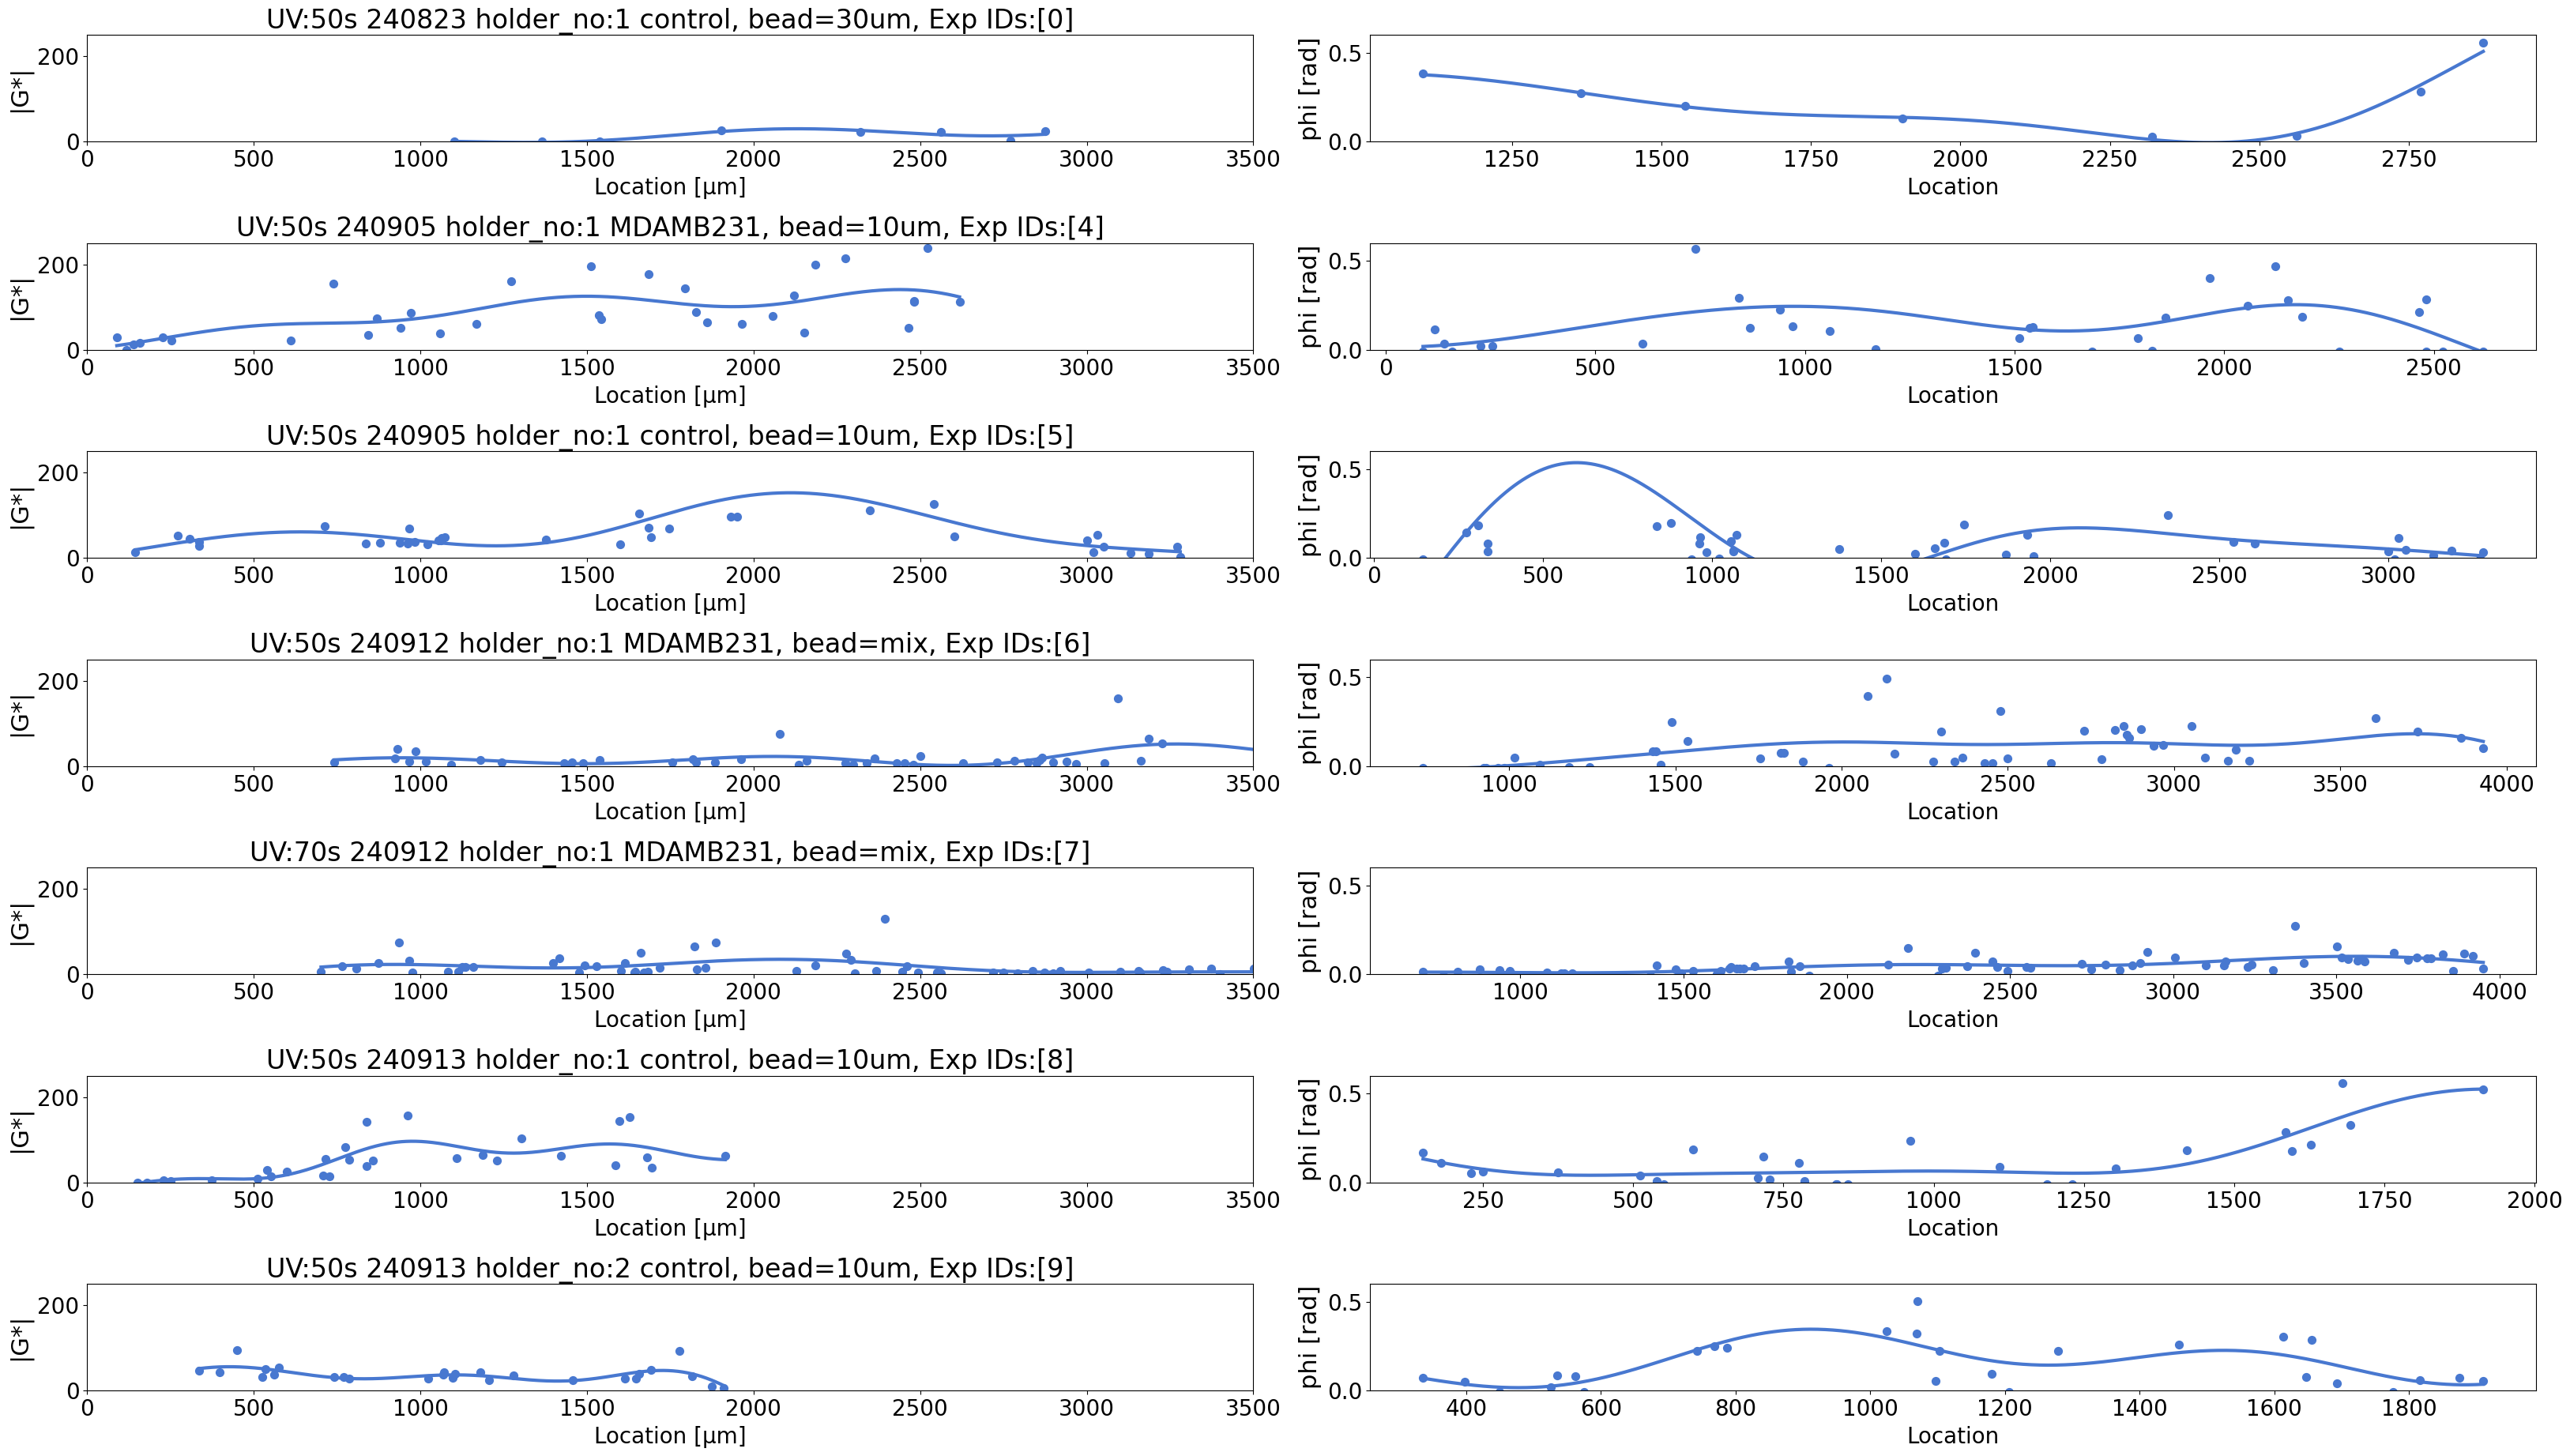

In [116]:
def fitting_kernel_bin(x, y, ax,alpha, color):
    x_reshaped = x.values.reshape(-1, 1)  #     # Reshape x to a 2D array (required for scikit-learn models), converts x into a 2D array with shape (n_samples, 1)
    y_reshaped = y.values 
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(x_reshaped) 
    
    # Initialize Kernel Ridge Regression model
    # similarity between two points in higher-dimensional space = this is done using a kernel function, here Radial Basis Function (RBF) kernel
    # ALPHA = regularization factor
    krr = KernelRidge(kernel='rbf', alpha=alpha)  # A larger --> more regularization; model prioritizes simpler solutions fitting general trend and not capture smaller details
    # Fit the model with the given data
    krr.fit(x_scaled, y_reshaped)

    # Grid of x values for the kernel fit (scaled)
    x_fit = np.linspace(np.min(x_scaled), np.max(x_scaled), 1000)[:, np.newaxis]  # Fine grid for prediction
    y_fit = krr.predict(x_fit)  # Predict the y values for the fine grid

    # Rescale x_fit back to original scale for plotting
    x_fit_original = scaler.inverse_transform(x_fit)  # Rescale the x values back

    # Plot the original data as a scatter plot
    ax.scatter(x_reshaped, y_reshaped, label='Original Data', color=color,s=50)
    
    #ax.boxplot(x_reshaped, y_reshaped, label='Original Data')

    # Plot the kernel fit (the kernel regression curve)
    ax.plot(x_fit_original, y_fit,color=color, label='Kernel Fit', linewidth=3)

# Create subplots
fig, axs = plt.subplots(7, 2, figsize=(40, 22))
plt.subplots_adjust(wspace=0.1, hspace=0.95, bottom=0.1)  # Adjust bottom to make space for the legend
fig.suptitle("", fontsize=22)

# Choose the first color from the "muted" palette
pal = sns.color_palette("muted", 1)[0]  

def plotting(data, i, day, holder, irradiation, cell_control, alpha=1e-2):
    bead = data['bead_radius'].unique()[0]

    if (data['gradient_direction'] == 'stiff_to_soft').all():
        x_data = data['gradient_inverse']
    else:
        x_data = data['gradient']

    exp_id=data['experiment_id'].unique()

    # Plot for G_abs
    ax1 = axs[i, 0] 
    # sns.violinplot(x=x_data, y='G_abs', data=data, 
    #                inner='box', width=0.8, 
    #                density_norm='width', ax=ax1, legend=True, 
    #                inner_kws=dict(box_width=12, whis_width=2, color="1"), 
    #                color=pal) 
    fitting_kernel_bin(x_data, data['G_abs'], ax1, alpha, pal)  # Add the kernel regression line
        
    ax1.set_xlabel("Location [µm]", fontsize=20, labelpad=5)
    ax1.set_ylabel("|G*|", fontsize=22, labelpad=5)
    ax1.set_title(f"UV:{irradiation} {day} holder_no:{holder} {cell_control}, bead={bead}, Exp IDs:{exp_id}", fontsize=24)
    ax1.tick_params(axis='both', labelsize=20)
    ax1.legend().remove()
    ax1.set_ylim(0,250)
    ax1.set_xlim(0,3500)


    # Plot for phi_(rad)
    ax2 = axs[i, 1]
    # sns.violinplot(x=x_data, y='phi_(rad)', data=data, 
    #                inner='box', width=0.8, 
    #                density_norm='width', ax=ax2, legend=True, 
    #                inner_kws=dict(box_width=12, whis_width=2, color="1"), 
    #                color=pal) 
    fitting_kernel_bin(x_data, data['phi_(rad)'], ax2, alpha, pal)  # Add the kernel regression line

    ax2.set_xlabel("Location", fontsize=20, labelpad=5)
    ax2.set_ylabel("phi [rad]", fontsize=22, labelpad=5)
    ax2.tick_params(axis='both', labelsize=20)
    ax2.legend().remove()
    ax2.set_ylim(0, 0.6)
    ax1.set_xlim(0,3500)


# Assuming `old_df` is your DataFrame
for i, ((day, holder, irradiation, cell_control), group_data) in enumerate(download1.groupby(['day', 'holder', 'irradiation', 'cell/control'])):
    plotting(group_data, i, day, holder, irradiation, cell_control)

plt.show()


## Individual plots

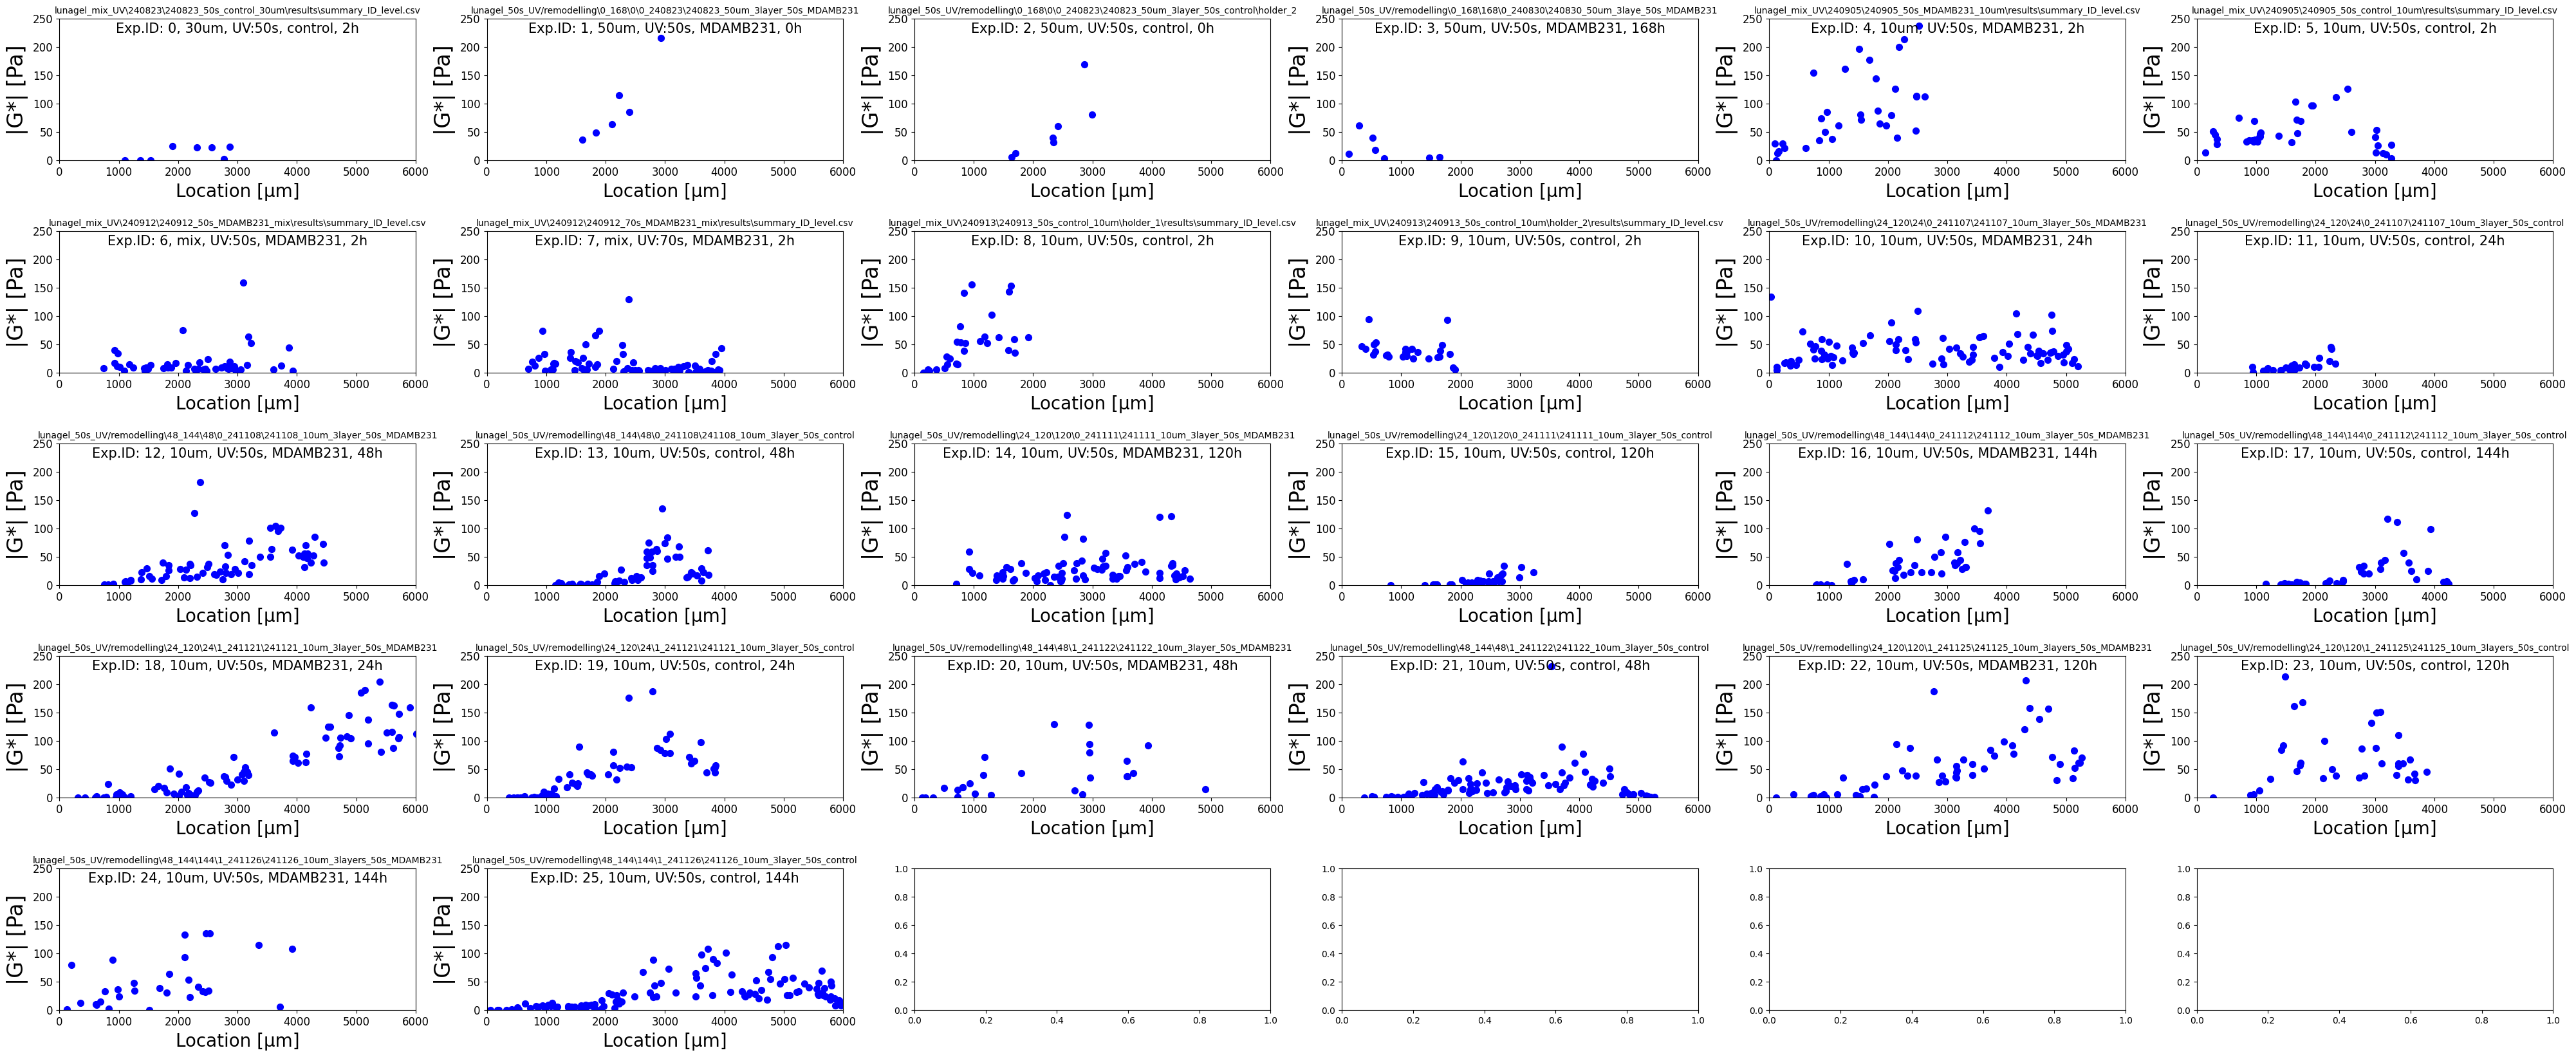

In [106]:
saving_path = 'C:/Users/srboval1/OneDrive - Aalto University/Collab/Ivaska_collab/data'
all = pd.read_csv(saving_path +'/all_data.csv', index_col=None)

# Set up the 6x4 grid of subplots (4 rows, 6 columns)
fig, axs = plt.subplots(5, 6, figsize=(50, 20))
plt.subplots_adjust(wspace=0.2, hspace=0.5)

def plotting(group_data, ax):
    # Select x_data based on gradient direction
    if (group_data['gradient_direction'] == 'stiff_to_soft').all():
        x_data = group_data['gradient_inverse']
    else:
        x_data = group_data['gradient']
    
    exp_type = (group_data['cell/control'].unique()).item()
    exp_id = (group_data['experiment_id'].unique()).item()
    bead = (group_data['bead_radius'].unique()).item()
    irradiation = (group_data['irradiation'].unique()).item()
    path= (group_data['path'].unique()).item()
    incubation_time=(group_data['incubation'].unique()).item()

    second_line = f"Exp.ID: {exp_id}, {bead}, UV:{irradiation}, {exp_type}, {incubation_time}h"
    first_line = f"{path}"
    
    # Plot the data
    ax.scatter(x_data, group_data['G_abs'], label='Original Data', color='b', s=50)
    ax.set_xlabel("Location [µm]", fontsize=20, labelpad=5)
    ax.set_ylabel("|G*| [Pa]", fontsize=24, labelpad=5)
    ax.set_title(first_line, fontsize=10)
    ax.text(0.5, 0.93, second_line, ha='center', va='center', transform=ax.transAxes, fontsize=15)
    ax.tick_params(axis='both', labelsize=12)
    ax.set_ylim(0, 250)
    ax.set_xlim(0, 6000)

    # Set the legend
    ax.legend(title="Incubation [hours]", fontsize=20, title_fontsize=22, loc='upper left', bbox_to_anchor=(1.01, 1), frameon=False)
    ax.legend().set_visible(False)

# Loop through all unique experiment_id values and plot on the 6x4 grid
all_experiment_ids = sorted(all['experiment_id'].unique())

for idx, experiment_id in enumerate(all_experiment_ids):
    # Compute row and column index for the subplot
    row = idx // 6  # Integer division to get the row index
    col = idx % 6   # Modulus to get the column index
    
    # Get data for the current experiment_id
    group_data = all[all['experiment_id'] == experiment_id]
    
    # Pass the corresponding subplot (ax) to the plotting function
    plotting(group_data, axs[row, col])

# Show the plot
plt.show()


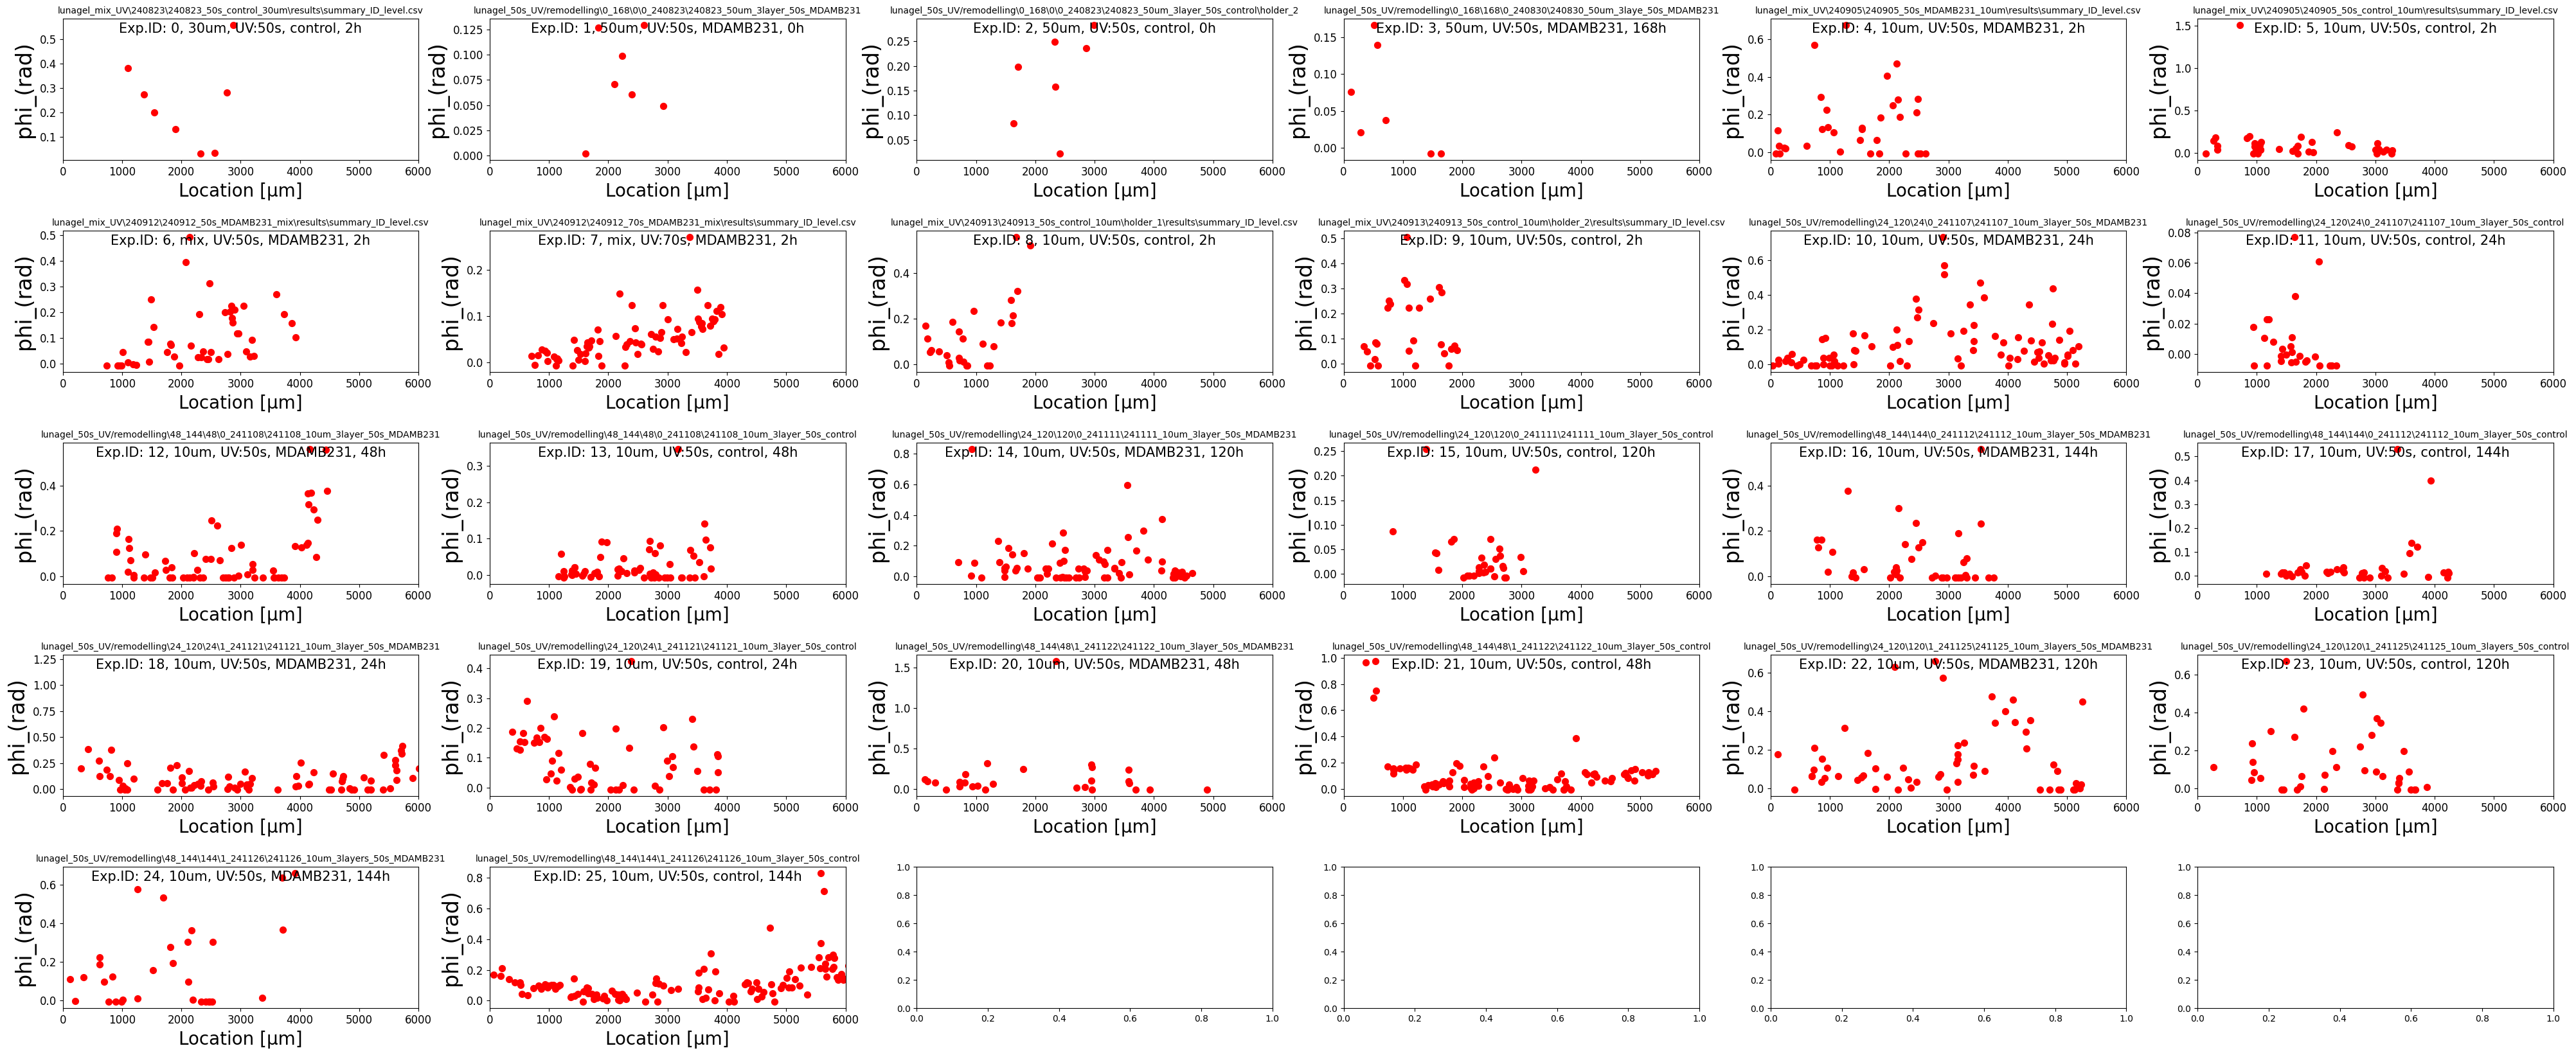

In [107]:
import matplotlib.pyplot as plt

# Set up the 6x4 grid of subplots (4 rows, 6 columns)
fig, axs = plt.subplots(5, 6, figsize=(50, 20))
plt.subplots_adjust(wspace=0.2, hspace=0.5)

def plotting(group_data, ax):
    # Select x_data based on gradient direction
    if (group_data['gradient_direction'] == 'stiff_to_soft').all():
        x_data = group_data['gradient_inverse']
    else:
        x_data = group_data['gradient']
    
    exp_type = (group_data['cell/control'].unique()).item()
    exp_id = (group_data['experiment_id'].unique()).item()
    bead = (group_data['bead_radius'].unique()).item()
    irradiation = (group_data['irradiation'].unique()).item()
    path= (group_data['path'].unique()).item()
    incubation_time=(group_data['incubation'].unique()).item()

    second_line = f"Exp.ID: {exp_id}, {bead}, UV:{irradiation}, {exp_type}, {incubation_time}h"
    first_line = f"{path}"
    # Plot the data
    ax.scatter(x_data, group_data['phi_(rad)'], label='Original Data', color='r', s=50)
    ax.set_xlabel("Location [µm]", fontsize=20, labelpad=5)
    ax.set_ylabel("phi_(rad)", fontsize=24, labelpad=5)
    ax.set_title(first_line, fontsize=10)
    ax.text(0.5, 0.93, second_line, ha='center', va='center', transform=ax.transAxes, fontsize=15)
    ax.tick_params(axis='both', labelsize=12)
    ax.set_xlim(0, 6000)

    # Set the legend
    ax.legend(title="Incubation [hours]", fontsize=20, title_fontsize=22, loc='upper left', bbox_to_anchor=(1.01, 1), frameon=False)
    ax.legend().set_visible(False)

# Loop through all unique experiment_id values and plot on the 6x4 grid
all_experiment_ids = sorted(all['experiment_id'].unique())

for idx, experiment_id in enumerate(all_experiment_ids):
    # Compute row and column index for the subplot
    row = idx // 6  # Integer division to get the row index
    col = idx % 6   # Modulus to get the column index
    
    # Get data for the current experiment_id
    group_data = all[all['experiment_id'] == experiment_id]
    
    # Pass the corresponding subplot (ax) to the plotting function
    plotting(group_data, axs[row, col])

# Show the plot
plt.show()
